# Driver Aggression Neural Network (DANN)

Driver Aggression Neural Network is assigning an aggression value to a sorted set of sensory data. Driving is simulated in BeamNG v0.27 using their BeamNGpy open-source library.

In [249]:
import pandas as pd
import torch
import glob
import uuid

parquet_file_path = '../imu_data*.parquet'
file_list = glob.glob(parquet_file_path)

# Initialize an empty list to hold the dataframes
df_list = []
# Loop through the file list and read each file into a dataframe
for file in file_list:
    df = pd.read_parquet(file)
    # Assign UUID to imuId
    # create a dictionary that maps each unique imuId to a random UUID
    uuid_dict = {imuId: str(uuid.uuid4()) for imuId in df['imuId'].unique()}
    # replace imuId values using the dictionary
    df['imuId'] = df['imuId'].map(uuid_dict)
    df_list.append(df)

# Concatenate all the dataframes into a single dataframe
data = pd.concat(df_list, ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modify training data

- Group together data recorded from the same sensor
- Take around 100-1000 recorded data without the aggression values
- Make aggression values the label of the dataset
- Create a lot of training data by chunking the sorted (by timestamp) records.

C:\Users\illya\AppData\Local\Temp\ipykernel_7588\4117678759.py:123: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("all")
C:\Users\illya\AppData\Local\Temp\ipykernel_7588\4117678759.py:123: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option("all")
C:\Users\illya\AppData\Local\Temp\ipykernel_7588\4117678759.py:123: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option("all")


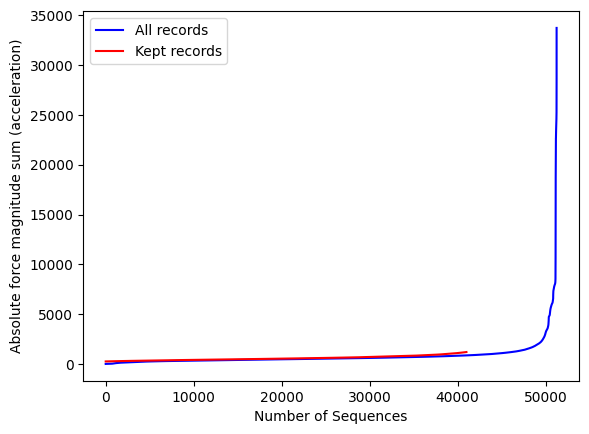

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming 'data' is your Scheme
# data = pd.DataFrame(columns=[
#     'imuId',
#     'vehicleAggression',
#     'time',
#     'pos',
#     'dirX',
#     'dirY',
#     'dirZ',
#     'angVel',
#     'angAccel',
#     'mass',
#     'accRaw',
#     'accSmooth'
# ])

# Function to split the data into chunks
def split_into_chunks(data, chunk_size):
    return [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]

def remove_volatile_records(training_data, trim_start=0.2, trim_end=0.0):
    # Calculate the sum of force magnitude for each sequence
    chosen_index = random.randint(0, len(training_data) - 1)
    for index, item in enumerate(training_data):
        data = item['data']
        data['forceMagnitude'] = np.linalg.norm(data[['accSmoothX', 'accSmoothY', 'accSmoothZ']], axis=1)
        # Plot the force magnitudes for a random sequence
        # if index == chosen_index:
        #     plt.plot(data['forceMagnitude'])
        #     plt.show()
        item['forceSum'] = data['forceMagnitude'].sum()
        data.drop('forceMagnitude', axis=1, inplace=True)

    # Sort the sequences by the sum of force magnitude
    training_data.sort(key=lambda x: x['forceSum'], reverse=False)

    # Keep only the most volatile top% of the sequences
    trimmed_start = int(len(training_data) * trim_start)
    trimmed_end = int(len(training_data) * (1 - trim_end))
    
    # Plot the force magnitude sum for each sequence
    plt.plot([item['forceSum'] for item in training_data], label='All records', color='blue')
    plt.ylabel('Absolute force magnitude sum (acceleration)')
    plt.xlabel('Number of Sequences')
    
    # Plot the force magnitude sum for each sequence after cutoff with label
    plt.plot([item['forceSum'] for item in training_data[trimmed_start:trimmed_end]], label='Kept records', color='red')
    plt.legend()
    
    return pd.DataFrame(training_data[trimmed_start:trimmed_end])

# Group the data by 'imuId' and sort within each group by 'time'
grouped_data = data.groupby('imuId').apply(lambda x: x.sort_values('time')).reset_index(drop=True)

# Set the desired chunk size (number of records per chunk)
chunk_size = 100

# Split the data into chunks and assign the 'vehicleAggression' value as the label
training_data = []
for imu_id, group in grouped_data.groupby('imuId'):
    group.dropna()
    chunks = split_into_chunks(group, chunk_size)
    for chunk in chunks:
        if len(chunk) >= chunk_size:
            label = chunk['vehicleAggression'].iloc[0]
            first_timestamp = chunk['time'].iloc[0]
            adjusted_time = chunk['time'] - first_timestamp
            
            # Separate list columns into individual columns
            pos_df = pd.DataFrame(chunk['pos'].tolist(), columns=['posX', 'posY', 'posZ'], index=chunk.index)
            dir_x_df = pd.DataFrame(chunk['dirX'].tolist(), columns=['dirXX', 'dirXY', 'dirXZ'], index=chunk.index)
            dir_y_df = pd.DataFrame(chunk['dirY'].tolist(), columns=['dirYX', 'dirYY', 'dirYZ'], index=chunk.index)
            dir_z_df = pd.DataFrame(chunk['dirZ'].tolist(), columns=['dirZX', 'dirZY', 'dirZZ'], index=chunk.index)
            acc_raw_df = pd.DataFrame(chunk['accRaw'].tolist(), columns=['accRawX', 'accRawY', 'accRawZ'], index=chunk.index)
            acc_smooth_df = pd.DataFrame(chunk['accSmooth'].tolist(), columns=['accSmoothX', 'accSmoothY', 'accSmoothZ'], index=chunk.index)
            ang_vel_df = pd.DataFrame(chunk['angVel'].tolist(), columns=['angVelX', 'angVelY', 'angVelZ'], index=chunk.index)
            ang_accel_df = pd.DataFrame(chunk['angAccel'].tolist(), columns=['angAccelX', 'angAccelY', 'angAccelZ'], index=chunk.index)
            
            expanded_chunk = pd.concat(
                [
                    chunk,
                    pos_df,
                    dir_x_df,
                    dir_y_df,
                    dir_z_df,
                    acc_raw_df,
                    acc_smooth_df,
                    ang_vel_df,
                    ang_accel_df
                ],
                axis=1
            )
            
            updated_chunk = (
                expanded_chunk.assign(time=adjusted_time)
                .drop(['imuId', 'mass', 'vehicleAggression', 'pos', 'dirX', 'dirY', 'dirZ', 'angVel', 'angAccel', 'accRaw', 'accSmooth'], axis=1)
            )
            
            training_data.append({'data': updated_chunk, 'label': label})

# Remove records with identical rows
training_data = [item for item in training_data if not item['data'].duplicated().any()]

# Keep the most volatile records (based on force magnitude)
trim_low_acceleration_records = 0.1 # default 0.2
trim_volatile_records = 0.1 # default 0.05

# Remove the most volatile records from the training data
training_data_df = remove_volatile_records(training_data, trim_start=trim_low_acceleration_records, trim_end=trim_volatile_records)

# Example of a single training set
# Set display options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 100)  # Set the maximum column width to 100 characters
pd.set_option("display.expand_frame_repr", False)
print(training_data_df.loc[0, 'data'])
pd.reset_option("all")


## Translating the training data to learn

In [251]:
from sklearn.model_selection import train_test_split

# Get the data and labels from the training_data_df
X = np.stack(training_data_df['data'].apply(lambda x: x.to_numpy()).to_numpy())
y = training_data_df['label'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (32806, 100, 25)
X_test shape: (8202, 100, 25)
y_train shape: (32806,)
y_test shape: (8202,)


## Learn with PyTorch

- Create a TensorDataset
- Create a DataLoader, which shuffles the data
- Create a simple neural net (torch.nn.Sequential) which uses CUDA while training
- Train the neural net with the data provided
- Evaluate the net with the test data

In [252]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_train_rnn = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
X_test_rnn = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])
print("X_train_2d shape:", X_train_2d.shape)
print("X_test_2d shape:", X_test_2d.shape)
print("X_train_rnn shape:", X_train_rnn.shape)
print("X_test_rnn shape:", X_test_rnn.shape)

# Create tensors from the padded data
X_train_tensor = torch.tensor(X_train).to(device)
X_train_tensor_2d = torch.tensor(X_train_2d).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
X_test_tensor_2d = torch.tensor(X_test_2d).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

# Create a DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataset_2d = TensorDataset(X_train_tensor_2d, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataset_2d = TensorDataset(X_test_tensor_2d, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_2d = DataLoader(train_dataset_2d, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loader_2d = DataLoader(test_dataset_2d, batch_size=batch_size)

rnn_batch_size = 32 # Use for RNN
X_train_tensor_rnn = torch.tensor(X_train_rnn).to(device)
X_test_tensor_rnn = torch.tensor(X_test_rnn).to(device)
rnn_train_dataset = TensorDataset(X_train_tensor_rnn, y_train_tensor)
rnn_test_dataset = TensorDataset(X_test_tensor_rnn, y_test_tensor)
rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=rnn_batch_size, shuffle=True)
rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=rnn_batch_size)

X_train_2d shape: (32806, 2500)
X_test_2d shape: (8202, 2500)
X_train_rnn shape: (32806, 100, 25)
X_test_rnn shape: (8202, 100, 25)


In [253]:
def plot_evaluation(actuals: list[float], predictions: list[float]):
    # Sort actuals and predictions by actuals
    actuals, predictions = zip(*sorted(zip(actuals, predictions)))
    
    # Plot the predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.title('Predictions vs Actuals (sorted by actuals)')
    plt.plot(actuals, label='Actuals', linestyle='dashed', alpha=0.2, color='blue')
    plt.plot(predictions, label='Predictions', linestyle='dashed', alpha=0.2, linewidth=2, color='red')
    plt.ylabel('Vehicle Aggression')
    plt.xlabel('Predictions')
    plt.legend()
    
    # Create a subplot for linear regression
    # Your array
    y_actuals = np.array(actuals)
    y_predictions = np.array(predictions)
    # Get the indices of the array
    x = np.arange(len(y_actuals))
    # Calculate the coefficients of the linear regression
    slope_actuals, intercept_actuals = np.polyfit(x, y_actuals, 1)
    slope_predictions, intercept_predictions = np.polyfit(x, y_predictions, 1)
    # Create the line for the regression
    regression_line_actuals = slope_actuals * x + intercept_actuals
    regression_line_predictions = slope_predictions * x + intercept_predictions
    # Plot the regression line
    plt.plot(x, regression_line_actuals, color='blue', label='Actuals Linear Regression')
    plt.plot(x, regression_line_predictions, color='red', label='Predictions Linear Regression')
    plt.legend()
    plt.show()
    
def plot_evaluations(actuals: list[float], predictions: dict[str, list[float]]):
    plt.figure(figsize=(12, 6))
    plt.title('Predictions vs Actuals (sorted by actuals)')
    plt.ylabel('Vehicle Aggression')
    plt.xlabel('Predictions')
    # Create mapping of new indices of sorted actuals to original indices
    sorted_indices = sorted(range(len(actuals)), key=lambda k: actuals[k])
    actuals = sorted(actuals)
    # Sort each prediction based on sorted_indices
    sorted_predictions = {}
    for model, prediction in predictions.items():
        sorted_predictions[model] = [prediction[index] for index in sorted_indices]
    
    # Plot the predictions
    x = np.arange(len(actuals))
    for model, prediction in sorted_predictions.items():
        plt.plot(prediction, label=model, linestyle='dashed', alpha=0.2, linewidth=2)
        
    # Plot the actuals
    plt.plot(actuals, label='Actuals', linestyle='dashed', alpha=0.2, color='blue')
    
    # Plot the predictions linear regression
    for model, prediction in sorted_predictions.items():
        y_predictions = np.array(prediction)
        slope_predictions, intercept_predictions = np.polyfit(x, y_predictions, 1)
        regression_line_predictions = slope_predictions * x + intercept_predictions
        plt.plot(x, regression_line_predictions, label=f'{model} Linear Regression')

    # Plot the actuals linear regression
    y_actuals = np.array(actuals)
    slope_actuals, intercept_actuals = np.polyfit(x, y_actuals, 1)
    regression_line_actuals = slope_actuals * x + intercept_actuals
    plt.plot(x, regression_line_actuals, color='blue', label='Actuals Linear Regression')
    
    # Limit y axis to min-10% and max+10% actuals interval
    actuals_y_length = max(actuals) - min(actuals)
    plt.ylim(min(actuals) - 0.1 * actuals_y_length, max(actuals) + 0.1 * actuals_y_length)
    plt.legend()
    plt.show()
    
def plot_train(loss_at_epoch: list[float]):
    plt.plot(loss_at_epoch, label='Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
def plot_trains(losses_at_epoch: dict[str, list[float]]):
    for model, loss_at_epoch in losses_at_epoch.items():
        x_values = range(len(loss_at_epoch))
        x_values = [x / max(x_values) for x in x_values]  # Normalize x values to [0, 1] range
        plt.plot(x_values, loss_at_epoch, label=model)
    plt.ylabel('Loss')
    plt.xlabel('Training Progress')
    # Limit y axis max to the first epoch's min loss+10% where loss_at_epoch is not empty
    not_empty_losses_at_epoch = [loss_at_epoch for loss_at_epoch in losses_at_epoch.values() if len(loss_at_epoch) > 0]
    plt.ylim(top=min([loss_at_epoch[0] for loss_at_epoch in not_empty_losses_at_epoch]))
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()
    
def plot_train_efficiencies(losses: dict[str, float], training_times: dict[str, float]):
    # Plot 1 / (loss * training_time) for each model with bar chart
    plt.bar(losses.keys(), [1 / (loss * training_times[model]) for model, loss in losses.items()])
    plt.ylabel('Efficiency (1 / (loss * training time))')
    plt.xlabel('Models')

In [254]:
from sklearn.metrics import mean_squared_error

best_of_models = {}
calculate_loss = mean_squared_error

def add_best_of_model(
    model: str,
    predictions: list[float],
    loss_at_epoch: list[float] = [],
    training_time: float = 0.0,
    hyperparameters: dict = {}):
    global best_of_models
    best_of_models[model] = {
        'predictions': predictions,
        'loss': calculate_loss(y_test, predictions),
        'loss_at_epoch': loss_at_epoch,
        'training_time': training_time,
        'hyperparameters': hyperparameters,
        }

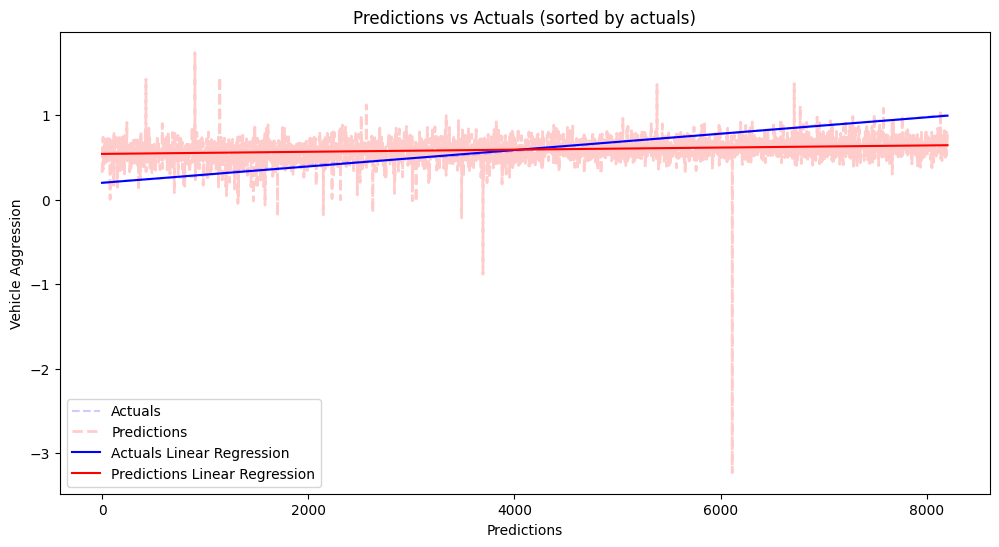

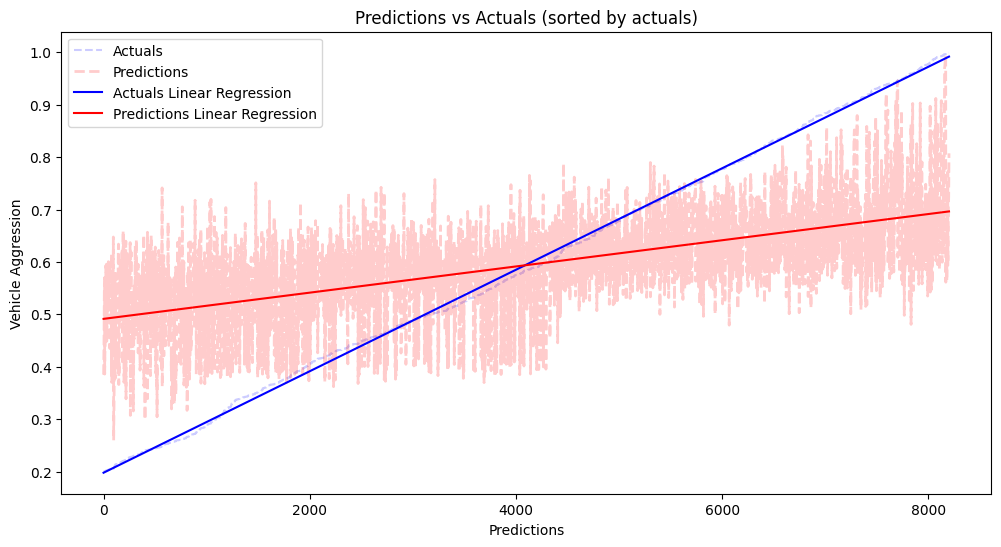

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


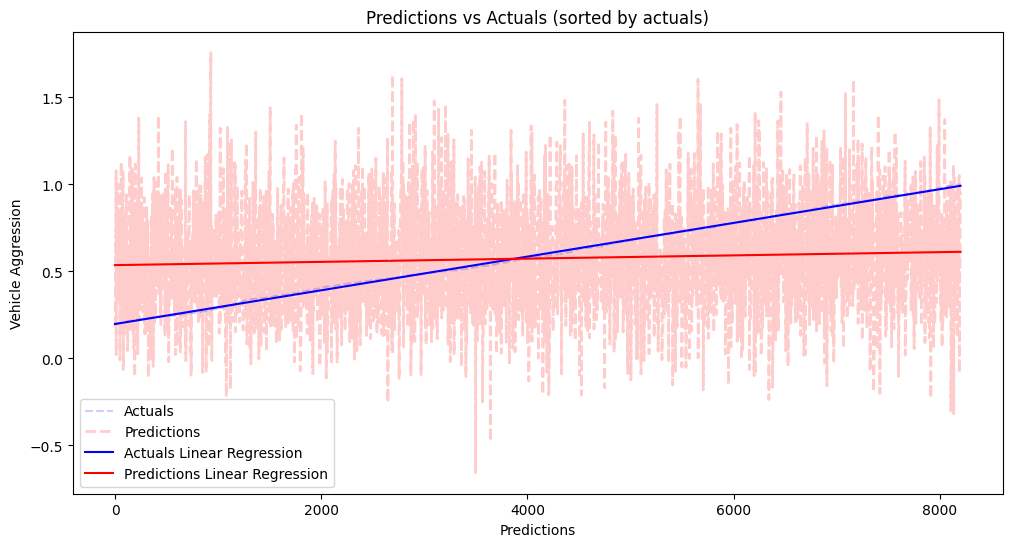

Linear Regression: MSE = 0.0530, R2 = -0.0074
Random Forest: MSE = 0.0337, R2 = 0.3595
Support Vector Regression: MSE = 0.1108, R2 = -1.1055


In [255]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR 
from sklearn.metrics import mean_squared_error, r2_score
import time

# Linear Regression
lr = LinearRegression()
time_start = time.perf_counter()
lr.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_lr = lr.predict(X_test_2d)
plot_evaluation(y_test, y_pred_lr)
add_best_of_model('Linear Regression', y_pred_lr, training_time=time_end-time_start)

# Random Forest
n_estimators = 200
random_state = 42
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
# Start timer
time_start = time.perf_counter()
rf.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_rf = rf.predict(X_test_2d)
plot_evaluation(y_test, y_pred_rf)
add_best_of_model('Random Forest', y_pred_rf, training_time=time_end-time_start, hyperparameters={'n_estimators': n_estimators, 'random_state': random_state})

# Support Vector Regression
max_iter = 10000
svr = LinearSVR(max_iter=max_iter)
time_start = time.perf_counter()
svr.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_svr = svr.predict(X_test_2d)
plot_evaluation(y_test, y_pred_svr)
add_best_of_model('Linear SVR', y_pred_svr, training_time=time_end-time_start, hyperparameters={'max_iter': max_iter})

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Linear Regression: MSE = {:.4f}, R2 = {:.4f}".format(mse_lr, r2_lr))
print("Random Forest: MSE = {:.4f}, R2 = {:.4f}".format(mse_rf, r2_rf))
print("Support Vector Regression: MSE = {:.4f}, R2 = {:.4f}".format(mse_svr, r2_svr))


In [256]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from random import choice

# Prepare the dataset
train_data = lgb.Dataset(X_train_2d, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test_2d, label=y_test, reference=train_data, free_raw_data=False)

def train_and_eval_lgb(
    boosting_type: str = 'gbdt',
    early_stopping_rounds: int = 50,
    num_boost_round: int = 2000,
    learning_rate: float = None):
    # Set up the model parameters
    params = {
        'boosting_type': boosting_type,
        'objective': 'regression',
        'metric': 'mse',
        'device_type': 'gpu',
        'n_jobs': -1,
        'early_stopping_rounds': early_stopping_rounds,
        'num_boost_round': num_boost_round,
    }
    if learning_rate is not None:
        params['learning_rate'] = learning_rate
    
    evals_result = {}

    # Train the model
    callback = lgb.record_evaluation(evals_result)
    time_start = time.perf_counter()
    gbm = lgb.train(params, train_data, valid_sets=test_data, callbacks=[callback])
    time_end = time.perf_counter()
    duration = time_end - time_start

    # Make predictions
    y_pred_lgb = gbm.predict(X_test_2d)

    return evals_result, y_pred_lgb, duration, params

results = {}
for boosting_type in ['gbdt', 'dart', 'goss']:
    results[boosting_type] = train_and_eval_lgb(boosting_type)

for type, result in results.items():
    mse_lgb = mean_squared_error(y_test, result[1])
    mae_lgb = mean_absolute_error(y_test, result[1])
    r2_lgb = r2_score(y_test, result[1])
    print("LightGBM {} Regression: MSE = {:.4f}, R2 = {:.4f}, MAE = {:.4f}".format(type, mse_lgb, r2_lgb, mae_lgb))

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 637245
[LightGBM] [Info] Number of data points in the train set: 32806, number of used features: 2499
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (78.22 MB) transferred to GPU in 0.055522 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.593150
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 637245
[LightGBM] [Info] Number of data points in the train set: 32806, number of used features: 2499
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entr

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 637245
[LightGBM] [Info] Number of data points in the train set: 32806, number of used features: 2499
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (78.22 MB) transferred to GPU in 0.055631 secs. 0 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.593150
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (23.41 MB) transferred to GPU in 0.047718 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (23.41 MB) transferred to GPU in 0.047522 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[Ligh

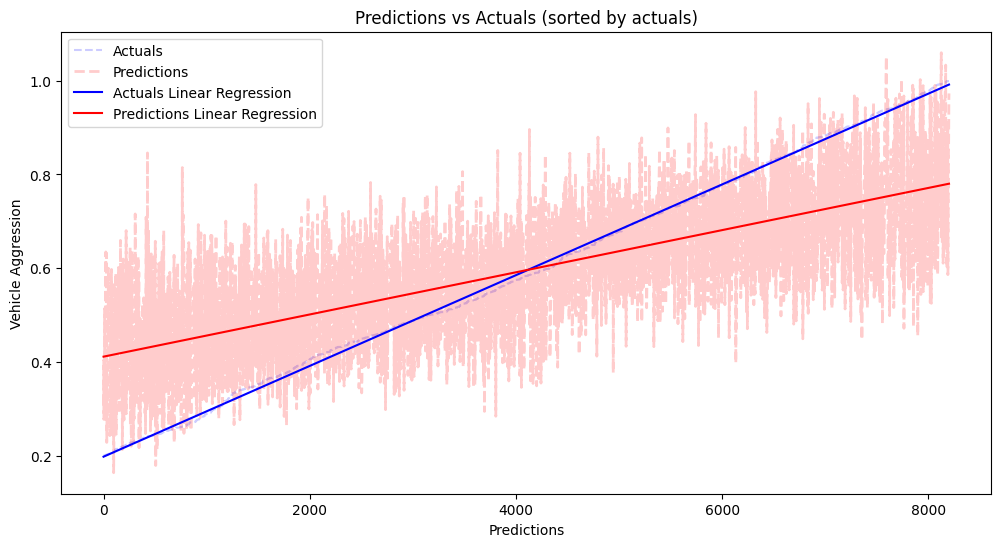

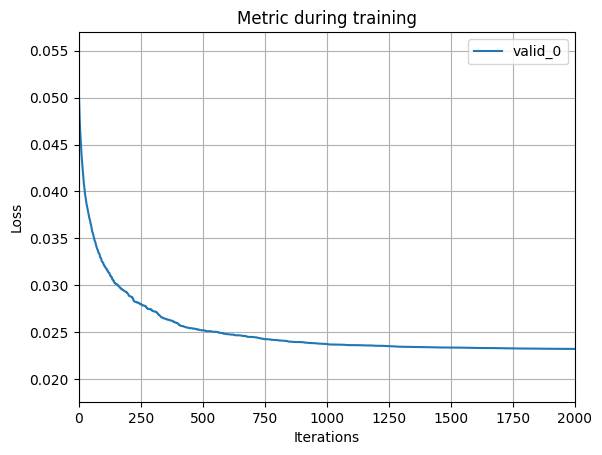

In [257]:
# Select best model
best_result = min(results.items(), key=lambda x: calculate_loss(y_test, x[1][1]))
# Plot the best model
plot_evaluation(y_test, best_result[1][1])
lgb.plot_metric(best_result[1][0], xlabel='Iterations', ylabel='Loss')
best_lgb_predictions = best_result[1][1]
best_booster_type = best_result[0]
loss_at_epoch = best_result[1][0]['valid_0']['l2']
train_duration = best_result[1][2]
params = best_result[1][3]
add_best_of_model(f'LightGBM {best_booster_type}', best_lgb_predictions, loss_at_epoch, train_duration, params)

In [258]:
import torch.nn as nn

class CNNRegressor(nn.Module):
    def __init__(self, n_features, seq_length, n_outputs, n_filters=32, kernel_size=3, pool_size=2, dropout_rate=0.5, hidden_layers=64):
        super(CNNRegressor, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(n_features, n_filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size),
            nn.Conv1d(n_filters, n_filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(n_filters * ((seq_length - 2*kernel_size)//pool_size**2), hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, n_outputs)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # swap time and feature dimensions
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [292]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, dropout_prob):
        super(RNNRegressor, self).__init__()

        self.n_layers = n_layers
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.hidden_size, self.n_layers, 1).to(device)

In [260]:
import math

# Define the Dense Layer (Bottleneck layer)
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv1 = nn.Conv1d(in_channels, 4*growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(4*growth_rate)
        self.conv2 = nn.Conv1d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # print(f'Before x.shape: {x.shape}')
        out = self.conv1(torch.relu(self.bn1(x)))
        # print(f'Conv1 out.shape: {out.shape}')
        out = self.conv2(torch.relu(self.bn2(out)))
        # print(f'Conv2 out.shape: {out.shape}')
        out = torch.cat([out,x], 1)
        # print(f'Final out.shape: {out.shape}')
        return out

# Define the Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([DenseLayer(in_channels + i*growth_rate, growth_rate) for i in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            # print(f'Before x.shape: {x.shape}')
            x = layer(x)
            # print(f'After x.shape: {x.shape}')
        return x

# Define the Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm1d(in_channels)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        return self.avg_pool(out)

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_init_features=64, output_size=1):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv1d(X_train.shape[1], num_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.dense_blocks = nn.ModuleList()
        self.trans_layers = nn.ModuleList()

        for i in range(len(nblocks)):
            self.dense_blocks.append(self._make_dense_layers(block, num_planes, nblocks[i]))
            num_planes += nblocks[i]*growth_rate
            if i != len(nblocks) - 1:
                out_planes = int(math.floor(num_planes*reduction))
                self.trans_layers.append(TransitionLayer(num_planes, out_planes))
                num_planes = out_planes

        self.bn = nn.BatchNorm1d(num_planes).to(device)
        self.linear = nn.Linear(num_planes, output_size).to(device)

    def _make_dense_layers(self, block, in_planes, nblock):
        return nn.Sequential(*block(in_planes, self.growth_rate, n_layers=nblock).layers)

    def forward(self, x):
        # print(f'Input: {x.shape}')
        out = self.conv1(x)
        for i, (dense_block, trans_layer) in enumerate(zip(self.dense_blocks, self.trans_layers)):
            # print(f'Before dense_blocks[{i}]: {out.shape}')
            out = dense_block(out)
            # print(f'After dense_blocks[{i}]: {out.shape}')
            out = trans_layer(out)
            # print(f'After trans_layers[{i}]: {out.shape}')
        out = self.dense_blocks[-1](out)
        # print(f'After dense_blocks[-1]: {out.shape}')
        out = torch.relu(self.bn(out))
        out = nn.functional.adaptive_avg_pool1d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [282]:
import optuna
import random
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

def train(
    net: nn.Module, 
    criterion, 
    optimizer: optim.Optimizer,
    num_epochs: int, 
    train_loader: DataLoader, 
    device: str, 
    trial: optuna.Trial, 
    early_stopping_rounds: int = -1):
    net.train()
    loss_at_epoch = []
    best_loss = float('inf')
    start_time = time.perf_counter()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        trial.report(epoch_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        loss_at_epoch.append(epoch_loss)
        
        # Early stopping check
        epsilon = 1e-3
        if epoch_loss + epsilon < best_loss:
            print(f'Epoch {epoch} loss improved from {best_loss:.4f} to {epoch_loss:.4f}!')
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'Epoch {epoch} loss did not improve from {best_loss:.4f}! Remaining epochs: {early_stopping_rounds - epochs_no_improve}')
            if epochs_no_improve == early_stopping_rounds:
                print('Early stopping!')
                end_time = time.perf_counter()
                plot_train(loss_at_epoch)
                return net, loss_at_epoch, end_time - start_time

    end_time = time.perf_counter()
    # Plot the loss at each epoch
    plot_train(loss_at_epoch)
    return net, loss_at_epoch, end_time - start_time

def evaluate(net: nn.Module, criterion, test_loader: DataLoader, device: str):
    net.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        test_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = net(inputs)

            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            
    plot_evaluation(actuals, predictions)

    return predictions, actuals, test_loss/len(test_loader)

In [262]:
def train_and_eval_dnn(trial: optuna.Trial):
    growth_rate = trial.suggest_int('growth_rate', 4, 12)
    reduction = trial.suggest_float('reduction', 0.5, 0.9)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    nblocks = [trial.suggest_int('nblocks1', 4, 8),
               trial.suggest_int('nblocks2', 8, 16),]
            #    trial.suggest_int('nblocks3', 16, 32),]

    net = DenseNet(DenseBlock, nblocks, growth_rate=growth_rate, reduction=reduction, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    num_epochs = 40

    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=10)
    predictions, actuals, test_loss = evaluate(net, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

In [283]:
def train_and_eval_rnn(trial: optuna.Trial):
    # Hyperparameters
    input_size = X_train.shape[2]
    output_size = 1
    sequence_length = X_train.shape[1]
    
    num_layers = trial.suggest_int('growth_rate', 16, 128, step=8)
    hidden_size = trial.suggest_int('growth_rate', 12, 48, step=4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.5, step=0.05)
    
    print(f'X_train.shape: {X_train.shape}')
    
    model = RNNRegressor(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 40

    model, loss_at_epoch, duration = train_rnn(model, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=5)
    predictions, actuals, test_loss = evaluate(model, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

In [264]:
def train_and_eval_cnn(trial: optuna.Trial): # Suggest hyperparameters using the trial object
    num_filters = trial.suggest_int("num_filters", 64, 512, step=32)
    kernel_size = trial.suggest_int("kernel_size", 3, 3)
    pool_size = trial.suggest_int("pool_size", 2, 2)
    hidden_layers = trial.suggest_int("hidden_layers", 24, 92, step=8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.05)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    # num_filters = 437
    # kernel_size = 4
    # pool_size = 4
    # hidden_units = 73
    # dropout_rate = 0.1657660256105821
    # learning_rate = 3.964884325777312e-05
    
    print(f'X_train.shape: {X_train.shape}')
    input_channels = X_train.shape[2]
    sequence_length = X_train.shape[1]
    n_outputs = 1
    net = CNNRegressor(input_channels, sequence_length, n_outputs, num_filters, kernel_size, pool_size, dropout_rate, hidden_layers).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    num_epochs = 200

    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=10)
    predictions, actuals, test_loss = evaluate(net, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

## Hyperparameter optimization via Optuna

In [284]:
def optimize_model(model_name: str, train_and_eval_func, n_trials: int):
    study = optuna.create_study(
        study_name=f'{model_name} Optimization',
        direction="minimize", 
        sampler=optuna.samplers.TPESampler(seed=42), 
        pruner=optuna.pruners.PercentilePruner(percentile=25, n_warmup_steps=20)
        )
    study.optimize(train_and_eval_func, n_trials=n_trials)
    
    # Get the best 5 trials
    completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
    best_trials = sorted(completed_trials, key=lambda t: t.value)[:5]

    # Print the best 5 trials' parameters and their respective values
    for i, trial in enumerate(best_trials):
        print(f"Best trial {i + 1}:")
        print(f"\tValue: {trial.value}")
        print(f"\tParams: {trial.params}")
        
    # Get the best trial
    best_trial = study.best_trial
    # Add best trial to the best of models
    add_best_of_model(
        model_name, 
        best_trial.user_attrs['predictions'],
        best_trial.user_attrs['loss_at_epoch'],
        best_trial.user_attrs['duration'],
        best_trial.params)

In [293]:
n_trials = 100
optimize_model('RNN', train_and_eval_rnn, n_trials)

[I 2023-05-21 09:36:35,431] A new study created in memory with name: RNN Optimization
c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "growth_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 8, 'low': 16, 'high': 128}
  warnings.warn(
[W 2023-05-21 09:36:35,437] Trial 0 failed with parameters: {'growth_rate': 56, 'learning_rate': 0.007969454818643935, 'dropout_prob': 0.4} because of the following error: RuntimeError('Sizes of tensors must match except in dimension 1. Expected size 128 but got size 56 for tensor number 1 in the list.').
Traceback (most recent call last):
  File "c:\Users\illya\AppData\Local\Programs\Pytho

X_train.shape: (32806, 100, 25)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 56 for tensor number 1 in the list.

[I 2023-05-21 01:32:25,981] A new study created in memory with name: no-name-2cb50e99-92f1-4394-b106-fcc45494513b
c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [24, 92] and step=8, but the range is not divisible by `step`. It will be replaced by [24, 88].
  warnings.warn(


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1702.9955!
Epoch 1 loss improved from 1702.9955 to 0.1470!
Epoch 2 loss improved from 0.1470 to 0.0606!
Epoch 3 loss improved from 0.0606 to 0.0521!
Epoch 4 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 5 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 6 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


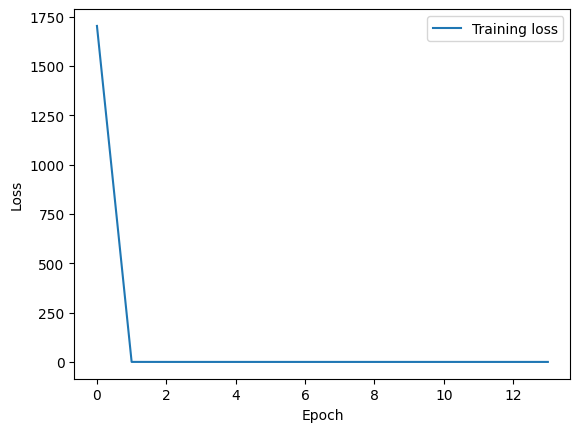

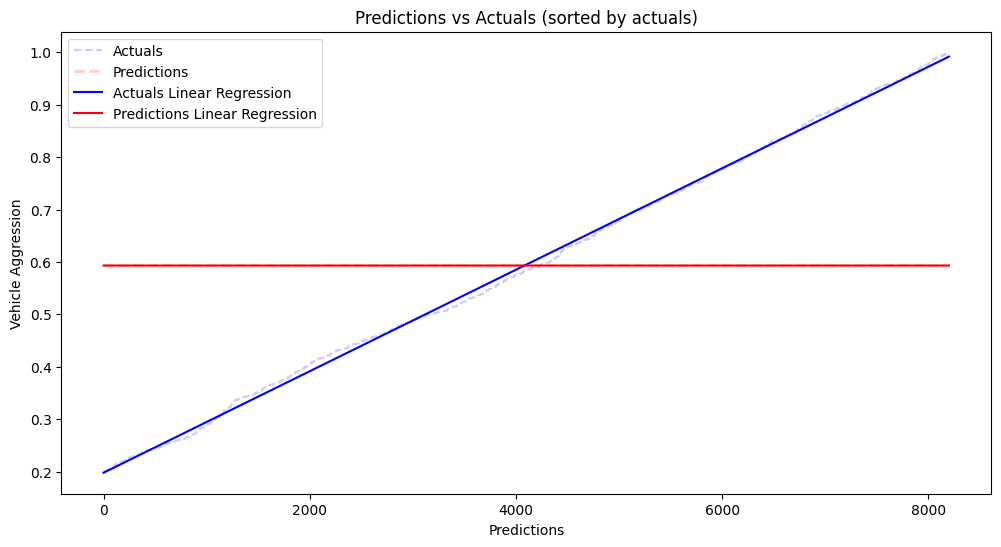

[I 2023-05-21 01:32:33,832] Trial 0 finished with value: 0.052869955049111295 and parameters: {'num_filters': 224, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 88, 'dropout_rate': 0.25, 'learning_rate': 0.0015751320499779737}. Best is trial 0 with value: 0.052869955049111295.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 503.6815!
Epoch 1 loss improved from 503.6815 to 0.4063!
Epoch 2 loss improved from 0.4063 to 0.3375!
Epoch 3 loss improved from 0.3375 to 0.2665!
Epoch 4 loss improved from 0.2665 to 0.2024!
Epoch 5 loss improved from 0.2024 to 0.1497!
Epoch 6 loss improved from 0.1497 to 0.1108!
Epoch 7 loss improved from 0.1108 to 0.0843!
Epoch 8 loss improved from 0.0843 to 0.0681!
Epoch 9 loss improved from 0.0681 to 0.0592!
Epoch 10 loss improved from 0.0592 to 0.0549!
Epoch 11 loss improved from 0.0549 to 0.0530!
Epoch 12 loss did not improve from 0.0530! Remaining epochs: 9
Epoch 13 loss did not improve from 0.0530! Remaining epochs: 8
Epoch 14 loss did not improve from 0.0530! Remaining epochs: 7
Epoch 15 loss did not improve from 0.0530! Remaining epochs: 6
Epoch 16 loss did not improve from 0.0530! Remaining epochs: 5
Epoch 17 loss did not improve from 0.0530! Remaining epochs: 4
Epoch 18 loss did not improve from 0.0530! Rema

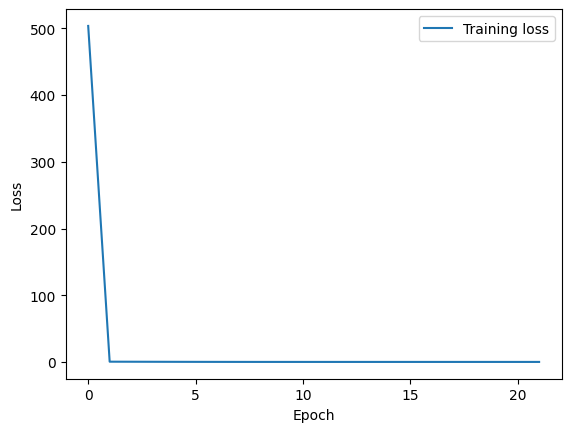

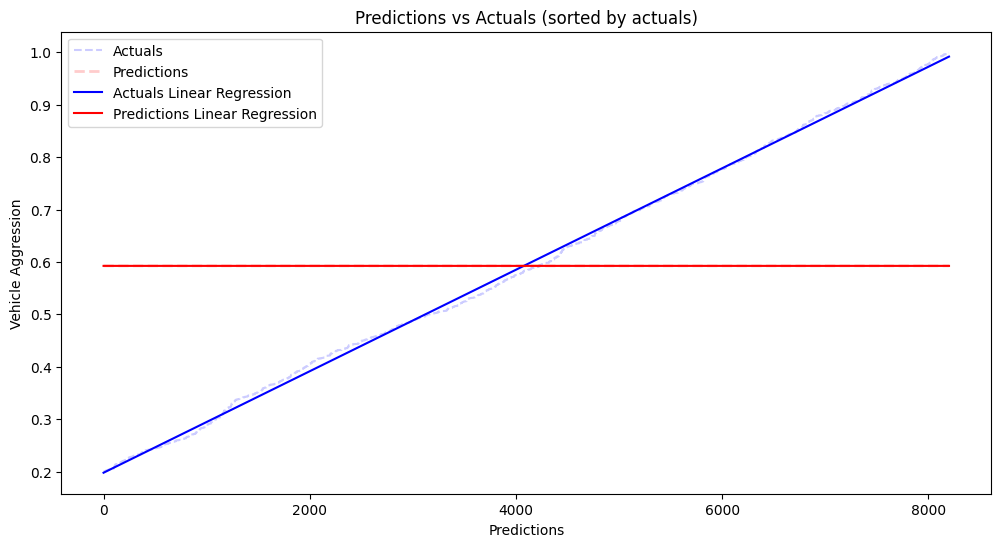

[I 2023-05-21 01:32:46,002] Trial 1 finished with value: 0.05287432498656786 and parameters: {'num_filters': 128, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 32, 'dropout_rate': 0.1, 'learning_rate': 0.005399484409787433}. Best is trial 0 with value: 0.052869955049111295.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1924848.8707!
Epoch 1 loss improved from 1924848.8707 to 260.4488!
Epoch 2 loss improved from 260.4488 to 40.3406!
Epoch 3 loss improved from 40.3406 to 14.0134!
Epoch 4 loss improved from 14.0134 to 7.3861!
Epoch 5 loss improved from 7.3861 to 4.4655!
Epoch 6 loss improved from 4.4655 to 2.7811!
Epoch 7 loss did not improve from 2.7811! Remaining epochs: 9
Epoch 8 loss did not improve from 2.7811! Remaining epochs: 8
Epoch 9 loss did not improve from 2.7811! Remaining epochs: 7
Epoch 10 loss improved from 2.7811 to 2.6010!
Epoch 11 loss did not improve from 2.6010! Remaining epochs: 9
Epoch 12 loss improved from 2.6010 to 1.6676!
Epoch 13 loss improved from 1.6676 to 1.4441!
Epoch 14 loss did not improve from 1.4441! Remaining epochs: 9
Epoch 15 loss improved from 1.4441 to 0.7636!
Epoch 16 loss improved from 0.7636 to 0.6951!
Epoch 17 loss did not improve from 0.6951! Remaining epochs: 9
Epoch 18 loss improved from 0.6

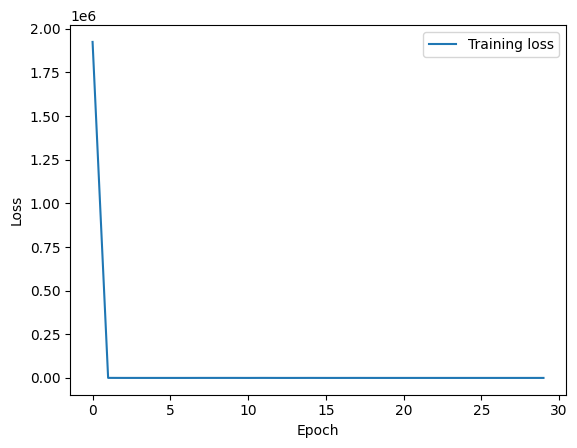

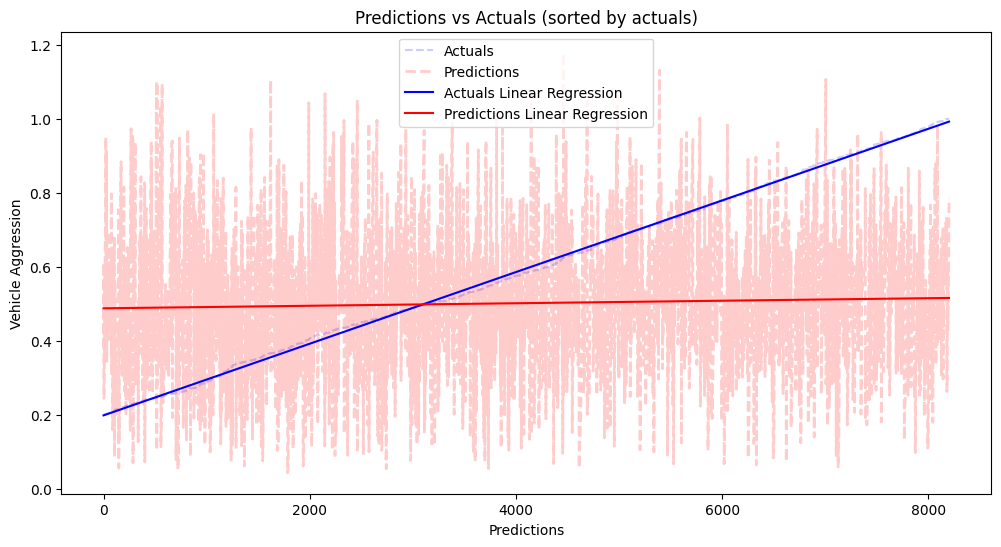

[I 2023-05-21 01:33:04,923] Trial 2 finished with value: 0.08924901760541476 and parameters: {'num_filters': 352, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 72, 'dropout_rate': 0.1, 'learning_rate': 0.008706020878304856}. Best is trial 0 with value: 0.052869955049111295.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 40.9124!
Epoch 1 loss improved from 40.9124 to 0.2419!
Epoch 2 loss improved from 0.2419 to 0.2360!
Epoch 3 loss improved from 0.2360 to 0.2287!
Epoch 4 loss improved from 0.2287 to 0.2199!
Epoch 5 loss improved from 0.2199 to 0.2099!
Epoch 6 loss improved from 0.2099 to 0.1989!
Epoch 7 loss improved from 0.1989 to 0.1870!
Epoch 8 loss improved from 0.1870 to 0.1749!
Epoch 9 loss improved from 0.1749 to 0.1621!
Epoch 10 loss improved from 0.1621 to 0.1494!
Epoch 11 loss improved from 0.1494 to 0.1366!
Epoch 12 loss improved from 0.1366 to 0.1242!
Epoch 13 loss improved from 0.1242 to 0.1126!
Epoch 14 loss improved from 0.1126 to 0.1018!
Epoch 15 loss improved from 0.1018 to 0.0918!
Epoch 16 loss improved from 0.0918 to 0.0830!
Epoch 17 loss improved from 0.0830 to 0.0755!
Epoch 18 loss improved from 0.0755 to 0.0692!
Epoch 19 loss improved from 0.0692 to 0.0642!
Epoch 20 loss improved from 0.0642 to 0.0603!
Epoch 21 loss

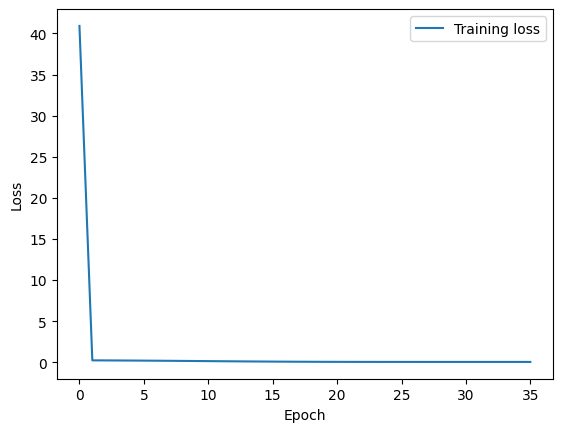

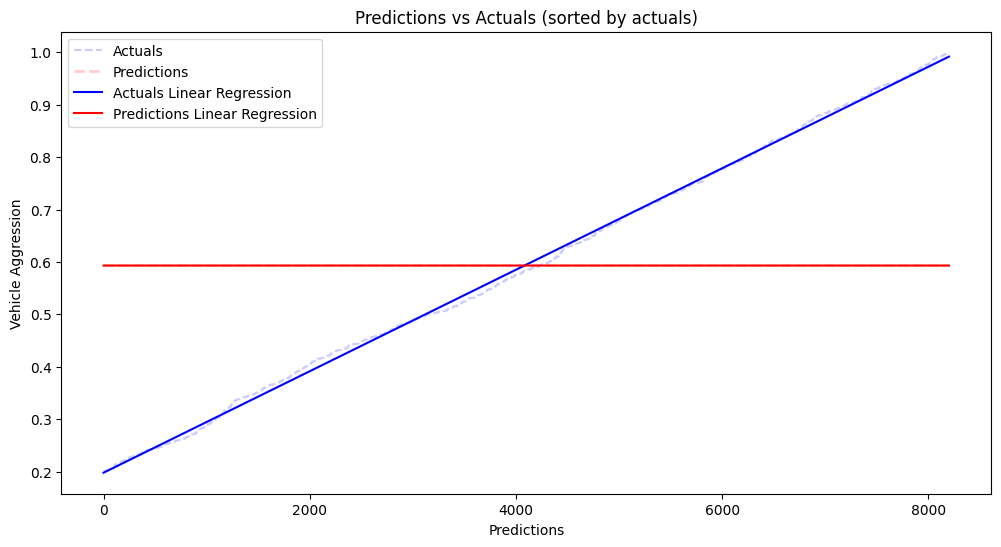

[I 2023-05-21 01:33:26,775] Trial 3 finished with value: 0.05287000582768367 and parameters: {'num_filters': 448, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 32, 'dropout_rate': 0.1, 'learning_rate': 0.00023270677083837802}. Best is trial 0 with value: 0.052869955049111295.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 23.1441!
Epoch 1 loss improved from 23.1441 to 0.2141!
Epoch 2 loss improved from 0.2141 to 0.1790!
Epoch 3 loss improved from 0.1790 to 0.1420!
Epoch 4 loss improved from 0.1420 to 0.1110!
Epoch 5 loss improved from 0.1110 to 0.0881!
Epoch 6 loss improved from 0.0881 to 0.0745!
Epoch 7 loss improved from 0.0745 to 0.0638!
Epoch 8 loss improved from 0.0638 to 0.0584!
Epoch 9 loss improved from 0.0584 to 0.0553!
Epoch 10 loss improved from 0.0553 to 0.0533!
Epoch 11 loss improved from 0.0533 to 0.0510!
Epoch 12 loss did not improve from 0.0510! Remaining epochs: 9
Epoch 13 loss improved from 0.0510 to 0.0490!
Epoch 14 loss did not improve from 0.0490! Remaining epochs: 9
Epoch 15 loss improved from 0.0490 to 0.0476!
Epoch 16 loss did not improve from 0.0476! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0476! Remaining epochs: 8
Epoch 18 loss improved from 0.0476 to 0.0463!
Epoch 19 loss did not improve from 0.

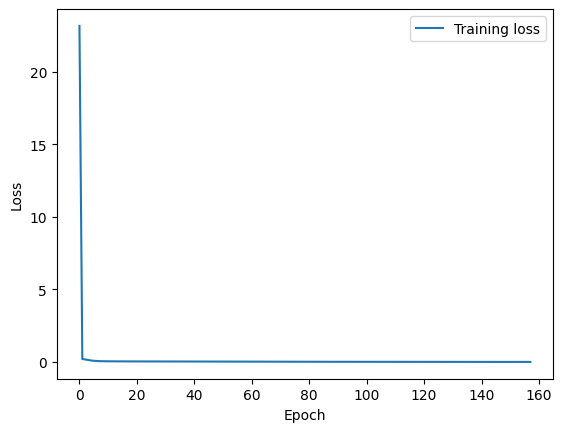

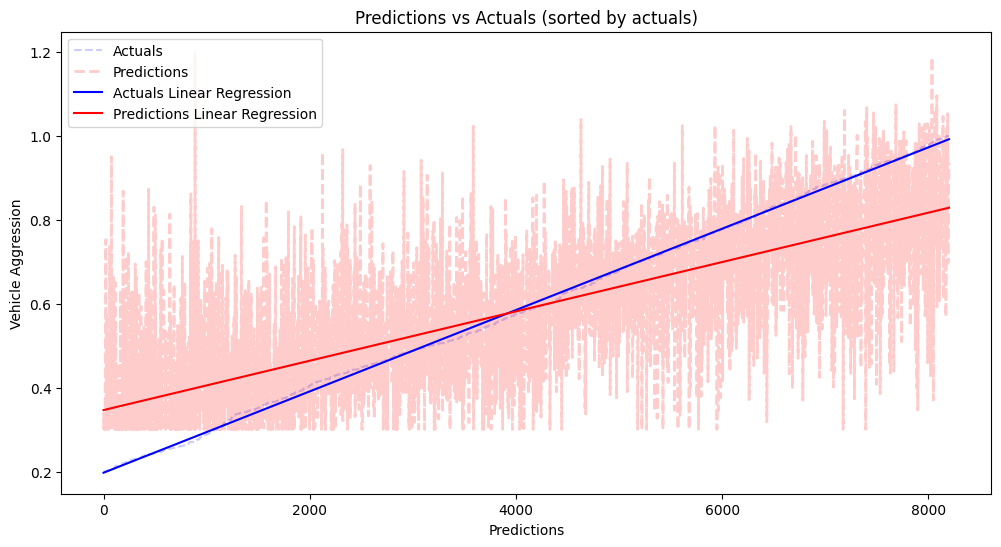

[I 2023-05-21 01:34:51,166] Trial 4 finished with value: 0.020357208269146772 and parameters: {'num_filters': 192, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 56, 'dropout_rate': 0.2, 'learning_rate': 0.0003823475224675188}. Best is trial 4 with value: 0.020357208269146772.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 12.5404!
Epoch 1 loss improved from 12.5404 to 0.3657!
Epoch 2 loss improved from 0.3657 to 0.3205!
Epoch 3 loss improved from 0.3205 to 0.2716!
Epoch 4 loss improved from 0.2716 to 0.2244!
Epoch 5 loss improved from 0.2244 to 0.1820!
Epoch 6 loss improved from 0.1820 to 0.1457!
Epoch 7 loss improved from 0.1457 to 0.1163!
Epoch 8 loss improved from 0.1163 to 0.0940!
Epoch 9 loss improved from 0.0940 to 0.0778!
Epoch 10 loss improved from 0.0778 to 0.0668!
Epoch 11 loss improved from 0.0668 to 0.0599!
Epoch 12 loss improved from 0.0599 to 0.0559!
Epoch 13 loss improved from 0.0559 to 0.0537!
Epoch 14 loss improved from 0.0537 to 0.0527!
Epoch 15 loss did not improve from 0.0527! Remaining epochs: 9
Epoch 16 loss did not improve from 0.0527! Remaining epochs: 8
Epoch 17 loss did not improve from 0.0527! Remaining epochs: 7
Epoch 18 loss did not improve from 0.0527! Remaining epochs: 6
Epoch 19 loss did not improve from 0.

[I 2023-05-21 01:35:03,968] Trial 5 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 147.8963!
Epoch 1 loss improved from 147.8963 to 0.8533!
Epoch 2 loss improved from 0.8533 to 0.3732!
Epoch 3 loss improved from 0.3732 to 0.1886!
Epoch 4 loss improved from 0.1886 to 0.1132!
Epoch 5 loss improved from 0.1132 to 0.0846!
Epoch 6 loss improved from 0.0846 to 0.0756!
Epoch 7 loss did not improve from 0.0756! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0756! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0756! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0756! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0756! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0756! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0756! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0756! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0756! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0756! Remaining epochs: 0
Early stopping!


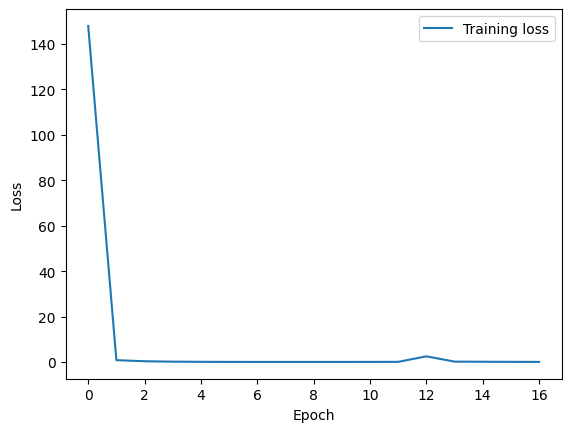

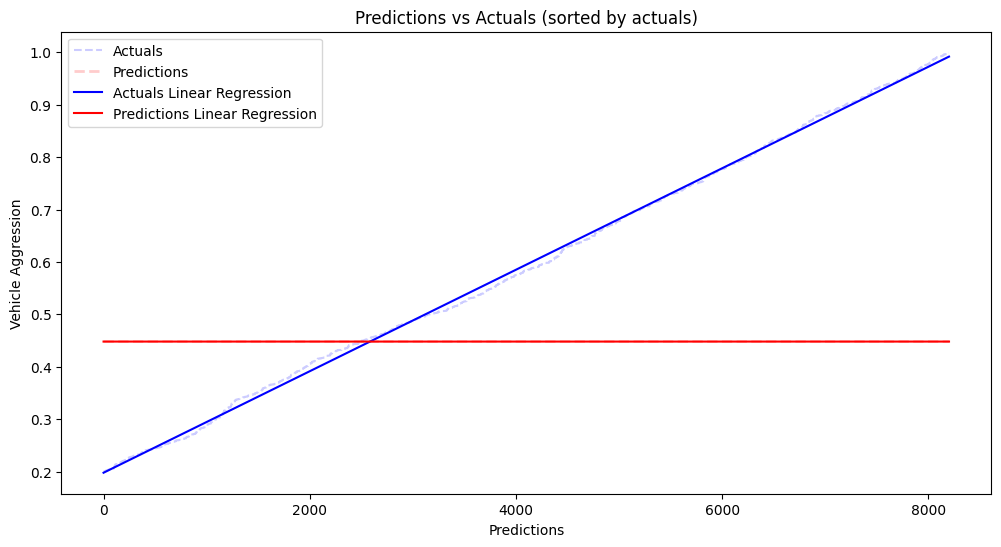

[I 2023-05-21 01:35:13,403] Trial 6 finished with value: 0.07478970805039772 and parameters: {'num_filters': 256, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 80, 'dropout_rate': 0.1, 'learning_rate': 0.0010677482709481358}. Best is trial 4 with value: 0.020357208269146772.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 15.1181!
Epoch 1 loss improved from 15.1181 to 0.6097!
Epoch 2 loss improved from 0.6097 to 0.5831!
Epoch 3 loss improved from 0.5831 to 0.5508!
Epoch 4 loss improved from 0.5508 to 0.5148!
Epoch 5 loss improved from 0.5148 to 0.4772!
Epoch 6 loss improved from 0.4772 to 0.4376!
Epoch 7 loss improved from 0.4376 to 0.3980!
Epoch 8 loss improved from 0.3980 to 0.3594!
Epoch 9 loss improved from 0.3594 to 0.3215!
Epoch 10 loss improved from 0.3215 to 0.2856!
Epoch 11 loss improved from 0.2856 to 0.2521!
Epoch 12 loss improved from 0.2521 to 0.2213!
Epoch 13 loss improved from 0.2213 to 0.1931!
Epoch 14 loss improved from 0.1931 to 0.1678!
Epoch 15 loss improved from 0.1678 to 0.1456!
Epoch 16 loss improved from 0.1456 to 0.1263!
Epoch 17 loss improved from 0.1263 to 0.1096!
Epoch 18 loss improved from 0.1096 to 0.0957!
Epoch 19 loss improved from 0.0957 to 0.0843!


[I 2023-05-21 01:35:24,942] Trial 7 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 373.0579!
Epoch 1 loss improved from 373.0579 to 0.0776!
Epoch 2 loss improved from 0.0776 to 0.0629!
Epoch 3 loss improved from 0.0629 to 0.0599!
Epoch 4 loss improved from 0.0599 to 0.0587!
Epoch 5 loss did not improve from 0.0587! Remaining epochs: 9
Epoch 6 loss did not improve from 0.0587! Remaining epochs: 8
Epoch 7 loss did not improve from 0.0587! Remaining epochs: 7
Epoch 8 loss did not improve from 0.0587! Remaining epochs: 6
Epoch 9 loss improved from 0.0587 to 0.0573!
Epoch 10 loss did not improve from 0.0573! Remaining epochs: 9
Epoch 11 loss did not improve from 0.0573! Remaining epochs: 8
Epoch 12 loss did not improve from 0.0573! Remaining epochs: 7
Epoch 13 loss did not improve from 0.0573! Remaining epochs: 6
Epoch 14 loss did not improve from 0.0573! Remaining epochs: 5
Epoch 15 loss did not improve from 0.0573! Remaining epochs: 4
Epoch 16 loss did not improve from 0.0573! Remaining epochs: 3
Epoch 17

[I 2023-05-21 01:35:35,869] Trial 8 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 59.1830!
Epoch 1 loss improved from 59.1830 to 0.5089!
Epoch 2 loss improved from 0.5089 to 0.4721!
Epoch 3 loss improved from 0.4721 to 0.4273!
Epoch 4 loss improved from 0.4273 to 0.3792!
Epoch 5 loss improved from 0.3792 to 0.3297!
Epoch 6 loss improved from 0.3297 to 0.2807!
Epoch 7 loss improved from 0.2807 to 0.2347!
Epoch 8 loss improved from 0.2347 to 0.1932!
Epoch 9 loss improved from 0.1932 to 0.1571!
Epoch 10 loss improved from 0.1571 to 0.1269!
Epoch 11 loss improved from 0.1269 to 0.1030!
Epoch 12 loss improved from 0.1030 to 0.0850!
Epoch 13 loss improved from 0.0850 to 0.0720!
Epoch 14 loss improved from 0.0720 to 0.0634!
Epoch 15 loss improved from 0.0634 to 0.0580!
Epoch 16 loss improved from 0.0580 to 0.0550!
Epoch 17 loss improved from 0.0550 to 0.0533!
Epoch 18 loss did not improve from 0.0533! Remaining epochs: 9
Epoch 19 loss improved from 0.0533 to 0.0522!


[I 2023-05-21 01:35:47,162] Trial 9 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 35.8275!
Epoch 1 loss improved from 35.8275 to 0.1010!
Epoch 2 loss improved from 0.1010 to 0.0922!
Epoch 3 loss improved from 0.0922 to 0.0861!
Epoch 4 loss improved from 0.0861 to 0.0809!
Epoch 5 loss improved from 0.0809 to 0.0766!
Epoch 6 loss improved from 0.0766 to 0.0727!
Epoch 7 loss improved from 0.0727 to 0.0691!
Epoch 8 loss improved from 0.0691 to 0.0647!
Epoch 9 loss improved from 0.0647 to 0.0631!
Epoch 10 loss improved from 0.0631 to 0.0609!
Epoch 11 loss improved from 0.0609 to 0.0578!
Epoch 12 loss improved from 0.0578 to 0.0560!
Epoch 13 loss improved from 0.0560 to 0.0546!
Epoch 14 loss improved from 0.0546 to 0.0531!
Epoch 15 loss improved from 0.0531 to 0.0515!
Epoch 16 loss improved from 0.0515 to 0.0502!
Epoch 17 loss did not improve from 0.0502! Remaining epochs: 9
Epoch 18 loss improved from 0.0502 to 0.0486!
Epoch 19 loss did not improve from 0.0486! Remaining epochs: 9
Epoch 20 loss improved fr

[I 2023-05-21 01:36:11,246] Trial 10 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1266.1467!
Epoch 1 loss improved from 1266.1467 to 0.0866!
Epoch 2 loss improved from 0.0866 to 0.0523!
Epoch 3 loss did not improve from 0.0523! Remaining epochs: 9
Epoch 4 loss did not improve from 0.0523! Remaining epochs: 8
Epoch 5 loss did not improve from 0.0523! Remaining epochs: 7
Epoch 6 loss did not improve from 0.0523! Remaining epochs: 6
Epoch 7 loss did not improve from 0.0523! Remaining epochs: 5
Epoch 8 loss did not improve from 0.0523! Remaining epochs: 4
Epoch 9 loss did not improve from 0.0523! Remaining epochs: 3
Epoch 10 loss did not improve from 0.0523! Remaining epochs: 2
Epoch 11 loss did not improve from 0.0523! Remaining epochs: 1
Epoch 12 loss did not improve from 0.0523! Remaining epochs: 0
Early stopping!


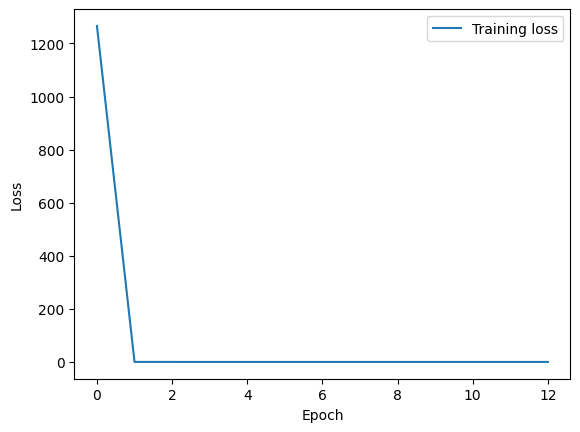

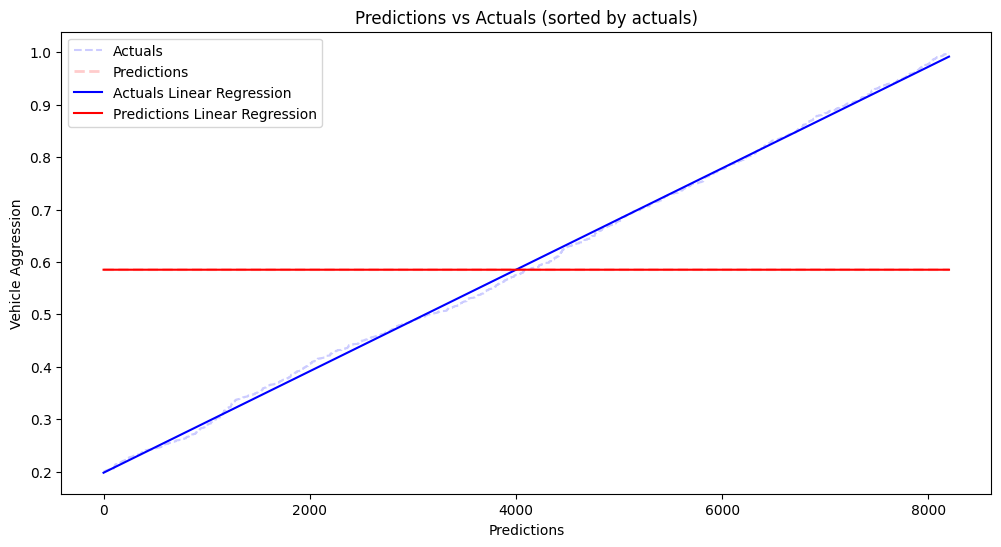

[I 2023-05-21 01:36:18,598] Trial 11 finished with value: 0.05298107828085239 and parameters: {'num_filters': 224, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 56, 'dropout_rate': 0.2, 'learning_rate': 0.0017707899738129214}. Best is trial 4 with value: 0.020357208269146772.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 691.6596!
Epoch 1 loss improved from 691.6596 to 0.0862!
Epoch 2 loss improved from 0.0862 to 0.0763!
Epoch 3 loss improved from 0.0763 to 0.0742!
Epoch 4 loss improved from 0.0742 to 0.0702!
Epoch 5 loss improved from 0.0702 to 0.0692!
Epoch 6 loss improved from 0.0692 to 0.0665!
Epoch 7 loss improved from 0.0665 to 0.0632!
Epoch 8 loss improved from 0.0632 to 0.0612!
Epoch 9 loss did not improve from 0.0612! Remaining epochs: 9
Epoch 10 loss improved from 0.0612 to 0.0593!
Epoch 11 loss did not improve from 0.0593! Remaining epochs: 9
Epoch 12 loss did not improve from 0.0593! Remaining epochs: 8
Epoch 13 loss did not improve from 0.0593! Remaining epochs: 7
Epoch 14 loss improved from 0.0593 to 0.0580!
Epoch 15 loss did not improve from 0.0580! Remaining epochs: 9
Epoch 16 loss did not improve from 0.0580! Remaining epochs: 8
Epoch 17 loss did not improve from 0.0580! Remaining epochs: 7
Epoch 18 loss improved from 0.

[I 2023-05-21 01:36:29,951] Trial 12 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 11.5128!
Epoch 1 loss improved from 11.5128 to 0.1537!
Epoch 2 loss improved from 0.1537 to 0.1238!
Epoch 3 loss improved from 0.1238 to 0.1036!
Epoch 4 loss improved from 0.1036 to 0.0903!
Epoch 5 loss improved from 0.0903 to 0.0806!
Epoch 6 loss improved from 0.0806 to 0.0728!
Epoch 7 loss improved from 0.0728 to 0.0672!
Epoch 8 loss improved from 0.0672 to 0.0626!
Epoch 9 loss improved from 0.0626 to 0.0598!
Epoch 10 loss improved from 0.0598 to 0.0568!
Epoch 11 loss improved from 0.0568 to 0.0555!
Epoch 12 loss improved from 0.0555 to 0.0534!
Epoch 13 loss did not improve from 0.0534! Remaining epochs: 9
Epoch 14 loss improved from 0.0534 to 0.0517!
Epoch 15 loss did not improve from 0.0517! Remaining epochs: 9
Epoch 16 loss improved from 0.0517 to 0.0506!
Epoch 17 loss did not improve from 0.0506! Remaining epochs: 9
Epoch 18 loss improved from 0.0506 to 0.0489!
Epoch 19 loss did not improve from 0.0489! Remaining e

[I 2023-05-21 01:36:59,163] Trial 13 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1305.3881!
Epoch 1 loss improved from 1305.3881 to 0.0566!
Epoch 2 loss improved from 0.0566 to 0.0520!
Epoch 3 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 4 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 5 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 6 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 7 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 0
Early stopping!


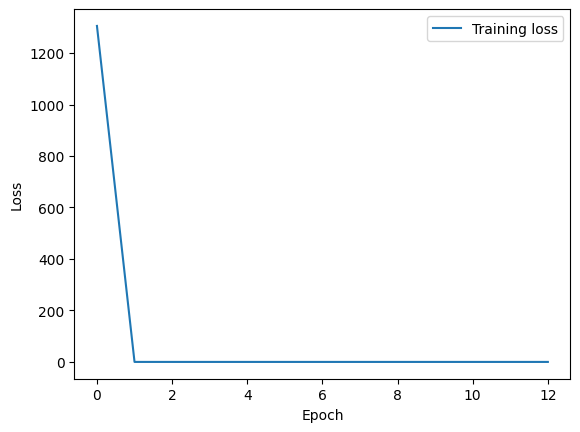

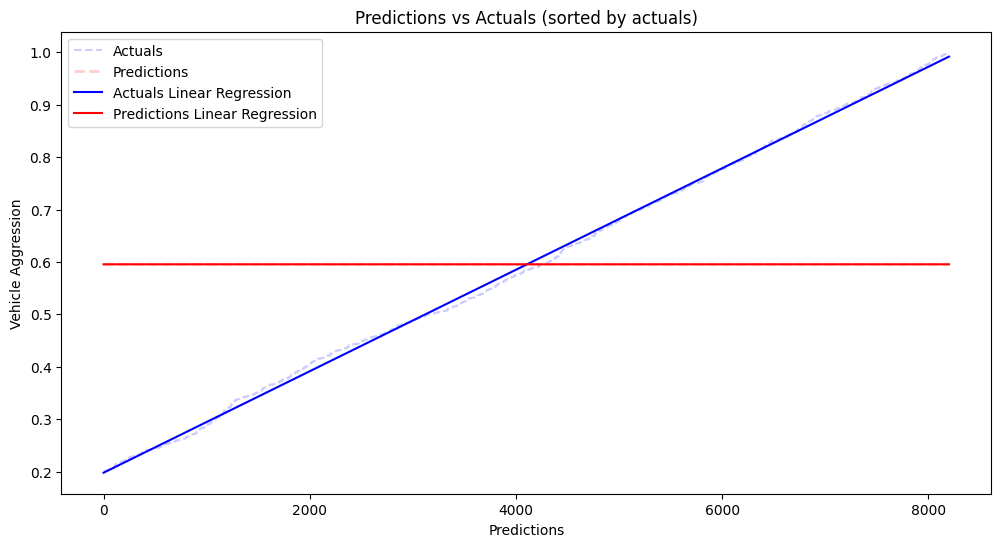

[I 2023-05-21 01:37:06,562] Trial 14 finished with value: 0.05286143101178683 and parameters: {'num_filters': 256, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 48, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.0015436364166977854}. Best is trial 4 with value: 0.020357208269146772.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 3160.7631!
Epoch 1 loss improved from 3160.7631 to 0.2861!
Epoch 2 loss did not improve from 0.2861! Remaining epochs: 9
Epoch 3 loss improved from 0.2861 to 0.2670!
Epoch 4 loss did not improve from 0.2670! Remaining epochs: 9
Epoch 5 loss did not improve from 0.2670! Remaining epochs: 8
Epoch 6 loss improved from 0.2670 to 0.1694!
Epoch 7 loss did not improve from 0.1694! Remaining epochs: 9
Epoch 8 loss did not improve from 0.1694! Remaining epochs: 8
Epoch 9 loss did not improve from 0.1694! Remaining epochs: 7
Epoch 10 loss did not improve from 0.1694! Remaining epochs: 6
Epoch 11 loss did not improve from 0.1694! Remaining epochs: 5
Epoch 12 loss improved from 0.1694 to 0.1240!
Epoch 13 loss did not improve from 0.1240! Remaining epochs: 9
Epoch 14 loss improved from 0.1240 to 0.1154!
Epoch 15 loss improved from 0.1154 to 0.1127!
Epoch 16 loss improved from 0.1127 to 0.1020!
Epoch 17 loss improved from 0.1020 to 0.

[I 2023-05-21 01:37:18,146] Trial 15 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 167.5307!
Epoch 1 loss improved from 167.5307 to 0.2747!
Epoch 2 loss improved from 0.2747 to 0.2598!
Epoch 3 loss improved from 0.2598 to 0.2414!
Epoch 4 loss improved from 0.2414 to 0.2209!
Epoch 5 loss improved from 0.2209 to 0.1994!
Epoch 6 loss improved from 0.1994 to 0.1773!
Epoch 7 loss improved from 0.1773 to 0.1555!
Epoch 8 loss improved from 0.1555 to 0.1351!
Epoch 9 loss improved from 0.1351 to 0.1165!
Epoch 10 loss improved from 0.1165 to 0.1001!
Epoch 11 loss improved from 0.1001 to 0.0864!
Epoch 12 loss improved from 0.0864 to 0.0754!
Epoch 13 loss improved from 0.0754 to 0.0672!
Epoch 14 loss improved from 0.0672 to 0.0612!
Epoch 15 loss improved from 0.0612 to 0.0573!
Epoch 16 loss improved from 0.0573 to 0.0547!
Epoch 17 loss improved from 0.0547 to 0.0533!
Epoch 18 loss did not improve from 0.0533! Remaining epochs: 9
Epoch 19 loss improved from 0.0533 to 0.0522!


[I 2023-05-21 01:37:31,022] Trial 16 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 12.6032!
Epoch 1 loss improved from 12.6032 to 0.2216!
Epoch 2 loss improved from 0.2216 to 0.1951!
Epoch 3 loss improved from 0.1951 to 0.1702!
Epoch 4 loss improved from 0.1702 to 0.1417!
Epoch 5 loss improved from 0.1417 to 0.1204!
Epoch 6 loss improved from 0.1204 to 0.1013!
Epoch 7 loss improved from 0.1013 to 0.0858!
Epoch 8 loss improved from 0.0858 to 0.0750!
Epoch 9 loss improved from 0.0750 to 0.0672!
Epoch 10 loss improved from 0.0672 to 0.0627!
Epoch 11 loss improved from 0.0627 to 0.0593!
Epoch 12 loss improved from 0.0593 to 0.0570!
Epoch 13 loss improved from 0.0570 to 0.0539!
Epoch 14 loss improved from 0.0539 to 0.0527!
Epoch 15 loss improved from 0.0527 to 0.0511!
Epoch 16 loss improved from 0.0511 to 0.0498!
Epoch 17 loss improved from 0.0498 to 0.0482!
Epoch 18 loss did not improve from 0.0482! Remaining epochs: 9
Epoch 19 loss improved from 0.0482 to 0.0462!
Epoch 20 loss improved from 0.0462 to 0.04

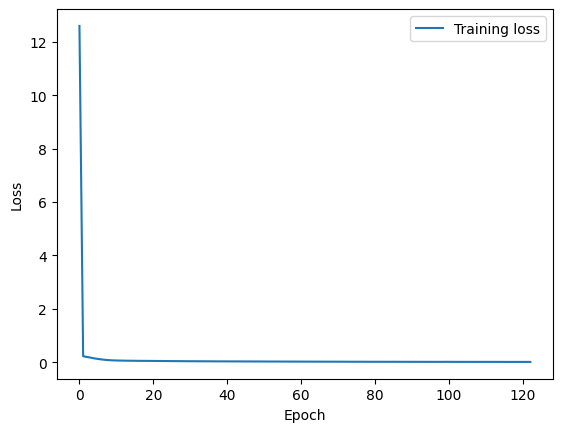

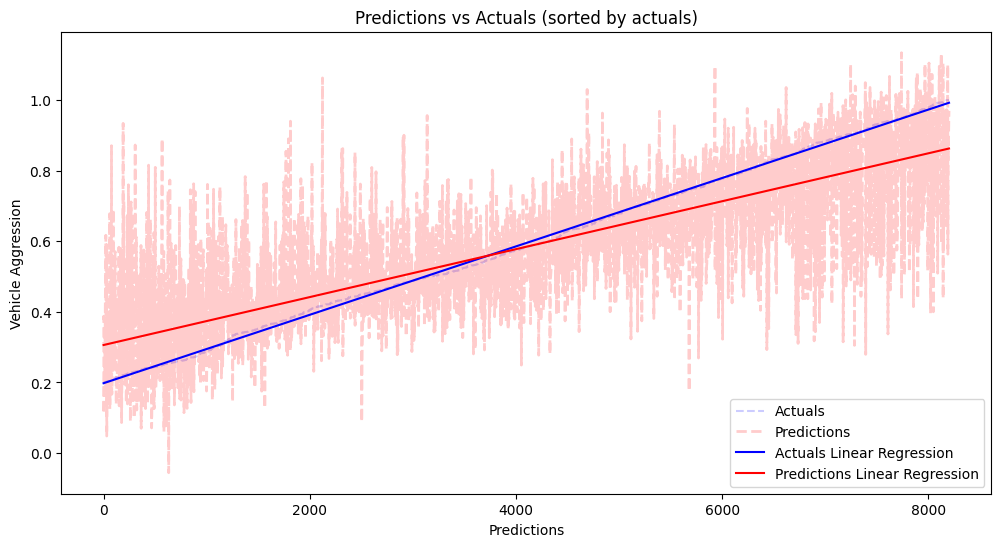

[I 2023-05-21 01:38:37,860] Trial 17 finished with value: 0.01622083086806994 and parameters: {'num_filters': 160, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 64, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00036306296540862033}. Best is trial 17 with value: 0.01622083086806994.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 25.2824!
Epoch 1 loss improved from 25.2824 to 0.0653!
Epoch 2 loss improved from 0.0653 to 0.0633!
Epoch 3 loss improved from 0.0633 to 0.0615!
Epoch 4 loss improved from 0.0615 to 0.0602!
Epoch 5 loss improved from 0.0602 to 0.0590!
Epoch 6 loss improved from 0.0590 to 0.0577!
Epoch 7 loss did not improve from 0.0577! Remaining epochs: 9
Epoch 8 loss improved from 0.0577 to 0.0554!
Epoch 9 loss did not improve from 0.0554! Remaining epochs: 9
Epoch 10 loss improved from 0.0554 to 0.0530!
Epoch 11 loss improved from 0.0530 to 0.0517!
Epoch 12 loss did not improve from 0.0517! Remaining epochs: 9
Epoch 13 loss improved from 0.0517 to 0.0497!
Epoch 14 loss improved from 0.0497 to 0.0484!
Epoch 15 loss did not improve from 0.0484! Remaining epochs: 9
Epoch 16 loss improved from 0.0484 to 0.0465!
Epoch 17 loss did not improve from 0.0465! Remaining epochs: 9
Epoch 18 loss improved from 0.0465 to 0.0449!
Epoch 19 loss did no

[I 2023-05-21 01:38:56,966] Trial 18 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 7.9659!
Epoch 1 loss improved from 7.9659 to 0.1789!
Epoch 2 loss improved from 0.1789 to 0.1317!
Epoch 3 loss improved from 0.1317 to 0.0754!
Epoch 4 loss improved from 0.0754 to 0.0688!
Epoch 5 loss improved from 0.0688 to 0.0665!
Epoch 6 loss improved from 0.0665 to 0.0649!
Epoch 7 loss improved from 0.0649 to 0.0630!
Epoch 8 loss improved from 0.0630 to 0.0618!
Epoch 9 loss improved from 0.0618 to 0.0604!
Epoch 10 loss improved from 0.0604 to 0.0588!
Epoch 11 loss improved from 0.0588 to 0.0577!
Epoch 12 loss did not improve from 0.0577! Remaining epochs: 9
Epoch 13 loss improved from 0.0577 to 0.0557!
Epoch 14 loss did not improve from 0.0557! Remaining epochs: 9
Epoch 15 loss improved from 0.0557 to 0.0537!
Epoch 16 loss improved from 0.0537 to 0.0526!
Epoch 17 loss did not improve from 0.0526! Remaining epochs: 9
Epoch 18 loss improved from 0.0526 to 0.0506!
Epoch 19 loss did not improve from 0.0506! Remaining epo

[I 2023-05-21 01:39:08,036] Trial 19 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 42.1658!
Epoch 1 loss improved from 42.1658 to 0.2689!
Epoch 2 loss improved from 0.2689 to 0.2509!
Epoch 3 loss improved from 0.2509 to 0.2301!
Epoch 4 loss improved from 0.2301 to 0.2071!
Epoch 5 loss improved from 0.2071 to 0.1832!
Epoch 6 loss improved from 0.1832 to 0.1600!
Epoch 7 loss improved from 0.1600 to 0.1381!
Epoch 8 loss improved from 0.1381 to 0.1182!
Epoch 9 loss improved from 0.1182 to 0.1010!
Epoch 10 loss improved from 0.1010 to 0.0867!
Epoch 11 loss improved from 0.0867 to 0.0754!
Epoch 12 loss improved from 0.0754 to 0.0669!
Epoch 13 loss improved from 0.0669 to 0.0610!
Epoch 14 loss improved from 0.0610 to 0.0570!
Epoch 15 loss improved from 0.0570 to 0.0546!
Epoch 16 loss improved from 0.0546 to 0.0532!
Epoch 17 loss did not improve from 0.0532! Remaining epochs: 9
Epoch 18 loss improved from 0.0532 to 0.0522!
Epoch 19 loss did not improve from 0.0522! Remaining epochs: 9


[I 2023-05-21 01:39:19,485] Trial 20 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 233.3065!
Epoch 1 loss improved from 233.3065 to 0.0695!
Epoch 2 loss improved from 0.0695 to 0.0670!
Epoch 3 loss improved from 0.0670 to 0.0658!
Epoch 4 loss improved from 0.0658 to 0.0627!
Epoch 5 loss improved from 0.0627 to 0.0612!
Epoch 6 loss improved from 0.0612 to 0.0601!
Epoch 7 loss improved from 0.0601 to 0.0588!
Epoch 8 loss improved from 0.0588 to 0.0577!
Epoch 9 loss did not improve from 0.0577! Remaining epochs: 9
Epoch 10 loss did not improve from 0.0577! Remaining epochs: 8
Epoch 11 loss improved from 0.0577 to 0.0566!
Epoch 12 loss did not improve from 0.0566! Remaining epochs: 9
Epoch 13 loss improved from 0.0566 to 0.0552!
Epoch 14 loss did not improve from 0.0552! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0552! Remaining epochs: 8
Epoch 16 loss did not improve from 0.0552! Remaining epochs: 7
Epoch 17 loss improved from 0.0552 to 0.0540!
Epoch 18 loss did not improve from 0.0540! Rema

[I 2023-05-21 01:39:30,916] Trial 21 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 21.0297!
Epoch 1 loss improved from 21.0297 to 0.3422!
Epoch 2 loss improved from 0.3422 to 0.3217!
Epoch 3 loss improved from 0.3217 to 0.2972!
Epoch 4 loss improved from 0.2972 to 0.2701!
Epoch 5 loss improved from 0.2701 to 0.2416!
Epoch 6 loss improved from 0.2416 to 0.2136!
Epoch 7 loss improved from 0.2136 to 0.1862!
Epoch 8 loss improved from 0.1862 to 0.1605!
Epoch 9 loss improved from 0.1605 to 0.1374!
Epoch 10 loss improved from 0.1374 to 0.1171!
Epoch 11 loss improved from 0.1171 to 0.1000!
Epoch 12 loss improved from 0.1000 to 0.0860!
Epoch 13 loss improved from 0.0860 to 0.0751!
Epoch 14 loss improved from 0.0751 to 0.0670!
Epoch 15 loss improved from 0.0670 to 0.0611!
Epoch 16 loss improved from 0.0611 to 0.0572!
Epoch 17 loss improved from 0.0572 to 0.0548!
Epoch 18 loss improved from 0.0548 to 0.0533!
Epoch 19 loss did not improve from 0.0533! Remaining epochs: 9


[I 2023-05-21 01:39:42,325] Trial 22 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 29.7720!
Epoch 1 loss improved from 29.7720 to 0.3868!
Epoch 2 loss improved from 0.3868 to 0.3589!
Epoch 3 loss improved from 0.3589 to 0.3253!
Epoch 4 loss improved from 0.3253 to 0.2891!
Epoch 5 loss improved from 0.2891 to 0.2526!
Epoch 6 loss improved from 0.2526 to 0.2167!
Epoch 7 loss improved from 0.2167 to 0.1831!
Epoch 8 loss improved from 0.1831 to 0.1529!
Epoch 9 loss improved from 0.1529 to 0.1269!
Epoch 10 loss improved from 0.1269 to 0.1053!
Epoch 11 loss improved from 0.1053 to 0.0884!
Epoch 12 loss improved from 0.0884 to 0.0754!
Epoch 13 loss improved from 0.0754 to 0.0664!
Epoch 14 loss improved from 0.0664 to 0.0602!
Epoch 15 loss improved from 0.0602 to 0.0563!
Epoch 16 loss improved from 0.0563 to 0.0541!
Epoch 17 loss improved from 0.0541 to 0.0529!
Epoch 18 loss did not improve from 0.0529! Remaining epochs: 9
Epoch 19 loss did not improve from 0.0529! Remaining epochs: 8


[I 2023-05-21 01:39:53,763] Trial 23 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1340.5993!
Epoch 1 loss improved from 1340.5993 to 0.3890!
Epoch 2 loss improved from 0.3890 to 0.2216!
Epoch 3 loss improved from 0.2216 to 0.0761!
Epoch 4 loss improved from 0.0761 to 0.0526!
Epoch 5 loss did not improve from 0.0526! Remaining epochs: 9
Epoch 6 loss did not improve from 0.0526! Remaining epochs: 8
Epoch 7 loss did not improve from 0.0526! Remaining epochs: 7
Epoch 8 loss did not improve from 0.0526! Remaining epochs: 6
Epoch 9 loss did not improve from 0.0526! Remaining epochs: 5
Epoch 10 loss did not improve from 0.0526! Remaining epochs: 4
Epoch 11 loss did not improve from 0.0526! Remaining epochs: 3
Epoch 12 loss did not improve from 0.0526! Remaining epochs: 2
Epoch 13 loss did not improve from 0.0526! Remaining epochs: 1
Epoch 14 loss did not improve from 0.0526! Remaining epochs: 0
Early stopping!


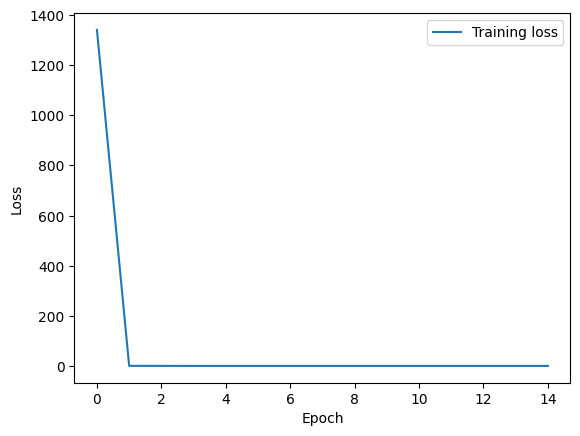

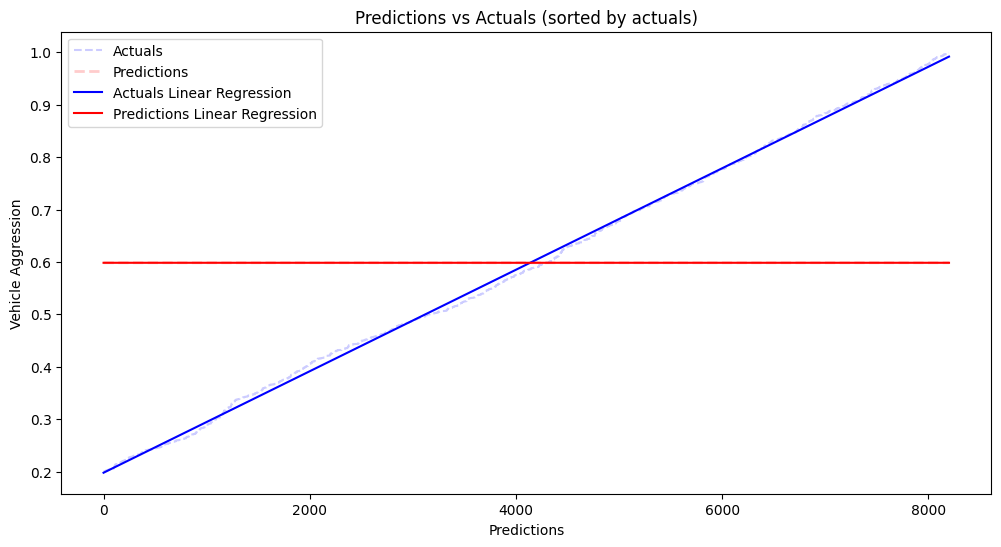

[I 2023-05-21 01:40:02,431] Trial 24 finished with value: 0.05286608601991947 and parameters: {'num_filters': 288, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 72, 'dropout_rate': 0.2, 'learning_rate': 0.001188790060257561}. Best is trial 17 with value: 0.01622083086806994.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 3.6557!
Epoch 1 loss improved from 3.6557 to 0.0732!
Epoch 2 loss improved from 0.0732 to 0.0671!
Epoch 3 loss improved from 0.0671 to 0.0642!
Epoch 4 loss improved from 0.0642 to 0.0616!
Epoch 5 loss improved from 0.0616 to 0.0590!
Epoch 6 loss improved from 0.0590 to 0.0568!
Epoch 7 loss improved from 0.0568 to 0.0550!
Epoch 8 loss improved from 0.0550 to 0.0529!
Epoch 9 loss did not improve from 0.0529! Remaining epochs: 9
Epoch 10 loss improved from 0.0529 to 0.0513!
Epoch 11 loss did not improve from 0.0513! Remaining epochs: 9
Epoch 12 loss improved from 0.0513 to 0.0495!
Epoch 13 loss did not improve from 0.0495! Remaining epochs: 9
Epoch 14 loss improved from 0.0495 to 0.0476!
Epoch 15 loss did not improve from 0.0476! Remaining epochs: 9
Epoch 16 loss improved from 0.0476 to 0.0465!
Epoch 17 loss did not improve from 0.0465! Remaining epochs: 9
Epoch 18 loss improved from 0.0465 to 0.0446!
Epoch 19 loss did not 

[I 2023-05-21 01:40:37,642] Trial 25 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 45.6252!
Epoch 1 loss improved from 45.6252 to 0.0866!
Epoch 2 loss improved from 0.0866 to 0.0750!
Epoch 3 loss improved from 0.0750 to 0.0700!
Epoch 4 loss improved from 0.0700 to 0.0666!
Epoch 5 loss improved from 0.0666 to 0.0637!
Epoch 6 loss improved from 0.0637 to 0.0587!
Epoch 7 loss improved from 0.0587 to 0.0556!
Epoch 8 loss improved from 0.0556 to 0.0538!
Epoch 9 loss improved from 0.0538 to 0.0521!
Epoch 10 loss improved from 0.0521 to 0.0510!
Epoch 11 loss did not improve from 0.0510! Remaining epochs: 9
Epoch 12 loss improved from 0.0510 to 0.0492!
Epoch 13 loss did not improve from 0.0492! Remaining epochs: 9
Epoch 14 loss improved from 0.0492 to 0.0473!
Epoch 15 loss did not improve from 0.0473! Remaining epochs: 9
Epoch 16 loss improved from 0.0473 to 0.0460!
Epoch 17 loss did not improve from 0.0460! Remaining epochs: 9
Epoch 18 loss improved from 0.0460 to 0.0443!
Epoch 19 loss improved from 0.0443 to

[I 2023-05-21 01:40:56,462] Trial 26 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 260.2994!
Epoch 1 loss improved from 260.2994 to 0.3809!
Epoch 2 loss improved from 0.3809 to 0.3686!
Epoch 3 loss improved from 0.3686 to 0.3529!
Epoch 4 loss improved from 0.3529 to 0.3345!
Epoch 5 loss improved from 0.3345 to 0.3137!
Epoch 6 loss improved from 0.3137 to 0.2915!
Epoch 7 loss improved from 0.2915 to 0.2675!
Epoch 8 loss improved from 0.2675 to 0.2428!
Epoch 9 loss improved from 0.2428 to 0.2178!
Epoch 10 loss improved from 0.2178 to 0.1932!
Epoch 11 loss improved from 0.1932 to 0.1695!
Epoch 12 loss improved from 0.1695 to 0.1472!
Epoch 13 loss improved from 0.1472 to 0.1270!
Epoch 14 loss improved from 0.1270 to 0.1092!
Epoch 15 loss improved from 0.1092 to 0.0939!
Epoch 16 loss improved from 0.0939 to 0.0815!
Epoch 17 loss improved from 0.0815 to 0.0718!
Epoch 18 loss improved from 0.0718 to 0.0646!
Epoch 19 loss improved from 0.0646 to 0.0595!


[I 2023-05-21 01:41:07,249] Trial 27 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 25.3859!
Epoch 1 loss improved from 25.3859 to 0.4650!
Epoch 2 loss improved from 0.4650 to 0.4304!
Epoch 3 loss improved from 0.4304 to 0.3894!
Epoch 4 loss improved from 0.3894 to 0.3454!
Epoch 5 loss improved from 0.3454 to 0.3004!
Epoch 6 loss improved from 0.3004 to 0.2569!
Epoch 7 loss improved from 0.2569 to 0.2160!
Epoch 8 loss improved from 0.2160 to 0.1793!
Epoch 9 loss improved from 0.1793 to 0.1474!
Epoch 10 loss improved from 0.1474 to 0.1208!
Epoch 11 loss improved from 0.1208 to 0.0997!
Epoch 12 loss improved from 0.0997 to 0.0835!
Epoch 13 loss improved from 0.0835 to 0.0717!
Epoch 14 loss improved from 0.0717 to 0.0636!
Epoch 15 loss improved from 0.0636 to 0.0583!
Epoch 16 loss improved from 0.0583 to 0.0552!
Epoch 17 loss improved from 0.0552 to 0.0535!
Epoch 18 loss did not improve from 0.0535! Remaining epochs: 9
Epoch 19 loss improved from 0.0535 to 0.0522!


[I 2023-05-21 01:41:17,992] Trial 28 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 2232.0819!
Epoch 1 loss improved from 2232.0819 to 0.0573!
Epoch 2 loss improved from 0.0573 to 0.0551!
Epoch 3 loss did not improve from 0.0551! Remaining epochs: 9
Epoch 4 loss did not improve from 0.0551! Remaining epochs: 8
Epoch 5 loss did not improve from 0.0551! Remaining epochs: 7
Epoch 6 loss improved from 0.0551 to 0.0534!
Epoch 7 loss did not improve from 0.0534! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0534! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0534! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0534! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0534! Remaining epochs: 5
Epoch 12 loss improved from 0.0534 to 0.0523!
Epoch 13 loss did not improve from 0.0523! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0523! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0523! Remaining epochs: 7
Epoch 16 loss did not improve from 0.0523! Remaining

[I 2023-05-21 01:41:28,963] Trial 29 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 2.7740!
Epoch 1 loss improved from 2.7740 to 0.1339!
Epoch 2 loss improved from 0.1339 to 0.0730!
Epoch 3 loss improved from 0.0730 to 0.0612!
Epoch 4 loss improved from 0.0612 to 0.0584!
Epoch 5 loss improved from 0.0584 to 0.0555!
Epoch 6 loss improved from 0.0555 to 0.0538!
Epoch 7 loss improved from 0.0538 to 0.0524!
Epoch 8 loss improved from 0.0524 to 0.0512!
Epoch 9 loss did not improve from 0.0512! Remaining epochs: 9
Epoch 10 loss improved from 0.0512 to 0.0494!
Epoch 11 loss did not improve from 0.0494! Remaining epochs: 9
Epoch 12 loss improved from 0.0494 to 0.0479!
Epoch 13 loss improved from 0.0479 to 0.0464!
Epoch 14 loss did not improve from 0.0464! Remaining epochs: 9
Epoch 15 loss improved from 0.0464 to 0.0446!
Epoch 16 loss did not improve from 0.0446! Remaining epochs: 9
Epoch 17 loss improved from 0.0446 to 0.0433!
Epoch 18 loss did not improve from 0.0433! Remaining epochs: 9
Epoch 19 loss improved

[I 2023-05-21 01:42:01,458] Trial 30 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1907.4607!
Epoch 1 loss improved from 1907.4607 to 0.0929!
Epoch 2 loss did not improve from 0.0929! Remaining epochs: 9
Epoch 3 loss improved from 0.0929 to 0.0917!
Epoch 4 loss did not improve from 0.0917! Remaining epochs: 9
Epoch 5 loss did not improve from 0.0917! Remaining epochs: 8
Epoch 6 loss did not improve from 0.0917! Remaining epochs: 7
Epoch 7 loss improved from 0.0917 to 0.0885!
Epoch 8 loss did not improve from 0.0885! Remaining epochs: 9
Epoch 9 loss improved from 0.0885 to 0.0867!
Epoch 10 loss improved from 0.0867 to 0.0854!
Epoch 11 loss improved from 0.0854 to 0.0843!
Epoch 12 loss improved from 0.0843 to 0.0825!
Epoch 13 loss improved from 0.0825 to 0.0815!
Epoch 14 loss improved from 0.0815 to 0.0789!
Epoch 15 loss improved from 0.0789 to 0.0777!
Epoch 16 loss improved from 0.0777 to 0.0764!
Epoch 17 loss did not improve from 0.0764! Remaining epochs: 9
Epoch 18 loss improved from 0.0764 to 0.0745!

[I 2023-05-21 01:42:12,379] Trial 31 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 2801.2280!
Epoch 1 loss improved from 2801.2280 to 0.0841!
Epoch 2 loss improved from 0.0841 to 0.0702!
Epoch 3 loss did not improve from 0.0702! Remaining epochs: 9
Epoch 4 loss did not improve from 0.0702! Remaining epochs: 8
Epoch 5 loss did not improve from 0.0702! Remaining epochs: 7
Epoch 6 loss did not improve from 0.0702! Remaining epochs: 6
Epoch 7 loss did not improve from 0.0702! Remaining epochs: 5
Epoch 8 loss did not improve from 0.0702! Remaining epochs: 4
Epoch 9 loss did not improve from 0.0702! Remaining epochs: 3
Epoch 10 loss improved from 0.0702 to 0.0689!
Epoch 11 loss did not improve from 0.0689! Remaining epochs: 9
Epoch 12 loss did not improve from 0.0689! Remaining epochs: 8
Epoch 13 loss improved from 0.0689 to 0.0678!
Epoch 14 loss did not improve from 0.0678! Remaining epochs: 9
Epoch 15 loss improved from 0.0678 to 0.0665!
Epoch 16 loss did not improve from 0.0665! Remaining epochs: 9
Epoch 

[I 2023-05-21 01:42:23,309] Trial 32 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 793.5692!
Epoch 1 loss improved from 793.5692 to 0.0944!
Epoch 2 loss improved from 0.0944 to 0.0853!
Epoch 3 loss improved from 0.0853 to 0.0824!
Epoch 4 loss improved from 0.0824 to 0.0807!
Epoch 5 loss improved from 0.0807 to 0.0788!
Epoch 6 loss did not improve from 0.0788! Remaining epochs: 9
Epoch 7 loss improved from 0.0788 to 0.0770!
Epoch 8 loss did not improve from 0.0770! Remaining epochs: 9
Epoch 9 loss improved from 0.0770 to 0.0754!
Epoch 10 loss improved from 0.0754 to 0.0741!
Epoch 11 loss did not improve from 0.0741! Remaining epochs: 9
Epoch 12 loss improved from 0.0741 to 0.0721!
Epoch 13 loss did not improve from 0.0721! Remaining epochs: 9
Epoch 14 loss improved from 0.0721 to 0.0704!
Epoch 15 loss improved from 0.0704 to 0.0687!
Epoch 16 loss improved from 0.0687 to 0.0673!
Epoch 17 loss improved from 0.0673 to 0.0652!
Epoch 18 loss improved from 0.0652 to 0.0625!
Epoch 19 loss improved from 0.0625 

[I 2023-05-21 01:42:34,656] Trial 33 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 6823.4701!
Epoch 1 loss improved from 6823.4701 to 0.2339!
Epoch 2 loss improved from 0.2339 to 0.0770!
Epoch 3 loss improved from 0.0770 to 0.0522!
Epoch 4 loss did not improve from 0.0522! Remaining epochs: 9
Epoch 5 loss did not improve from 0.0522! Remaining epochs: 8
Epoch 6 loss did not improve from 0.0522! Remaining epochs: 7
Epoch 7 loss did not improve from 0.0522! Remaining epochs: 6
Epoch 8 loss did not improve from 0.0522! Remaining epochs: 5
Epoch 9 loss did not improve from 0.0522! Remaining epochs: 4
Epoch 10 loss did not improve from 0.0522! Remaining epochs: 3
Epoch 11 loss did not improve from 0.0522! Remaining epochs: 2
Epoch 12 loss did not improve from 0.0522! Remaining epochs: 1
Epoch 13 loss did not improve from 0.0522! Remaining epochs: 0
Early stopping!


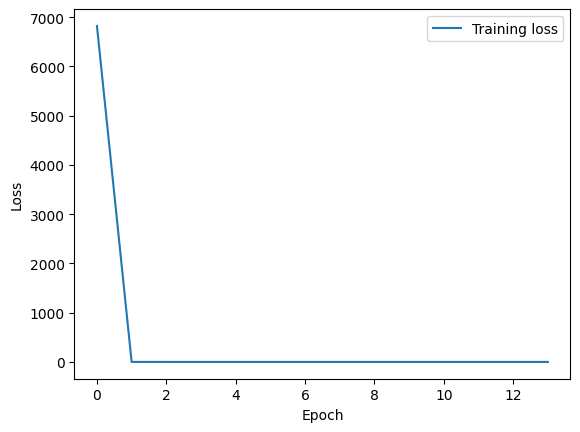

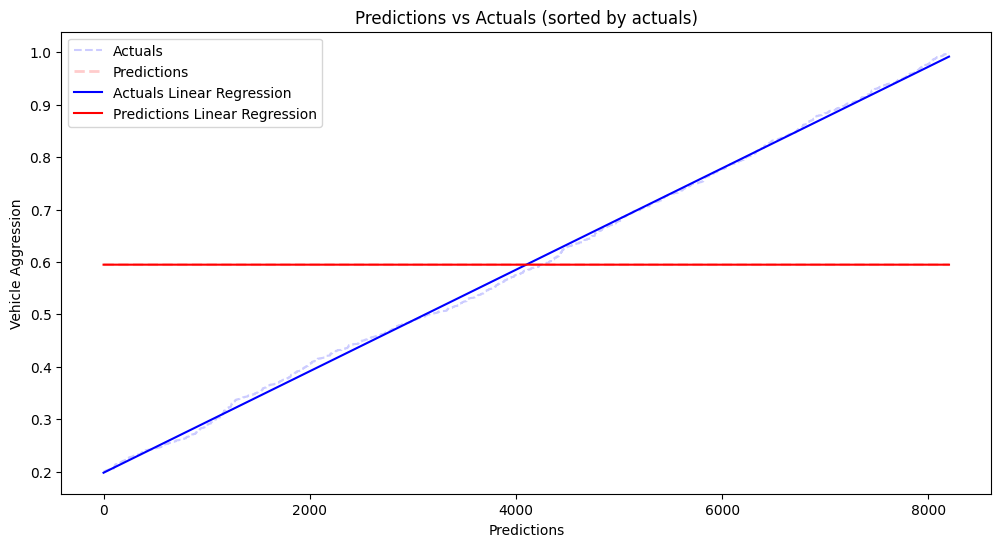

[I 2023-05-21 01:42:42,085] Trial 34 finished with value: 0.05286277228823075 and parameters: {'num_filters': 256, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0019895480593083354}. Best is trial 17 with value: 0.01622083086806994.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 4106.2082!
Epoch 1 loss improved from 4106.2082 to 0.0760!
Epoch 2 loss did not improve from 0.0760! Remaining epochs: 9
Epoch 3 loss did not improve from 0.0760! Remaining epochs: 8
Epoch 4 loss improved from 0.0760 to 0.0714!
Epoch 5 loss did not improve from 0.0714! Remaining epochs: 9
Epoch 6 loss did not improve from 0.0714! Remaining epochs: 8
Epoch 7 loss did not improve from 0.0714! Remaining epochs: 7
Epoch 8 loss improved from 0.0714 to 0.0659!
Epoch 9 loss did not improve from 0.0659! Remaining epochs: 9
Epoch 10 loss did not improve from 0.0659! Remaining epochs: 8
Epoch 11 loss did not improve from 0.0659! Remaining epochs: 7
Epoch 12 loss did not improve from 0.0659! Remaining epochs: 6
Epoch 13 loss improved from 0.0659 to 0.0640!
Epoch 14 loss did not improve from 0.0640! Remaining epochs: 9
Epoch 15 loss improved from 0.0640 to 0.0626!
Epoch 16 loss did not improve from 0.0626! Remaining epochs: 9
Epoch 

[I 2023-05-21 01:42:52,774] Trial 35 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 364.6395!
Epoch 1 loss improved from 364.6395 to 0.1828!
Epoch 2 loss improved from 0.1828 to 0.0969!
Epoch 3 loss improved from 0.0969 to 0.0823!
Epoch 4 loss improved from 0.0823 to 0.0802!
Epoch 5 loss improved from 0.0802 to 0.0786!
Epoch 6 loss did not improve from 0.0786! Remaining epochs: 9
Epoch 7 loss improved from 0.0786 to 0.0776!
Epoch 8 loss did not improve from 0.0776! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0776! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0776! Remaining epochs: 7
Epoch 11 loss improved from 0.0776 to 0.0757!
Epoch 12 loss did not improve from 0.0757! Remaining epochs: 9
Epoch 13 loss did not improve from 0.0757! Remaining epochs: 8
Epoch 14 loss did not improve from 0.0757! Remaining epochs: 7
Epoch 15 loss improved from 0.0757 to 0.0678!
Epoch 16 loss did not improve from 0.0678! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0678! Remaining epochs

[I 2023-05-21 01:43:03,513] Trial 36 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1215.0790!
Epoch 1 loss improved from 1215.0790 to 0.2798!
Epoch 2 loss improved from 0.2798 to 0.2708!
Epoch 3 loss improved from 0.2708 to 0.2593!
Epoch 4 loss improved from 0.2593 to 0.2461!
Epoch 5 loss improved from 0.2461 to 0.2310!
Epoch 6 loss improved from 0.2310 to 0.2147!
Epoch 7 loss improved from 0.2147 to 0.1976!
Epoch 8 loss improved from 0.1976 to 0.1799!
Epoch 9 loss improved from 0.1799 to 0.1620!
Epoch 10 loss improved from 0.1620 to 0.1445!
Epoch 11 loss improved from 0.1445 to 0.1280!
Epoch 12 loss improved from 0.1280 to 0.1125!
Epoch 13 loss improved from 0.1125 to 0.0986!
Epoch 14 loss improved from 0.0986 to 0.0867!
Epoch 15 loss improved from 0.0867 to 0.0768!
Epoch 16 loss improved from 0.0768 to 0.0689!
Epoch 17 loss improved from 0.0689 to 0.0629!
Epoch 18 loss improved from 0.0629 to 0.0586!
Epoch 19 loss improved from 0.0586 to 0.0557!


[I 2023-05-21 01:43:14,221] Trial 37 pruned. 


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 1118692.8691!
Epoch 1 loss improved from 1118692.8691 to 0.1528!
Epoch 2 loss did not improve from 0.1528! Remaining epochs: 9
Epoch 3 loss did not improve from 0.1528! Remaining epochs: 8
Epoch 4 loss did not improve from 0.1528! Remaining epochs: 7
Epoch 5 loss did not improve from 0.1528! Remaining epochs: 6
Epoch 6 loss did not improve from 0.1528! Remaining epochs: 5
Epoch 7 loss did not improve from 0.1528! Remaining epochs: 4
Epoch 8 loss did not improve from 0.1528! Remaining epochs: 3
Epoch 9 loss did not improve from 0.1528! Remaining epochs: 2
Epoch 10 loss did not improve from 0.1528! Remaining epochs: 1
Epoch 11 loss did not improve from 0.1528! Remaining epochs: 0
Early stopping!


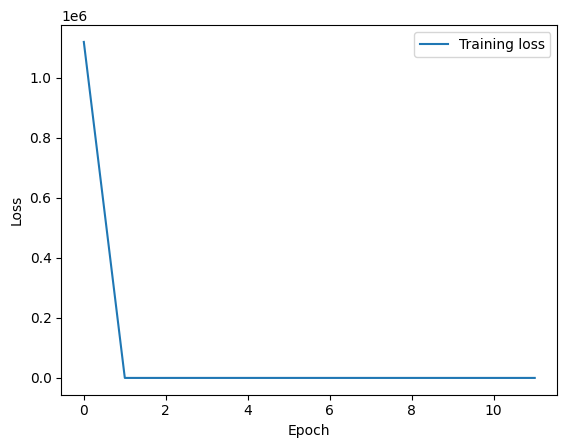

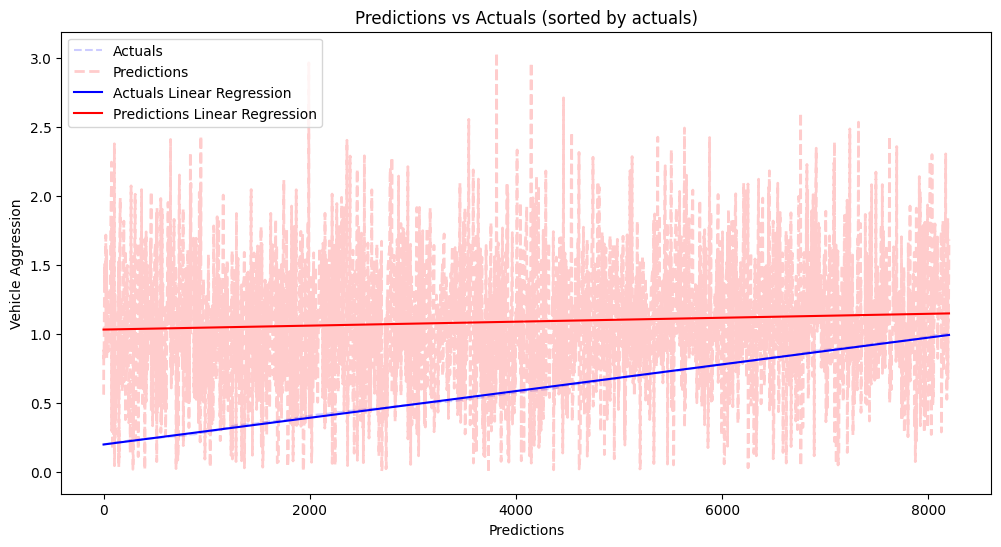

[I 2023-05-21 01:43:20,790] Trial 38 finished with value: 0.45953808426856996 and parameters: {'num_filters': 256, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 56, 'dropout_rate': 0.1, 'learning_rate': 0.009884157497090023}. Best is trial 17 with value: 0.01622083086806994.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 770856.0907!
Epoch 1 loss improved from 770856.0907 to 0.4323!
Epoch 2 loss improved from 0.4323 to 0.4299!
Epoch 3 loss did not improve from 0.4299! Remaining epochs: 9
Epoch 4 loss improved from 0.4299 to 0.4286!
Epoch 5 loss improved from 0.4286 to 0.4183!
Epoch 6 loss improved from 0.4183 to 0.4130!
Epoch 7 loss improved from 0.4130 to 0.4066!
Epoch 8 loss improved from 0.4066 to 0.3996!
Epoch 9 loss improved from 0.3996 to 0.3915!
Epoch 10 loss improved from 0.3915 to 0.3826!
Epoch 11 loss improved from 0.3826 to 0.3725!
Epoch 12 loss improved from 0.3725 to 0.3613!
Epoch 13 loss improved from 0.3613 to 0.3489!
Epoch 14 loss improved from 0.3489 to 0.3355!
Epoch 15 loss improved from 0.3355 to 0.3207!
Epoch 16 loss improved from 0.3207 to 0.3052!
Epoch 17 loss improved from 0.3052 to 0.2883!
Epoch 18 loss improved from 0.2883 to 0.2704!
Epoch 19 loss improved from 0.2704 to 0.2519!


[I 2023-05-21 01:43:32,817] Trial 39 pruned. 
[I 2023-05-21 01:43:32,832] A new study created in memory with name: no-name-3500667e-7e5d-4ca7-8d98-e7e43497cd42


Best trial 1:
	Value: 0.01622083086806994
	Params: {'num_filters': 160, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 64, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00036306296540862033}
Best trial 2:
	Value: 0.020357208269146772
	Params: {'num_filters': 192, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 56, 'dropout_rate': 0.2, 'learning_rate': 0.0003823475224675188}
Best trial 3:
	Value: 0.05286143101178683
	Params: {'num_filters': 256, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 48, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.0015436364166977854}
Best trial 4:
	Value: 0.05286277228823075
	Params: {'num_filters': 256, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0019895480593083354}
Best trial 5:
	Value: 0.05286608601991947
	Params: {'num_filters': 288, 'kernel_size': 3, 'pool_size': 2, 'hidden_layers': 72, 'dropout_rate': 0.2, 'learning_rate': 0.001188790060257561}
Epoch 0 loss improved from 

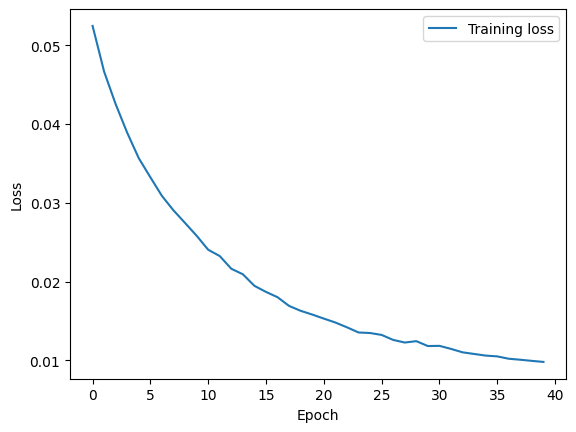

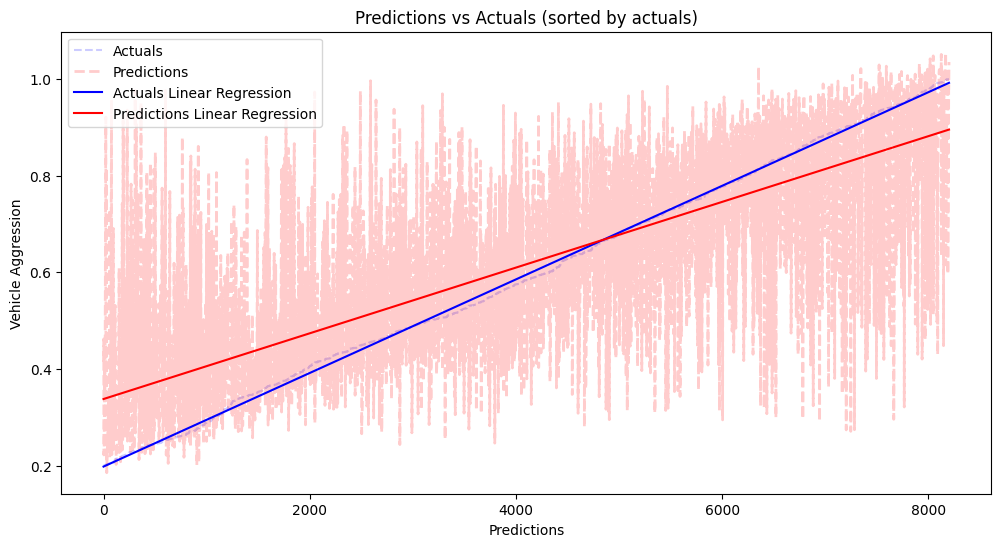

[I 2023-05-21 01:45:30,613] Trial 0 finished with value: 0.020388942011273826 and parameters: {'growth_rate': 7, 'reduction': 0.8802857225639664, 'learning_rate': 0.0029106359131330704, 'nblocks1': 6, 'nblocks2': 9}. Best is trial 0 with value: 0.020388942011273826.


Epoch 0 loss improved from inf to 0.0543!
Epoch 1 loss improved from 0.0543 to 0.0498!
Epoch 2 loss improved from 0.0498 to 0.0465!
Epoch 3 loss improved from 0.0465 to 0.0437!
Epoch 4 loss improved from 0.0437 to 0.0409!
Epoch 5 loss improved from 0.0409 to 0.0389!
Epoch 6 loss improved from 0.0389 to 0.0368!
Epoch 7 loss improved from 0.0368 to 0.0351!
Epoch 8 loss improved from 0.0351 to 0.0338!
Epoch 9 loss improved from 0.0338 to 0.0321!
Epoch 10 loss improved from 0.0321 to 0.0310!
Epoch 11 loss improved from 0.0310 to 0.0292!
Epoch 12 loss improved from 0.0292 to 0.0279!
Epoch 13 loss improved from 0.0279 to 0.0268!
Epoch 14 loss did not improve from 0.0268! Remaining epochs: 9
Epoch 15 loss improved from 0.0268 to 0.0249!
Epoch 16 loss did not improve from 0.0249! Remaining epochs: 9
Epoch 17 loss improved from 0.0249 to 0.0230!
Epoch 18 loss improved from 0.0230 to 0.0218!
Epoch 19 loss did not improve from 0.0218! Remaining epochs: 9
Epoch 20 loss improved from 0.0218 to 0.01

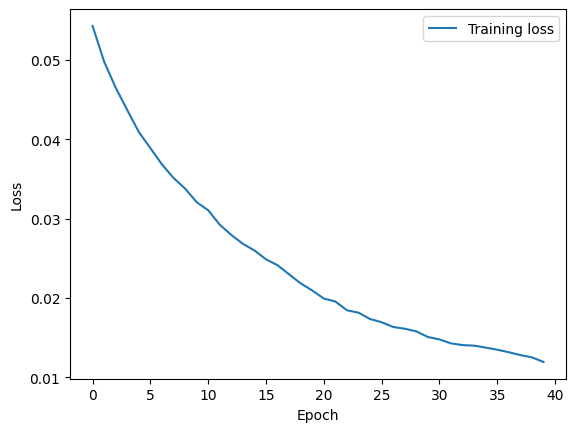

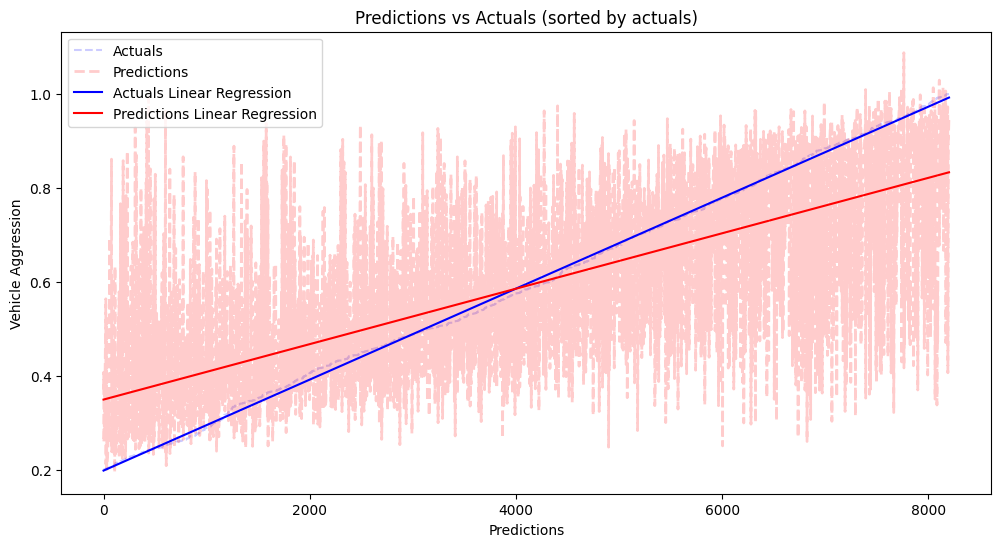

[I 2023-05-21 01:47:56,326] Trial 1 finished with value: 0.023884682557903804 and parameters: {'growth_rate': 5, 'reduction': 0.5232334448672797, 'learning_rate': 0.005399484409787433, 'nblocks1': 7, 'nblocks2': 14}. Best is trial 0 with value: 0.020388942011273826.


Epoch 0 loss improved from inf to 0.0581!
Epoch 1 loss improved from 0.0581 to 0.0477!
Epoch 2 loss improved from 0.0477 to 0.0450!
Epoch 3 loss improved from 0.0450 to 0.0422!
Epoch 4 loss improved from 0.0422 to 0.0399!
Epoch 5 loss improved from 0.0399 to 0.0383!
Epoch 6 loss improved from 0.0383 to 0.0363!
Epoch 7 loss improved from 0.0363 to 0.0352!
Epoch 8 loss improved from 0.0352 to 0.0335!
Epoch 9 loss improved from 0.0335 to 0.0322!
Epoch 10 loss did not improve from 0.0322! Remaining epochs: 9
Epoch 11 loss improved from 0.0322 to 0.0302!
Epoch 12 loss improved from 0.0302 to 0.0288!
Epoch 13 loss did not improve from 0.0288! Remaining epochs: 9
Epoch 14 loss improved from 0.0288 to 0.0277!
Epoch 15 loss did not improve from 0.0277! Remaining epochs: 9
Epoch 16 loss improved from 0.0277 to 0.0258!
Epoch 17 loss did not improve from 0.0258! Remaining epochs: 9
Epoch 18 loss improved from 0.0258 to 0.0246!
Epoch 19 loss did not improve from 0.0246! Remaining epochs: 9
Epoch 20

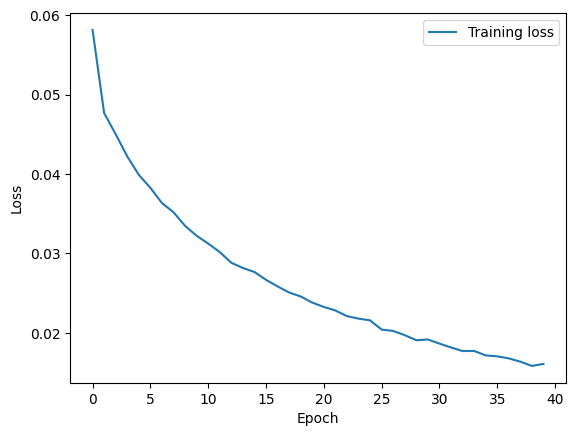

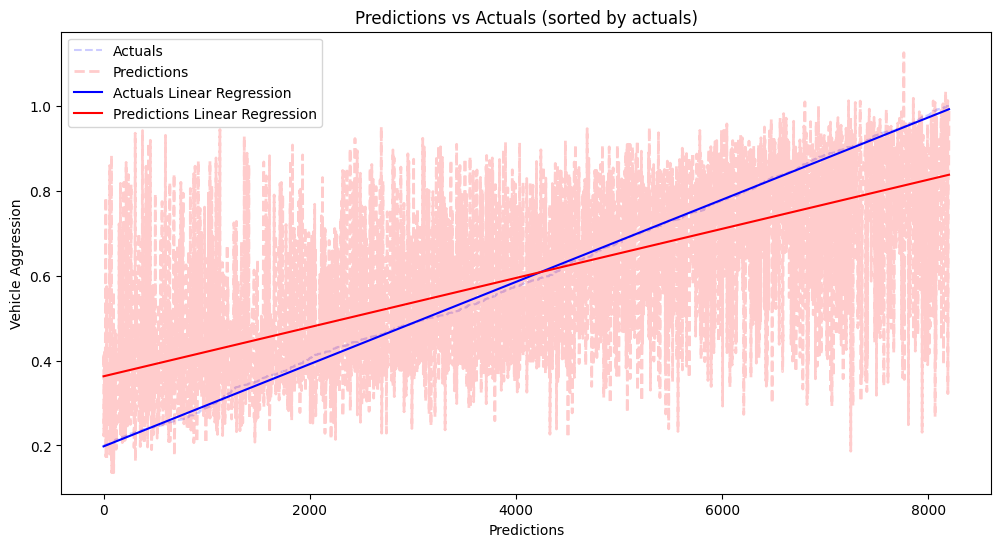

[I 2023-05-21 01:49:35,564] Trial 2 finished with value: 0.02751182044068208 and parameters: {'growth_rate': 4, 'reduction': 0.8879639408647977, 'learning_rate': 0.004622589001020831, 'nblocks1': 5, 'nblocks2': 9}. Best is trial 0 with value: 0.020388942011273826.


Epoch 0 loss improved from inf to 0.0543!
Epoch 1 loss improved from 0.0543 to 0.0461!
Epoch 2 loss improved from 0.0461 to 0.0416!
Epoch 3 loss improved from 0.0416 to 0.0381!
Epoch 4 loss improved from 0.0381 to 0.0345!
Epoch 5 loss improved from 0.0345 to 0.0317!
Epoch 6 loss improved from 0.0317 to 0.0293!
Epoch 7 loss improved from 0.0293 to 0.0273!
Epoch 8 loss improved from 0.0273 to 0.0259!
Epoch 9 loss improved from 0.0259 to 0.0242!
Epoch 10 loss did not improve from 0.0242! Remaining epochs: 9
Epoch 11 loss improved from 0.0242 to 0.0222!
Epoch 12 loss did not improve from 0.0222! Remaining epochs: 9
Epoch 13 loss improved from 0.0222 to 0.0207!
Epoch 14 loss did not improve from 0.0207! Remaining epochs: 9
Epoch 15 loss improved from 0.0207 to 0.0190!
Epoch 16 loss did not improve from 0.0190! Remaining epochs: 9
Epoch 17 loss improved from 0.0190 to 0.0179!
Epoch 18 loss did not improve from 0.0179! Remaining epochs: 9
Epoch 19 loss did not improve from 0.0179! Remaining e

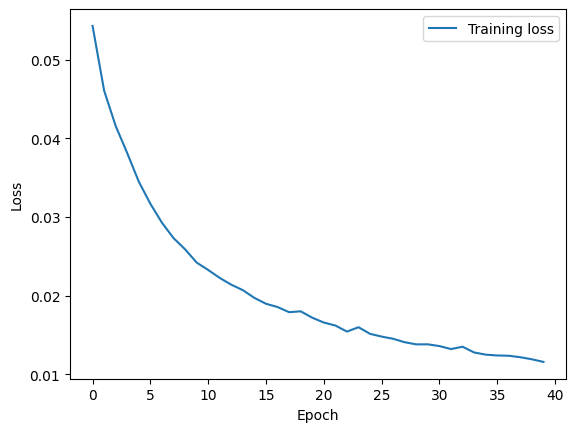

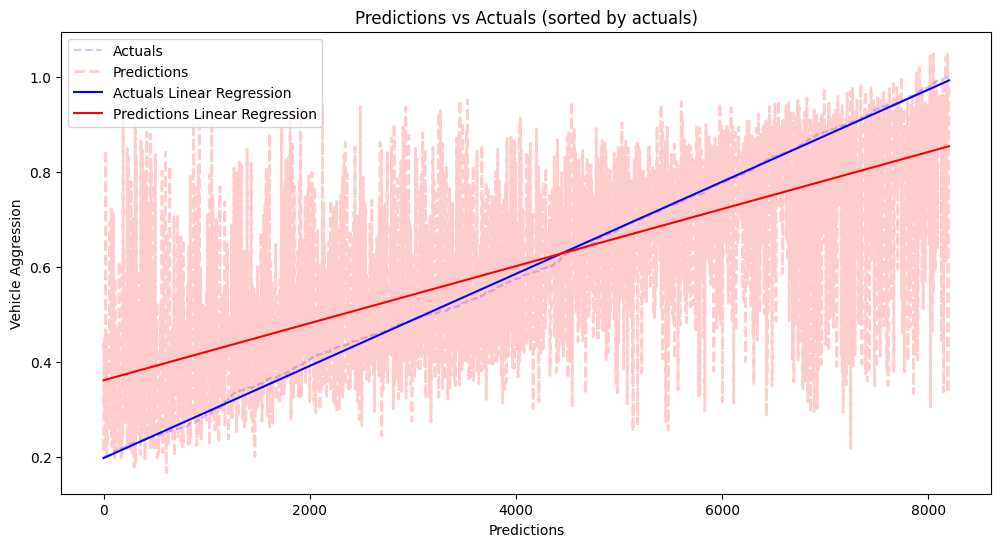

[I 2023-05-21 01:51:30,102] Trial 3 finished with value: 0.023219742353719014 and parameters: {'growth_rate': 5, 'reduction': 0.621696897183815, 'learning_rate': 0.0011207606211860567, 'nblocks1': 6, 'nblocks2': 10}. Best is trial 0 with value: 0.020388942011273826.


Epoch 0 loss improved from inf to 0.0559!
Epoch 1 loss improved from 0.0559 to 0.0416!
Epoch 2 loss improved from 0.0416 to 0.0356!
Epoch 3 loss improved from 0.0356 to 0.0308!
Epoch 4 loss improved from 0.0308 to 0.0274!
Epoch 5 loss improved from 0.0274 to 0.0242!
Epoch 6 loss improved from 0.0242 to 0.0225!
Epoch 7 loss improved from 0.0225 to 0.0205!
Epoch 8 loss improved from 0.0205 to 0.0194!
Epoch 9 loss improved from 0.0194 to 0.0182!
Epoch 10 loss did not improve from 0.0182! Remaining epochs: 9
Epoch 11 loss improved from 0.0182 to 0.0163!
Epoch 12 loss did not improve from 0.0163! Remaining epochs: 9
Epoch 13 loss improved from 0.0163 to 0.0153!
Epoch 14 loss did not improve from 0.0153! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0153! Remaining epochs: 8
Epoch 16 loss improved from 0.0153 to 0.0139!
Epoch 17 loss did not improve from 0.0139! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0139! Remaining epochs: 8
Epoch 19 loss did not improve from 0.

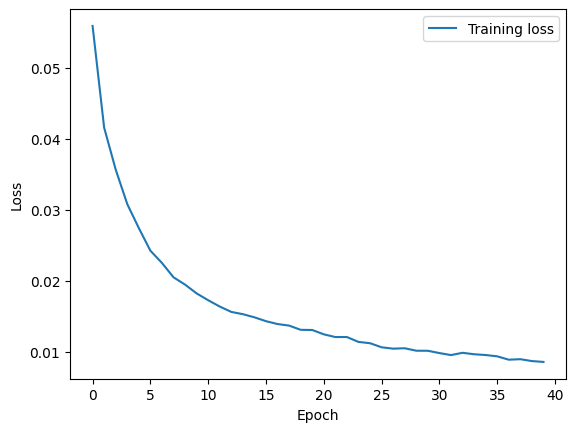

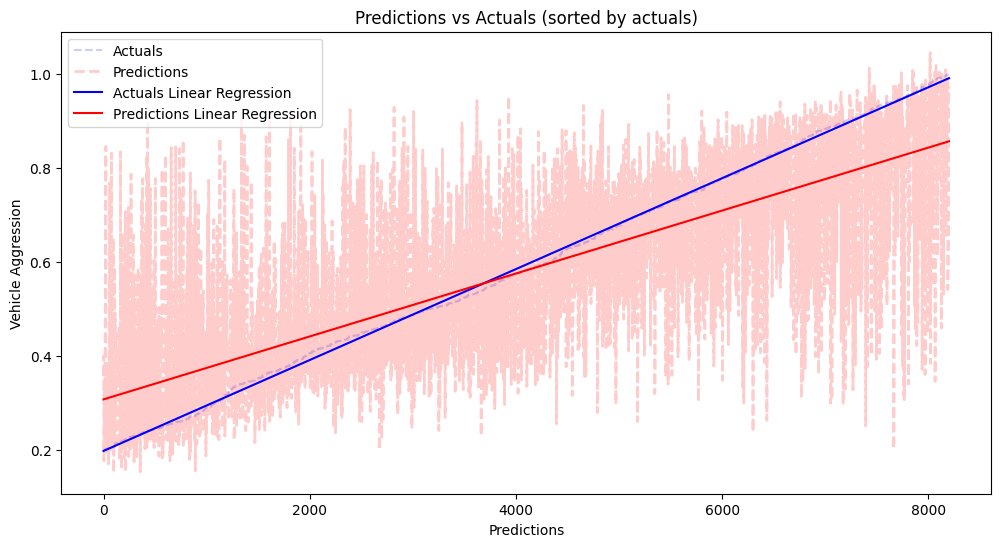

[I 2023-05-21 01:53:38,957] Trial 4 finished with value: 0.019631289776701193 and parameters: {'growth_rate': 9, 'reduction': 0.5557975442608167, 'learning_rate': 0.0003839629299804173, 'nblocks1': 5, 'nblocks2': 12}. Best is trial 4 with value: 0.019631289776701193.


Epoch 0 loss improved from inf to 0.0511!
Epoch 1 loss improved from 0.0511 to 0.0422!
Epoch 2 loss improved from 0.0422 to 0.0358!
Epoch 3 loss improved from 0.0358 to 0.0317!
Epoch 4 loss improved from 0.0317 to 0.0281!
Epoch 5 loss improved from 0.0281 to 0.0255!
Epoch 6 loss improved from 0.0255 to 0.0232!
Epoch 7 loss improved from 0.0232 to 0.0214!
Epoch 8 loss improved from 0.0214 to 0.0201!
Epoch 9 loss improved from 0.0201 to 0.0190!
Epoch 10 loss did not improve from 0.0190! Remaining epochs: 9
Epoch 11 loss improved from 0.0190 to 0.0173!
Epoch 12 loss improved from 0.0173 to 0.0162!
Epoch 13 loss did not improve from 0.0162! Remaining epochs: 9
Epoch 14 loss improved from 0.0162 to 0.0144!
Epoch 15 loss did not improve from 0.0144! Remaining epochs: 9
Epoch 16 loss improved from 0.0144 to 0.0130!
Epoch 17 loss did not improve from 0.0130! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0130! Remaining epochs: 8
Epoch 19 loss improved from 0.0130 to 0.0118!
Epoch 20

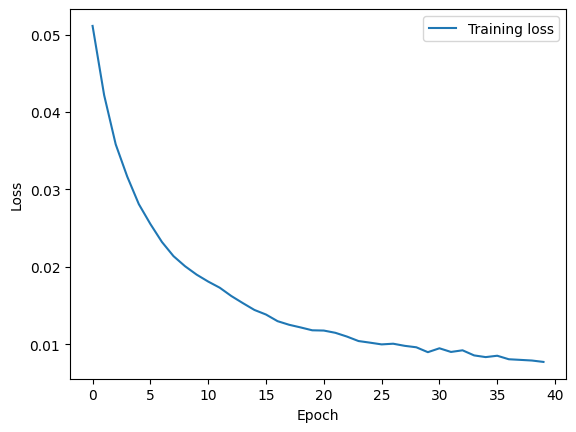

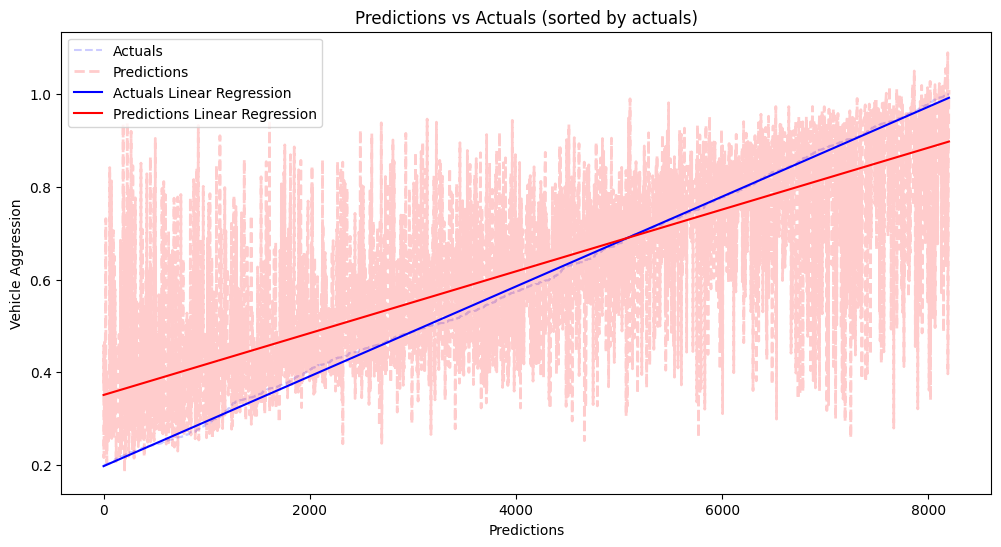

[I 2023-05-21 01:55:27,397] Trial 5 finished with value: 0.019371046201111033 and parameters: {'growth_rate': 11, 'reduction': 0.5798695128633439, 'learning_rate': 0.0010677482709481358, 'nblocks1': 6, 'nblocks2': 8}. Best is trial 5 with value: 0.019371046201111033.


Epoch 0 loss improved from inf to 0.0580!
Epoch 1 loss improved from 0.0580 to 0.0395!
Epoch 2 loss improved from 0.0395 to 0.0317!
Epoch 3 loss improved from 0.0317 to 0.0263!
Epoch 4 loss improved from 0.0263 to 0.0219!
Epoch 5 loss improved from 0.0219 to 0.0194!
Epoch 6 loss improved from 0.0194 to 0.0174!
Epoch 7 loss improved from 0.0174 to 0.0163!
Epoch 8 loss improved from 0.0163 to 0.0151!
Epoch 9 loss did not improve from 0.0151! Remaining epochs: 9
Epoch 10 loss improved from 0.0151 to 0.0134!
Epoch 11 loss did not improve from 0.0134! Remaining epochs: 9
Epoch 12 loss improved from 0.0134 to 0.0123!
Epoch 13 loss did not improve from 0.0123! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0123! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0123! Remaining epochs: 7
Epoch 16 loss did not improve from 0.0123! Remaining epochs: 6
Epoch 17 loss improved from 0.0123 to 0.0110!
Epoch 18 loss did not improve from 0.0110! Remaining epochs: 9
Epoch 19 loss did no

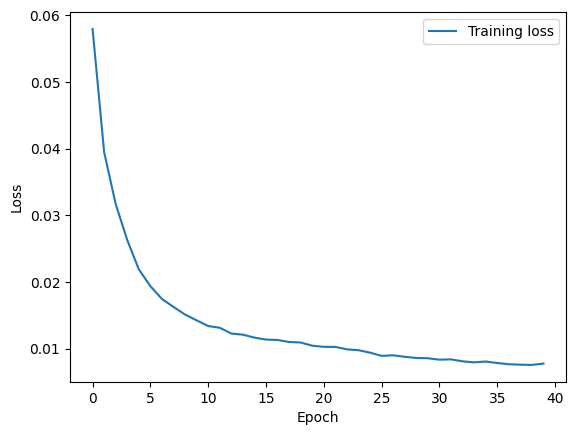

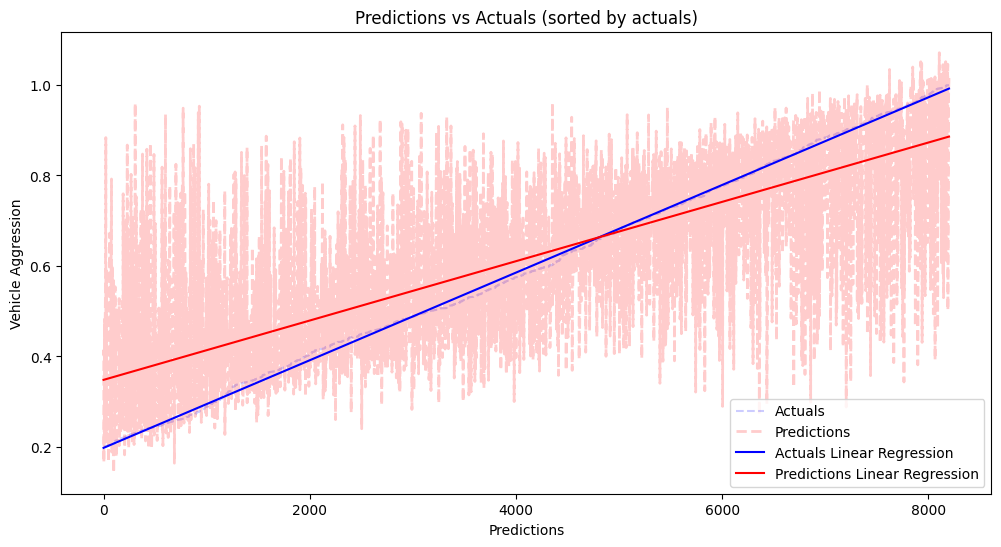

[I 2023-05-21 01:58:20,503] Trial 6 finished with value: 0.019766546613894976 and parameters: {'growth_rate': 9, 'reduction': 0.5682096494749166, 'learning_rate': 0.00013492834268013249, 'nblocks1': 8, 'nblocks2': 16}. Best is trial 5 with value: 0.019371046201111033.


Epoch 0 loss improved from inf to 0.0564!
Epoch 1 loss improved from 0.0564 to 0.0387!
Epoch 2 loss improved from 0.0387 to 0.0309!
Epoch 3 loss improved from 0.0309 to 0.0255!
Epoch 4 loss improved from 0.0255 to 0.0209!
Epoch 5 loss improved from 0.0209 to 0.0185!
Epoch 6 loss improved from 0.0185 to 0.0168!
Epoch 7 loss improved from 0.0168 to 0.0153!
Epoch 8 loss improved from 0.0153 to 0.0143!
Epoch 9 loss improved from 0.0143 to 0.0132!
Epoch 10 loss did not improve from 0.0132! Remaining epochs: 9
Epoch 11 loss did not improve from 0.0132! Remaining epochs: 8
Epoch 12 loss improved from 0.0132 to 0.0117!
Epoch 13 loss did not improve from 0.0117! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0117! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0117! Remaining epochs: 7
Epoch 16 loss did not improve from 0.0117! Remaining epochs: 6
Epoch 17 loss improved from 0.0117 to 0.0107!
Epoch 18 loss did not improve from 0.0107! Remaining epochs: 9
Epoch 19 loss did no

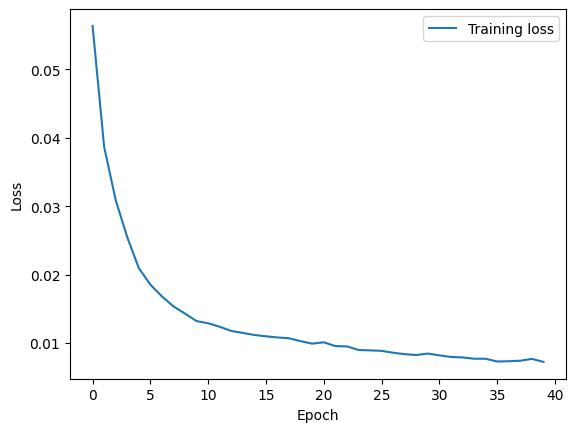

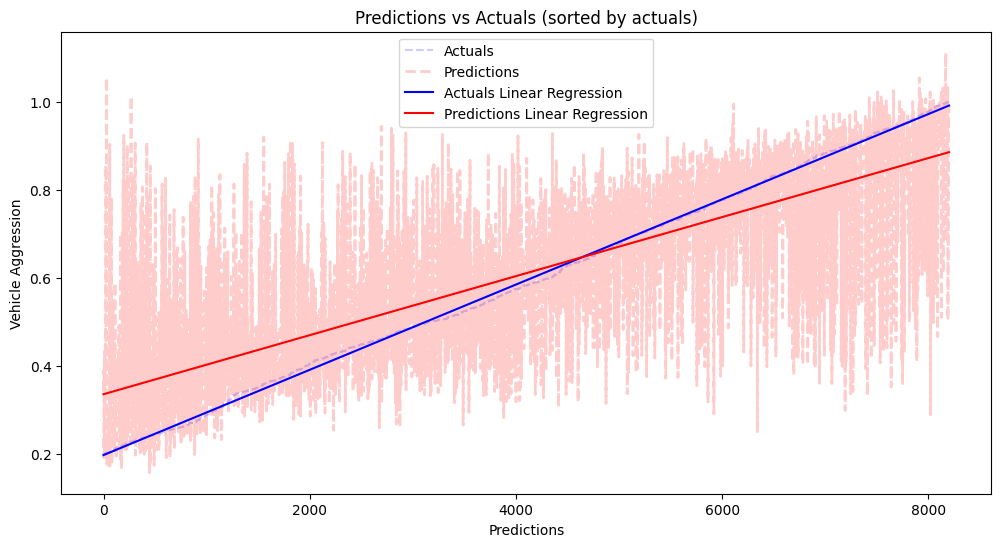

[I 2023-05-21 02:00:33,762] Trial 7 finished with value: 0.01970907121610183 and parameters: {'growth_rate': 11, 'reduction': 0.6218455076693483, 'learning_rate': 0.0001567993391672301, 'nblocks1': 7, 'nblocks2': 11}. Best is trial 5 with value: 0.019371046201111033.


Epoch 0 loss improved from inf to 0.1206!
Epoch 1 loss improved from 0.1206 to 0.0492!
Epoch 2 loss improved from 0.0492 to 0.0461!
Epoch 3 loss improved from 0.0461 to 0.0426!
Epoch 4 loss improved from 0.0426 to 0.0387!
Epoch 5 loss improved from 0.0387 to 0.0353!
Epoch 6 loss improved from 0.0353 to 0.0324!
Epoch 7 loss improved from 0.0324 to 0.0299!
Epoch 8 loss improved from 0.0299 to 0.0282!
Epoch 9 loss improved from 0.0282 to 0.0262!
Epoch 10 loss improved from 0.0262 to 0.0247!
Epoch 11 loss improved from 0.0247 to 0.0236!
Epoch 12 loss improved from 0.0236 to 0.0224!
Epoch 13 loss did not improve from 0.0224! Remaining epochs: 9
Epoch 14 loss improved from 0.0224 to 0.0207!
Epoch 15 loss did not improve from 0.0207! Remaining epochs: 9
Epoch 16 loss improved from 0.0207 to 0.0193!
Epoch 17 loss did not improve from 0.0193! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0193! Remaining epochs: 8
Epoch 19 loss improved from 0.0193 to 0.0178!


[I 2023-05-21 02:01:39,027] Trial 8 pruned. 


Epoch 0 loss improved from inf to 0.0565!
Epoch 1 loss improved from 0.0565 to 0.0437!
Epoch 2 loss improved from 0.0437 to 0.0388!
Epoch 3 loss improved from 0.0388 to 0.0341!
Epoch 4 loss improved from 0.0341 to 0.0307!
Epoch 5 loss improved from 0.0307 to 0.0280!
Epoch 6 loss improved from 0.0280 to 0.0257!
Epoch 7 loss improved from 0.0257 to 0.0238!
Epoch 8 loss improved from 0.0238 to 0.0226!
Epoch 9 loss improved from 0.0226 to 0.0210!
Epoch 10 loss improved from 0.0210 to 0.0199!
Epoch 11 loss did not improve from 0.0199! Remaining epochs: 9
Epoch 12 loss improved from 0.0199 to 0.0184!
Epoch 13 loss did not improve from 0.0184! Remaining epochs: 9
Epoch 14 loss improved from 0.0184 to 0.0168!
Epoch 15 loss did not improve from 0.0168! Remaining epochs: 9
Epoch 16 loss improved from 0.0168 to 0.0152!
Epoch 17 loss did not improve from 0.0152! Remaining epochs: 9
Epoch 18 loss improved from 0.0152 to 0.0139!
Epoch 19 loss did not improve from 0.0139! Remaining epochs: 9


[I 2023-05-21 02:02:38,452] Trial 9 pruned. 


Epoch 0 loss improved from inf to 0.0562!
Epoch 1 loss improved from 0.0562 to 0.0490!
Epoch 2 loss improved from 0.0490 to 0.0460!
Epoch 3 loss improved from 0.0460 to 0.0430!
Epoch 4 loss improved from 0.0430 to 0.0397!
Epoch 5 loss improved from 0.0397 to 0.0368!
Epoch 6 loss improved from 0.0368 to 0.0334!
Epoch 7 loss improved from 0.0334 to 0.0316!
Epoch 8 loss improved from 0.0316 to 0.0293!
Epoch 9 loss improved from 0.0293 to 0.0277!
Epoch 10 loss improved from 0.0277 to 0.0259!
Epoch 11 loss did not improve from 0.0259! Remaining epochs: 9
Epoch 12 loss improved from 0.0259 to 0.0234!
Epoch 13 loss improved from 0.0234 to 0.0223!
Epoch 14 loss did not improve from 0.0223! Remaining epochs: 9
Epoch 15 loss improved from 0.0223 to 0.0203!
Epoch 16 loss did not improve from 0.0203! Remaining epochs: 9
Epoch 17 loss improved from 0.0203 to 0.0187!
Epoch 18 loss improved from 0.0187 to 0.0175!
Epoch 19 loss did not improve from 0.0175! Remaining epochs: 9


[I 2023-05-21 02:03:25,754] Trial 10 pruned. 


Epoch 0 loss improved from inf to 0.0564!
Epoch 1 loss improved from 0.0564 to 0.0410!
Epoch 2 loss improved from 0.0410 to 0.0347!
Epoch 3 loss improved from 0.0347 to 0.0305!
Epoch 4 loss improved from 0.0305 to 0.0269!
Epoch 5 loss improved from 0.0269 to 0.0238!
Epoch 6 loss improved from 0.0238 to 0.0220!
Epoch 7 loss improved from 0.0220 to 0.0209!
Epoch 8 loss improved from 0.0209 to 0.0191!
Epoch 9 loss improved from 0.0191 to 0.0178!
Epoch 10 loss did not improve from 0.0178! Remaining epochs: 9
Epoch 11 loss improved from 0.0178 to 0.0162!
Epoch 12 loss did not improve from 0.0162! Remaining epochs: 9
Epoch 13 loss did not improve from 0.0162! Remaining epochs: 8
Epoch 14 loss improved from 0.0162 to 0.0144!
Epoch 15 loss did not improve from 0.0144! Remaining epochs: 9
Epoch 16 loss improved from 0.0144 to 0.0132!
Epoch 17 loss did not improve from 0.0132! Remaining epochs: 9
Epoch 18 loss improved from 0.0132 to 0.0121!
Epoch 19 loss did not improve from 0.0121! Remaining e

[I 2023-05-21 02:04:33,486] Trial 11 pruned. 


Epoch 0 loss improved from inf to 0.0706!
Epoch 1 loss improved from 0.0706 to 0.0441!
Epoch 2 loss improved from 0.0441 to 0.0389!
Epoch 3 loss improved from 0.0389 to 0.0343!
Epoch 4 loss improved from 0.0343 to 0.0308!
Epoch 5 loss improved from 0.0308 to 0.0280!
Epoch 6 loss improved from 0.0280 to 0.0261!
Epoch 7 loss improved from 0.0261 to 0.0239!
Epoch 8 loss improved from 0.0239 to 0.0224!
Epoch 9 loss improved from 0.0224 to 0.0210!
Epoch 10 loss did not improve from 0.0210! Remaining epochs: 9
Epoch 11 loss improved from 0.0210 to 0.0193!
Epoch 12 loss did not improve from 0.0193! Remaining epochs: 9
Epoch 13 loss improved from 0.0193 to 0.0180!
Epoch 14 loss did not improve from 0.0180! Remaining epochs: 9
Epoch 15 loss improved from 0.0180 to 0.0168!
Epoch 16 loss did not improve from 0.0168! Remaining epochs: 9
Epoch 17 loss improved from 0.0168 to 0.0157!
Epoch 18 loss did not improve from 0.0157! Remaining epochs: 9
Epoch 19 loss did not improve from 0.0157! Remaining e

[I 2023-05-21 02:05:40,449] Trial 12 pruned. 


Epoch 0 loss improved from inf to 0.0499!
Epoch 1 loss improved from 0.0499 to 0.0393!
Epoch 2 loss improved from 0.0393 to 0.0325!
Epoch 3 loss improved from 0.0325 to 0.0275!
Epoch 4 loss improved from 0.0275 to 0.0235!
Epoch 5 loss improved from 0.0235 to 0.0210!
Epoch 6 loss improved from 0.0210 to 0.0191!
Epoch 7 loss improved from 0.0191 to 0.0174!
Epoch 8 loss improved from 0.0174 to 0.0163!
Epoch 9 loss did not improve from 0.0163! Remaining epochs: 9
Epoch 10 loss improved from 0.0163 to 0.0147!
Epoch 11 loss improved from 0.0147 to 0.0137!
Epoch 12 loss did not improve from 0.0137! Remaining epochs: 9
Epoch 13 loss did not improve from 0.0137! Remaining epochs: 8
Epoch 14 loss improved from 0.0137 to 0.0127!
Epoch 15 loss did not improve from 0.0127! Remaining epochs: 9
Epoch 16 loss did not improve from 0.0127! Remaining epochs: 8
Epoch 17 loss did not improve from 0.0127! Remaining epochs: 7
Epoch 18 loss improved from 0.0127 to 0.0116!
Epoch 19 loss did not improve from 0.

[I 2023-05-21 02:06:58,444] Trial 13 pruned. 


Epoch 0 loss improved from inf to 0.0514!
Epoch 1 loss improved from 0.0514 to 0.0445!
Epoch 2 loss improved from 0.0445 to 0.0391!
Epoch 3 loss improved from 0.0391 to 0.0352!
Epoch 4 loss improved from 0.0352 to 0.0315!
Epoch 5 loss improved from 0.0315 to 0.0285!
Epoch 6 loss improved from 0.0285 to 0.0266!
Epoch 7 loss improved from 0.0266 to 0.0244!
Epoch 8 loss improved from 0.0244 to 0.0234!
Epoch 9 loss improved from 0.0234 to 0.0216!
Epoch 10 loss improved from 0.0216 to 0.0205!
Epoch 11 loss improved from 0.0205 to 0.0190!
Epoch 12 loss did not improve from 0.0190! Remaining epochs: 9
Epoch 13 loss improved from 0.0190 to 0.0170!
Epoch 14 loss improved from 0.0170 to 0.0156!
Epoch 15 loss did not improve from 0.0156! Remaining epochs: 9
Epoch 16 loss improved from 0.0156 to 0.0146!
Epoch 17 loss did not improve from 0.0146! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0146! Remaining epochs: 8
Epoch 19 loss improved from 0.0146 to 0.0132!


[I 2023-05-21 02:08:04,786] Trial 14 pruned. 


Epoch 0 loss improved from inf to 0.0504!
Epoch 1 loss improved from 0.0504 to 0.0422!
Epoch 2 loss improved from 0.0422 to 0.0363!
Epoch 3 loss improved from 0.0363 to 0.0314!
Epoch 4 loss improved from 0.0314 to 0.0277!
Epoch 5 loss improved from 0.0277 to 0.0247!
Epoch 6 loss improved from 0.0247 to 0.0227!
Epoch 7 loss improved from 0.0227 to 0.0208!
Epoch 8 loss improved from 0.0208 to 0.0195!
Epoch 9 loss did not improve from 0.0195! Remaining epochs: 9
Epoch 10 loss improved from 0.0195 to 0.0174!
Epoch 11 loss did not improve from 0.0174! Remaining epochs: 9
Epoch 12 loss improved from 0.0174 to 0.0161!
Epoch 13 loss did not improve from 0.0161! Remaining epochs: 9
Epoch 14 loss improved from 0.0161 to 0.0145!
Epoch 15 loss did not improve from 0.0145! Remaining epochs: 9
Epoch 16 loss did not improve from 0.0145! Remaining epochs: 8
Epoch 17 loss improved from 0.0145 to 0.0134!
Epoch 18 loss did not improve from 0.0134! Remaining epochs: 9
Epoch 19 loss improved from 0.0134 to

[I 2023-05-21 02:09:19,793] Trial 15 pruned. 


Epoch 0 loss improved from inf to 0.0525!
Epoch 1 loss improved from 0.0525 to 0.0443!
Epoch 2 loss improved from 0.0443 to 0.0393!
Epoch 3 loss improved from 0.0393 to 0.0354!
Epoch 4 loss improved from 0.0354 to 0.0319!
Epoch 5 loss improved from 0.0319 to 0.0290!
Epoch 6 loss improved from 0.0290 to 0.0270!
Epoch 7 loss improved from 0.0270 to 0.0254!
Epoch 8 loss improved from 0.0254 to 0.0237!
Epoch 9 loss improved from 0.0237 to 0.0220!
Epoch 10 loss improved from 0.0220 to 0.0207!
Epoch 11 loss did not improve from 0.0207! Remaining epochs: 9
Epoch 12 loss improved from 0.0207 to 0.0189!
Epoch 13 loss did not improve from 0.0189! Remaining epochs: 9
Epoch 14 loss improved from 0.0189 to 0.0172!
Epoch 15 loss did not improve from 0.0172! Remaining epochs: 9
Epoch 16 loss improved from 0.0172 to 0.0161!
Epoch 17 loss did not improve from 0.0161! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0161! Remaining epochs: 8
Epoch 19 loss improved from 0.0161 to 0.0149!


[I 2023-05-21 02:10:09,375] Trial 16 pruned. 


Epoch 0 loss improved from inf to 0.0549!
Epoch 1 loss improved from 0.0549 to 0.0431!
Epoch 2 loss improved from 0.0431 to 0.0374!
Epoch 3 loss improved from 0.0374 to 0.0329!
Epoch 4 loss improved from 0.0329 to 0.0295!
Epoch 5 loss improved from 0.0295 to 0.0271!
Epoch 6 loss improved from 0.0271 to 0.0249!
Epoch 7 loss improved from 0.0249 to 0.0232!
Epoch 8 loss improved from 0.0232 to 0.0216!
Epoch 9 loss improved from 0.0216 to 0.0203!
Epoch 10 loss did not improve from 0.0203! Remaining epochs: 9
Epoch 11 loss improved from 0.0203 to 0.0187!
Epoch 12 loss did not improve from 0.0187! Remaining epochs: 9
Epoch 13 loss improved from 0.0187 to 0.0173!
Epoch 14 loss did not improve from 0.0173! Remaining epochs: 9
Epoch 15 loss improved from 0.0173 to 0.0159!
Epoch 16 loss did not improve from 0.0159! Remaining epochs: 9
Epoch 17 loss improved from 0.0159 to 0.0148!
Epoch 18 loss did not improve from 0.0148! Remaining epochs: 9
Epoch 19 loss improved from 0.0148 to 0.0138!


[I 2023-05-21 02:11:10,375] Trial 17 pruned. 


Epoch 0 loss improved from inf to 0.0492!
Epoch 1 loss improved from 0.0492 to 0.0387!
Epoch 2 loss improved from 0.0387 to 0.0313!
Epoch 3 loss improved from 0.0313 to 0.0263!
Epoch 4 loss improved from 0.0263 to 0.0224!
Epoch 5 loss improved from 0.0224 to 0.0199!
Epoch 6 loss improved from 0.0199 to 0.0177!
Epoch 7 loss did not improve from 0.0177! Remaining epochs: 9
Epoch 8 loss improved from 0.0177 to 0.0156!
Epoch 9 loss did not improve from 0.0156! Remaining epochs: 9
Epoch 10 loss improved from 0.0156 to 0.0139!
Epoch 11 loss improved from 0.0139 to 0.0128!
Epoch 12 loss did not improve from 0.0128! Remaining epochs: 9
Epoch 13 loss did not improve from 0.0128! Remaining epochs: 8
Epoch 14 loss improved from 0.0128 to 0.0113!
Epoch 15 loss did not improve from 0.0113! Remaining epochs: 9
Epoch 16 loss did not improve from 0.0113! Remaining epochs: 8
Epoch 17 loss did not improve from 0.0113! Remaining epochs: 7
Epoch 18 loss did not improve from 0.0113! Remaining epochs: 6
Epo

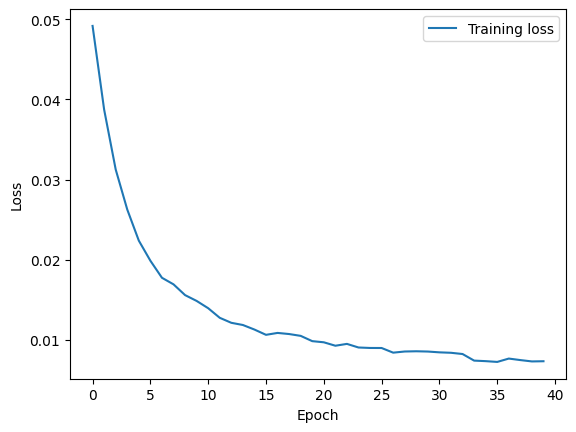

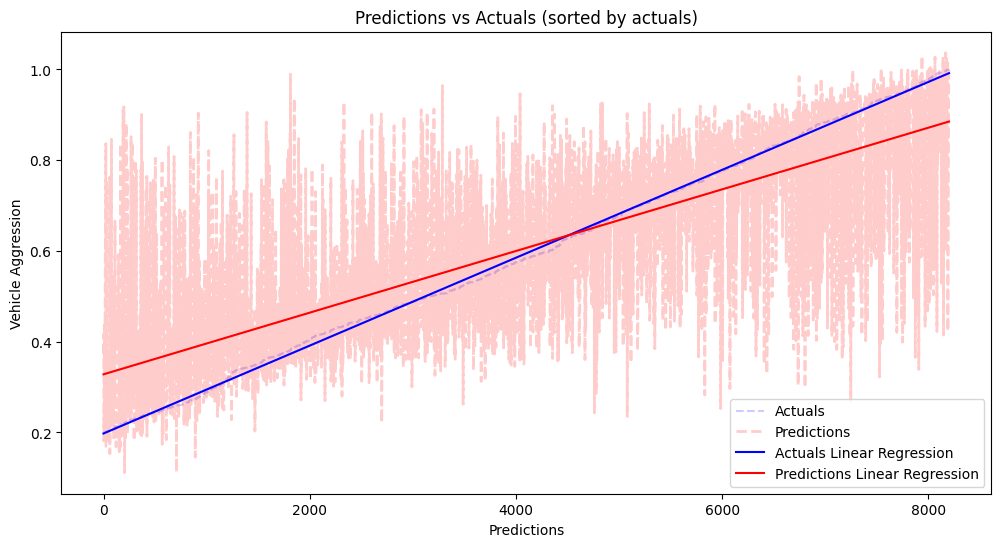

[I 2023-05-21 02:13:31,776] Trial 18 finished with value: 0.018459141669938197 and parameters: {'growth_rate': 10, 'reduction': 0.7422160320831108, 'learning_rate': 0.0002908981213078072, 'nblocks1': 6, 'nblocks2': 13}. Best is trial 18 with value: 0.018459141669938197.


Epoch 0 loss improved from inf to 0.0508!
Epoch 1 loss improved from 0.0508 to 0.0378!
Epoch 2 loss improved from 0.0378 to 0.0300!
Epoch 3 loss improved from 0.0300 to 0.0251!
Epoch 4 loss improved from 0.0251 to 0.0212!
Epoch 5 loss improved from 0.0212 to 0.0189!
Epoch 6 loss improved from 0.0189 to 0.0170!
Epoch 7 loss improved from 0.0170 to 0.0154!
Epoch 8 loss improved from 0.0154 to 0.0144!
Epoch 9 loss did not improve from 0.0144! Remaining epochs: 9
Epoch 10 loss improved from 0.0144 to 0.0132!
Epoch 11 loss did not improve from 0.0132! Remaining epochs: 9
Epoch 12 loss improved from 0.0132 to 0.0121!
Epoch 13 loss did not improve from 0.0121! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0121! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0121! Remaining epochs: 7
Epoch 16 loss improved from 0.0121 to 0.0110!
Epoch 17 loss did not improve from 0.0110! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0110! Remaining epochs: 8
Epoch 19 loss did no

[I 2023-05-21 02:15:17,120] Trial 19 pruned. 


Epoch 0 loss improved from inf to 0.0608!
Epoch 1 loss improved from 0.0608 to 0.0421!
Epoch 2 loss improved from 0.0421 to 0.0361!
Epoch 3 loss improved from 0.0361 to 0.0315!
Epoch 4 loss improved from 0.0315 to 0.0284!
Epoch 5 loss improved from 0.0284 to 0.0258!
Epoch 6 loss improved from 0.0258 to 0.0237!
Epoch 7 loss improved from 0.0237 to 0.0220!
Epoch 8 loss improved from 0.0220 to 0.0206!
Epoch 9 loss improved from 0.0206 to 0.0196!
Epoch 10 loss improved from 0.0196 to 0.0181!
Epoch 11 loss did not improve from 0.0181! Remaining epochs: 9
Epoch 12 loss improved from 0.0181 to 0.0171!
Epoch 13 loss did not improve from 0.0171! Remaining epochs: 9
Epoch 14 loss improved from 0.0171 to 0.0158!
Epoch 15 loss did not improve from 0.0158! Remaining epochs: 9
Epoch 16 loss improved from 0.0158 to 0.0138!
Epoch 17 loss did not improve from 0.0138! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0138! Remaining epochs: 8
Epoch 19 loss improved from 0.0138 to 0.0128!


[I 2023-05-21 02:16:32,825] Trial 20 pruned. 


Epoch 0 loss improved from inf to 0.0533!
Epoch 1 loss improved from 0.0533 to 0.0405!
Epoch 2 loss improved from 0.0405 to 0.0336!
Epoch 3 loss improved from 0.0336 to 0.0285!
Epoch 4 loss improved from 0.0285 to 0.0246!
Epoch 5 loss improved from 0.0246 to 0.0222!
Epoch 6 loss improved from 0.0222 to 0.0198!
Epoch 7 loss improved from 0.0198 to 0.0182!
Epoch 8 loss improved from 0.0182 to 0.0171!
Epoch 9 loss improved from 0.0171 to 0.0159!
Epoch 10 loss did not improve from 0.0159! Remaining epochs: 9
Epoch 11 loss improved from 0.0159 to 0.0147!
Epoch 12 loss did not improve from 0.0147! Remaining epochs: 9
Epoch 13 loss improved from 0.0147 to 0.0135!
Epoch 14 loss did not improve from 0.0135! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0135! Remaining epochs: 8
Epoch 16 loss improved from 0.0135 to 0.0123!
Epoch 17 loss did not improve from 0.0123! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0123! Remaining epochs: 8
Epoch 19 loss improved from 0.0123 to

[I 2023-05-21 02:17:43,311] Trial 21 pruned. 


Epoch 0 loss improved from inf to 0.0494!
Epoch 1 loss improved from 0.0494 to 0.0393!
Epoch 2 loss improved from 0.0393 to 0.0327!
Epoch 3 loss improved from 0.0327 to 0.0277!
Epoch 4 loss improved from 0.0277 to 0.0241!
Epoch 5 loss improved from 0.0241 to 0.0213!
Epoch 6 loss improved from 0.0213 to 0.0192!
Epoch 7 loss improved from 0.0192 to 0.0172!
Epoch 8 loss improved from 0.0172 to 0.0160!
Epoch 9 loss did not improve from 0.0160! Remaining epochs: 9
Epoch 10 loss improved from 0.0160 to 0.0141!
Epoch 11 loss did not improve from 0.0141! Remaining epochs: 9
Epoch 12 loss improved from 0.0141 to 0.0127!
Epoch 13 loss did not improve from 0.0127! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0127! Remaining epochs: 8
Epoch 15 loss improved from 0.0127 to 0.0112!
Epoch 16 loss did not improve from 0.0112! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0112! Remaining epochs: 8
Epoch 18 loss did not improve from 0.0112! Remaining epochs: 7
Epoch 19 loss did no

[I 2023-05-21 02:19:23,933] Trial 22 pruned. 


Epoch 0 loss improved from inf to 0.0509!
Epoch 1 loss improved from 0.0509 to 0.0423!
Epoch 2 loss improved from 0.0423 to 0.0360!
Epoch 3 loss improved from 0.0360 to 0.0310!
Epoch 4 loss improved from 0.0310 to 0.0275!
Epoch 5 loss improved from 0.0275 to 0.0248!
Epoch 6 loss improved from 0.0248 to 0.0226!
Epoch 7 loss improved from 0.0226 to 0.0211!
Epoch 8 loss improved from 0.0211 to 0.0197!
Epoch 9 loss improved from 0.0197 to 0.0185!
Epoch 10 loss improved from 0.0185 to 0.0172!
Epoch 11 loss did not improve from 0.0172! Remaining epochs: 9
Epoch 12 loss improved from 0.0172 to 0.0162!
Epoch 13 loss did not improve from 0.0162! Remaining epochs: 9
Epoch 14 loss improved from 0.0162 to 0.0148!
Epoch 15 loss did not improve from 0.0148! Remaining epochs: 9
Epoch 16 loss improved from 0.0148 to 0.0132!
Epoch 17 loss did not improve from 0.0132! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0132! Remaining epochs: 8
Epoch 19 loss improved from 0.0132 to 0.0117!


[I 2023-05-21 02:20:37,502] Trial 23 pruned. 


Epoch 0 loss improved from inf to 0.0662!
Epoch 1 loss improved from 0.0662 to 0.0437!
Epoch 2 loss improved from 0.0437 to 0.0380!
Epoch 3 loss improved from 0.0380 to 0.0336!
Epoch 4 loss improved from 0.0336 to 0.0297!
Epoch 5 loss improved from 0.0297 to 0.0270!
Epoch 6 loss improved from 0.0270 to 0.0247!
Epoch 7 loss improved from 0.0247 to 0.0230!
Epoch 8 loss improved from 0.0230 to 0.0212!
Epoch 9 loss did not improve from 0.0212! Remaining epochs: 9
Epoch 10 loss improved from 0.0212 to 0.0193!
Epoch 11 loss improved from 0.0193 to 0.0183!
Epoch 12 loss did not improve from 0.0183! Remaining epochs: 9
Epoch 13 loss improved from 0.0183 to 0.0170!
Epoch 14 loss did not improve from 0.0170! Remaining epochs: 9
Epoch 15 loss improved from 0.0170 to 0.0155!
Epoch 16 loss did not improve from 0.0155! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0155! Remaining epochs: 8
Epoch 18 loss did not improve from 0.0155! Remaining epochs: 7
Epoch 19 loss improved from 0.0155 to

[I 2023-05-21 02:21:47,497] Trial 24 pruned. 


Epoch 0 loss improved from inf to 0.0574!
Epoch 1 loss improved from 0.0574 to 0.0423!
Epoch 2 loss improved from 0.0423 to 0.0364!
Epoch 3 loss improved from 0.0364 to 0.0321!
Epoch 4 loss improved from 0.0321 to 0.0285!
Epoch 5 loss improved from 0.0285 to 0.0259!
Epoch 6 loss improved from 0.0259 to 0.0242!
Epoch 7 loss improved from 0.0242 to 0.0222!
Epoch 8 loss improved from 0.0222 to 0.0206!
Epoch 9 loss did not improve from 0.0206! Remaining epochs: 9
Epoch 10 loss improved from 0.0206 to 0.0187!
Epoch 11 loss did not improve from 0.0187! Remaining epochs: 9
Epoch 12 loss improved from 0.0187 to 0.0169!
Epoch 13 loss did not improve from 0.0169! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0169! Remaining epochs: 8
Epoch 15 loss improved from 0.0169 to 0.0151!
Epoch 16 loss did not improve from 0.0151! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0151! Remaining epochs: 8
Epoch 18 loss improved from 0.0151 to 0.0139!
Epoch 19 loss did not improve from 0.

[I 2023-05-21 02:23:04,851] Trial 25 pruned. 


Epoch 0 loss improved from inf to 0.0507!
Epoch 1 loss improved from 0.0507 to 0.0378!
Epoch 2 loss improved from 0.0378 to 0.0308!
Epoch 3 loss improved from 0.0308 to 0.0262!
Epoch 4 loss improved from 0.0262 to 0.0224!
Epoch 5 loss improved from 0.0224 to 0.0199!
Epoch 6 loss improved from 0.0199 to 0.0181!
Epoch 7 loss improved from 0.0181 to 0.0166!
Epoch 8 loss improved from 0.0166 to 0.0154!
Epoch 9 loss did not improve from 0.0154! Remaining epochs: 9
Epoch 10 loss improved from 0.0154 to 0.0140!
Epoch 11 loss did not improve from 0.0140! Remaining epochs: 9
Epoch 12 loss improved from 0.0140 to 0.0126!
Epoch 13 loss did not improve from 0.0126! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0126! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0126! Remaining epochs: 7
Epoch 16 loss improved from 0.0126 to 0.0114!
Epoch 17 loss did not improve from 0.0114! Remaining epochs: 9
Epoch 18 loss improved from 0.0114 to 0.0101!
Epoch 19 loss did not improve from 0.

[I 2023-05-21 02:24:25,746] Trial 26 pruned. 


Epoch 0 loss improved from inf to 0.0545!
Epoch 1 loss improved from 0.0545 to 0.0407!
Epoch 2 loss improved from 0.0407 to 0.0339!
Epoch 3 loss improved from 0.0339 to 0.0289!
Epoch 4 loss improved from 0.0289 to 0.0247!
Epoch 5 loss improved from 0.0247 to 0.0220!
Epoch 6 loss improved from 0.0220 to 0.0200!
Epoch 7 loss improved from 0.0200 to 0.0180!
Epoch 8 loss improved from 0.0180 to 0.0168!
Epoch 9 loss improved from 0.0168 to 0.0157!
Epoch 10 loss did not improve from 0.0157! Remaining epochs: 9
Epoch 11 loss improved from 0.0157 to 0.0145!
Epoch 12 loss did not improve from 0.0145! Remaining epochs: 9
Epoch 13 loss improved from 0.0145 to 0.0133!
Epoch 14 loss did not improve from 0.0133! Remaining epochs: 9
Epoch 15 loss improved from 0.0133 to 0.0121!
Epoch 16 loss did not improve from 0.0121! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0121! Remaining epochs: 8
Epoch 18 loss did not improve from 0.0121! Remaining epochs: 7
Epoch 19 loss improved from 0.0121 to

[I 2023-05-21 02:25:32,473] Trial 27 pruned. 


Epoch 0 loss improved from inf to 0.0511!
Epoch 1 loss improved from 0.0511 to 0.0385!
Epoch 2 loss improved from 0.0385 to 0.0308!
Epoch 3 loss improved from 0.0308 to 0.0255!
Epoch 4 loss improved from 0.0255 to 0.0219!
Epoch 5 loss improved from 0.0219 to 0.0191!
Epoch 6 loss improved from 0.0191 to 0.0174!
Epoch 7 loss improved from 0.0174 to 0.0158!
Epoch 8 loss improved from 0.0158 to 0.0147!
Epoch 9 loss did not improve from 0.0147! Remaining epochs: 9
Epoch 10 loss improved from 0.0147 to 0.0132!
Epoch 11 loss did not improve from 0.0132! Remaining epochs: 9
Epoch 12 loss did not improve from 0.0132! Remaining epochs: 8
Epoch 13 loss improved from 0.0132 to 0.0118!
Epoch 14 loss did not improve from 0.0118! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0118! Remaining epochs: 8
Epoch 16 loss did not improve from 0.0118! Remaining epochs: 7
Epoch 17 loss improved from 0.0118 to 0.0104!
Epoch 18 loss did not improve from 0.0104! Remaining epochs: 9
Epoch 19 loss did no

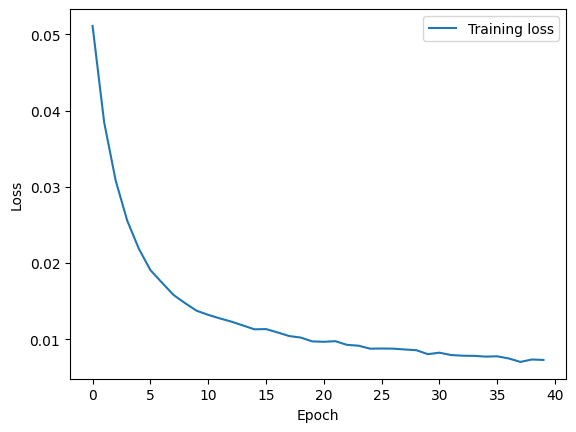

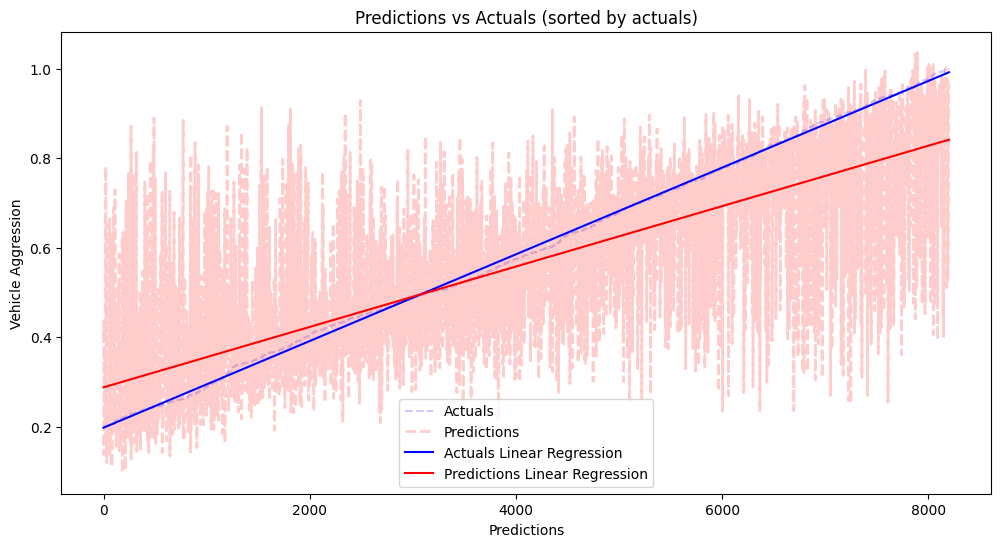

[I 2023-05-21 02:27:59,611] Trial 28 finished with value: 0.019918802738762818 and parameters: {'growth_rate': 11, 'reduction': 0.604523885007636, 'learning_rate': 0.0001740842189470636, 'nblocks1': 5, 'nblocks2': 15}. Best is trial 18 with value: 0.018459141669938197.


Epoch 0 loss improved from inf to 0.0985!
Epoch 1 loss improved from 0.0985 to 0.0471!
Epoch 2 loss improved from 0.0471 to 0.0419!
Epoch 3 loss improved from 0.0419 to 0.0362!
Epoch 4 loss improved from 0.0362 to 0.0316!
Epoch 5 loss improved from 0.0316 to 0.0276!
Epoch 6 loss improved from 0.0276 to 0.0246!
Epoch 7 loss improved from 0.0246 to 0.0224!
Epoch 8 loss improved from 0.0224 to 0.0208!
Epoch 9 loss improved from 0.0208 to 0.0194!
Epoch 10 loss improved from 0.0194 to 0.0179!
Epoch 11 loss did not improve from 0.0179! Remaining epochs: 9
Epoch 12 loss improved from 0.0179 to 0.0163!
Epoch 13 loss did not improve from 0.0163! Remaining epochs: 9
Epoch 14 loss improved from 0.0163 to 0.0151!
Epoch 15 loss did not improve from 0.0151! Remaining epochs: 9
Epoch 16 loss improved from 0.0151 to 0.0139!
Epoch 17 loss did not improve from 0.0139! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0139! Remaining epochs: 8
Epoch 19 loss improved from 0.0139 to 0.0128!


[I 2023-05-21 02:28:52,375] Trial 29 pruned. 


Epoch 0 loss improved from inf to 0.0600!
Epoch 1 loss improved from 0.0600 to 0.0435!
Epoch 2 loss improved from 0.0435 to 0.0382!
Epoch 3 loss improved from 0.0382 to 0.0339!
Epoch 4 loss improved from 0.0339 to 0.0306!
Epoch 5 loss improved from 0.0306 to 0.0280!
Epoch 6 loss improved from 0.0280 to 0.0255!
Epoch 7 loss improved from 0.0255 to 0.0237!
Epoch 8 loss improved from 0.0237 to 0.0224!
Epoch 9 loss improved from 0.0224 to 0.0211!
Epoch 10 loss improved from 0.0211 to 0.0199!
Epoch 11 loss improved from 0.0199 to 0.0189!
Epoch 12 loss did not improve from 0.0189! Remaining epochs: 9
Epoch 13 loss improved from 0.0189 to 0.0174!
Epoch 14 loss did not improve from 0.0174! Remaining epochs: 9
Epoch 15 loss improved from 0.0174 to 0.0161!
Epoch 16 loss did not improve from 0.0161! Remaining epochs: 9
Epoch 17 loss improved from 0.0161 to 0.0150!
Epoch 18 loss did not improve from 0.0150! Remaining epochs: 9
Epoch 19 loss did not improve from 0.0150! Remaining epochs: 8


[I 2023-05-21 02:29:59,636] Trial 30 pruned. 


Epoch 0 loss improved from inf to 0.0578!
Epoch 1 loss improved from 0.0578 to 0.0386!
Epoch 2 loss improved from 0.0386 to 0.0304!
Epoch 3 loss improved from 0.0304 to 0.0243!
Epoch 4 loss improved from 0.0243 to 0.0201!
Epoch 5 loss improved from 0.0201 to 0.0178!
Epoch 6 loss improved from 0.0178 to 0.0158!
Epoch 7 loss improved from 0.0158 to 0.0145!
Epoch 8 loss improved from 0.0145 to 0.0134!
Epoch 9 loss did not improve from 0.0134! Remaining epochs: 9
Epoch 10 loss improved from 0.0134 to 0.0124!
Epoch 11 loss did not improve from 0.0124! Remaining epochs: 9
Epoch 12 loss did not improve from 0.0124! Remaining epochs: 8
Epoch 13 loss improved from 0.0124 to 0.0112!
Epoch 14 loss did not improve from 0.0112! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0112! Remaining epochs: 8
Epoch 16 loss did not improve from 0.0112! Remaining epochs: 7
Epoch 17 loss improved from 0.0112 to 0.0099!
Epoch 18 loss did not improve from 0.0099! Remaining epochs: 9
Epoch 19 loss did no

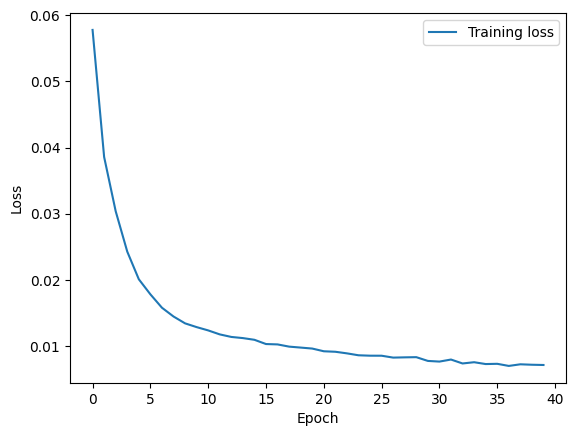

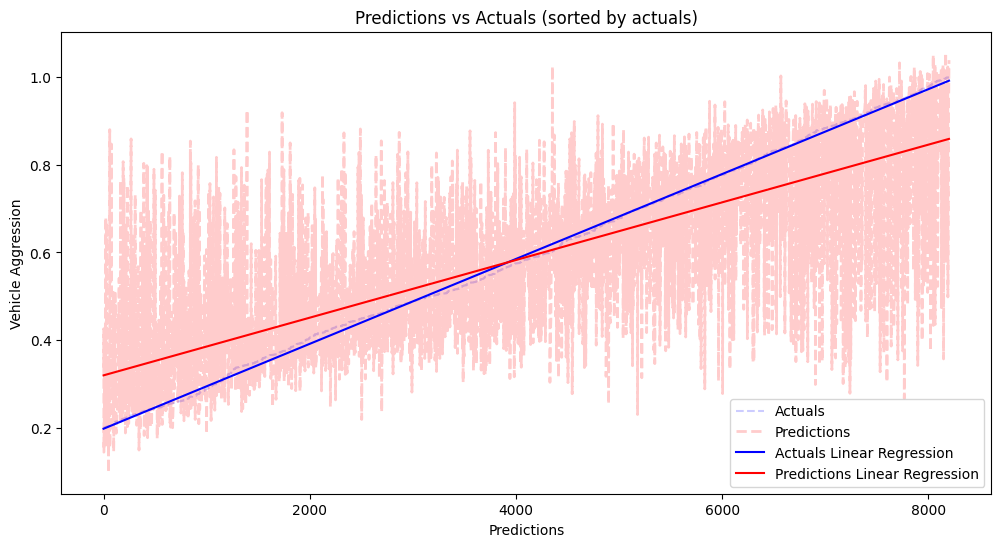

[I 2023-05-21 02:32:12,537] Trial 31 finished with value: 0.019318195418096505 and parameters: {'growth_rate': 11, 'reduction': 0.6297790726090541, 'learning_rate': 0.0001531997376249611, 'nblocks1': 7, 'nblocks2': 11}. Best is trial 18 with value: 0.018459141669938197.


Epoch 0 loss improved from inf to 0.0564!
Epoch 1 loss improved from 0.0564 to 0.0378!
Epoch 2 loss improved from 0.0378 to 0.0298!
Epoch 3 loss improved from 0.0298 to 0.0244!
Epoch 4 loss improved from 0.0244 to 0.0208!
Epoch 5 loss improved from 0.0208 to 0.0183!
Epoch 6 loss improved from 0.0183 to 0.0164!
Epoch 7 loss improved from 0.0164 to 0.0154!
Epoch 8 loss improved from 0.0154 to 0.0142!
Epoch 9 loss did not improve from 0.0142! Remaining epochs: 9
Epoch 10 loss improved from 0.0142 to 0.0125!
Epoch 11 loss did not improve from 0.0125! Remaining epochs: 9
Epoch 12 loss did not improve from 0.0125! Remaining epochs: 8
Epoch 13 loss improved from 0.0125 to 0.0115!
Epoch 14 loss did not improve from 0.0115! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0115! Remaining epochs: 8
Epoch 16 loss did not improve from 0.0115! Remaining epochs: 7
Epoch 17 loss improved from 0.0115 to 0.0104!
Epoch 18 loss did not improve from 0.0104! Remaining epochs: 9
Epoch 19 loss did no

[I 2023-05-21 02:33:19,908] Trial 32 pruned. 


Epoch 0 loss improved from inf to 0.0488!
Epoch 1 loss improved from 0.0488 to 0.0394!
Epoch 2 loss improved from 0.0394 to 0.0319!
Epoch 3 loss improved from 0.0319 to 0.0268!
Epoch 4 loss improved from 0.0268 to 0.0231!
Epoch 5 loss improved from 0.0231 to 0.0206!
Epoch 6 loss improved from 0.0206 to 0.0184!
Epoch 7 loss improved from 0.0184 to 0.0170!
Epoch 8 loss improved from 0.0170 to 0.0158!
Epoch 9 loss did not improve from 0.0158! Remaining epochs: 9
Epoch 10 loss improved from 0.0158 to 0.0143!
Epoch 11 loss did not improve from 0.0143! Remaining epochs: 9
Epoch 12 loss improved from 0.0143 to 0.0133!
Epoch 13 loss did not improve from 0.0133! Remaining epochs: 9
Epoch 14 loss improved from 0.0133 to 0.0121!
Epoch 15 loss did not improve from 0.0121! Remaining epochs: 9
Epoch 16 loss did not improve from 0.0121! Remaining epochs: 8
Epoch 17 loss did not improve from 0.0121! Remaining epochs: 7
Epoch 18 loss improved from 0.0121 to 0.0111!
Epoch 19 loss did not improve from 0.

[I 2023-05-21 02:34:26,156] Trial 33 pruned. 


Epoch 0 loss improved from inf to 0.0520!
Epoch 1 loss improved from 0.0520 to 0.0401!
Epoch 2 loss improved from 0.0401 to 0.0332!
Epoch 3 loss improved from 0.0332 to 0.0280!
Epoch 4 loss improved from 0.0280 to 0.0247!
Epoch 5 loss improved from 0.0247 to 0.0219!
Epoch 6 loss improved from 0.0219 to 0.0198!
Epoch 7 loss improved from 0.0198 to 0.0184!
Epoch 8 loss improved from 0.0184 to 0.0168!
Epoch 9 loss did not improve from 0.0168! Remaining epochs: 9
Epoch 10 loss improved from 0.0168 to 0.0150!
Epoch 11 loss did not improve from 0.0150! Remaining epochs: 9
Epoch 12 loss improved from 0.0150 to 0.0139!
Epoch 13 loss did not improve from 0.0139! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0139! Remaining epochs: 8
Epoch 15 loss improved from 0.0139 to 0.0118!
Epoch 16 loss did not improve from 0.0118! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0118! Remaining epochs: 8
Epoch 18 loss improved from 0.0118 to 0.0107!
Epoch 19 loss did not improve from 0.

[I 2023-05-21 02:35:46,581] Trial 34 pruned. 


Epoch 0 loss improved from inf to 0.0597!
Epoch 1 loss improved from 0.0597 to 0.0394!
Epoch 2 loss improved from 0.0394 to 0.0313!
Epoch 3 loss improved from 0.0313 to 0.0253!
Epoch 4 loss improved from 0.0253 to 0.0213!
Epoch 5 loss improved from 0.0213 to 0.0183!
Epoch 6 loss improved from 0.0183 to 0.0166!
Epoch 7 loss improved from 0.0166 to 0.0150!
Epoch 8 loss improved from 0.0150 to 0.0138!
Epoch 9 loss did not improve from 0.0138! Remaining epochs: 9
Epoch 10 loss improved from 0.0138 to 0.0124!
Epoch 11 loss did not improve from 0.0124! Remaining epochs: 9
Epoch 12 loss did not improve from 0.0124! Remaining epochs: 8
Epoch 13 loss improved from 0.0124 to 0.0111!
Epoch 14 loss did not improve from 0.0111! Remaining epochs: 9
Epoch 15 loss did not improve from 0.0111! Remaining epochs: 8
Epoch 16 loss did not improve from 0.0111! Remaining epochs: 7
Epoch 17 loss improved from 0.0111 to 0.0099!
Epoch 18 loss did not improve from 0.0099! Remaining epochs: 9
Epoch 19 loss did no

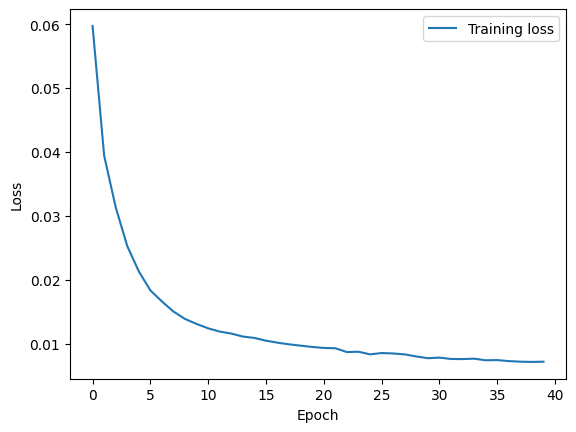

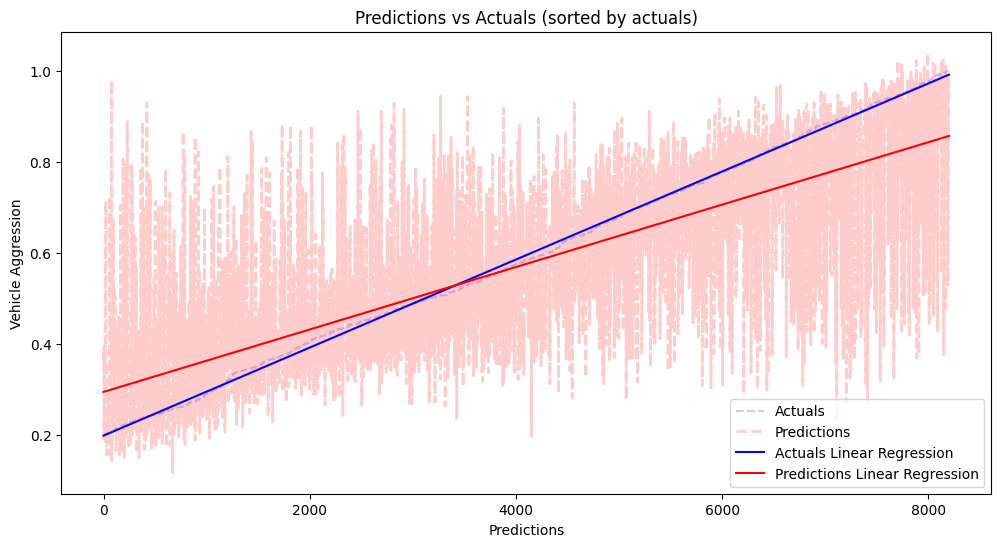

[I 2023-05-21 02:37:53,695] Trial 35 finished with value: 0.019253614745461025 and parameters: {'growth_rate': 11, 'reduction': 0.6363932375876982, 'learning_rate': 0.00010230964584905935, 'nblocks1': 7, 'nblocks2': 10}. Best is trial 18 with value: 0.018459141669938197.


Epoch 0 loss improved from inf to 0.0896!
Epoch 1 loss improved from 0.0896 to 0.0448!
Epoch 2 loss improved from 0.0448 to 0.0369!
Epoch 3 loss improved from 0.0369 to 0.0301!
Epoch 4 loss improved from 0.0301 to 0.0245!
Epoch 5 loss improved from 0.0245 to 0.0209!
Epoch 6 loss improved from 0.0209 to 0.0182!
Epoch 7 loss improved from 0.0182 to 0.0167!
Epoch 8 loss improved from 0.0167 to 0.0152!
Epoch 9 loss did not improve from 0.0152! Remaining epochs: 9
Epoch 10 loss improved from 0.0152 to 0.0135!
Epoch 11 loss did not improve from 0.0135! Remaining epochs: 9
Epoch 12 loss improved from 0.0135 to 0.0120!
Epoch 13 loss did not improve from 0.0120! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0120! Remaining epochs: 8
Epoch 15 loss improved from 0.0120 to 0.0110!
Epoch 16 loss did not improve from 0.0110! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0110! Remaining epochs: 8
Epoch 18 loss did not improve from 0.0110! Remaining epochs: 7
Epoch 19 loss did no

[I 2023-05-21 02:39:00,275] Trial 36 pruned. 


Epoch 0 loss improved from inf to 0.0523!
Epoch 1 loss improved from 0.0523 to 0.0365!
Epoch 2 loss improved from 0.0365 to 0.0282!
Epoch 3 loss improved from 0.0282 to 0.0226!
Epoch 4 loss improved from 0.0226 to 0.0194!
Epoch 5 loss improved from 0.0194 to 0.0173!
Epoch 6 loss improved from 0.0173 to 0.0151!
Epoch 7 loss improved from 0.0151 to 0.0140!
Epoch 8 loss did not improve from 0.0140! Remaining epochs: 9
Epoch 9 loss improved from 0.0140 to 0.0124!
Epoch 10 loss did not improve from 0.0124! Remaining epochs: 9
Epoch 11 loss did not improve from 0.0124! Remaining epochs: 8
Epoch 12 loss improved from 0.0124 to 0.0113!
Epoch 13 loss did not improve from 0.0113! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0113! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0113! Remaining epochs: 7
Epoch 16 loss improved from 0.0113 to 0.0102!
Epoch 17 loss did not improve from 0.0102! Remaining epochs: 9
Epoch 18 loss did not improve from 0.0102! Remaining epochs: 8
Epo

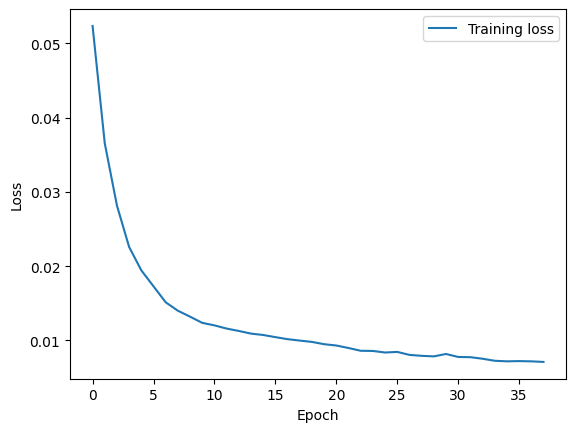

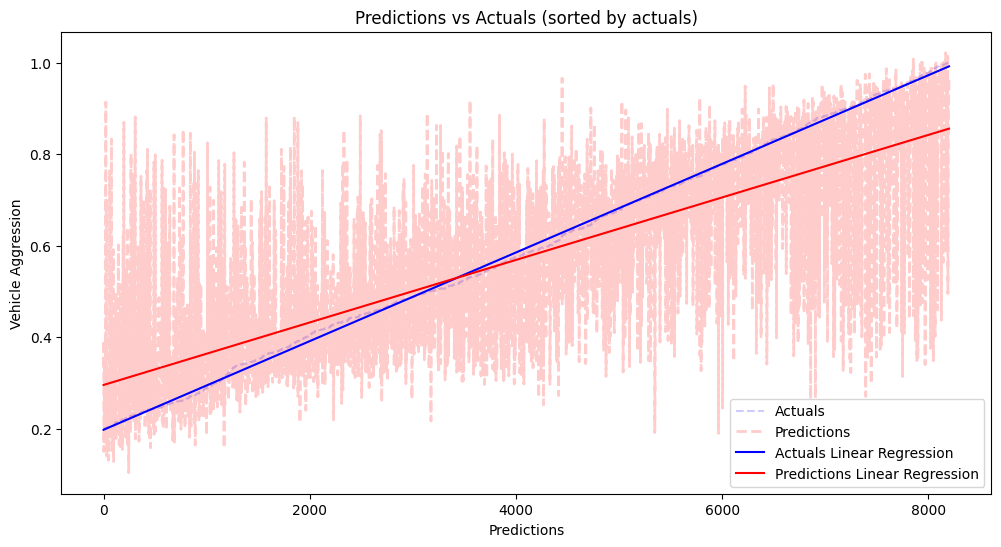

[I 2023-05-21 02:40:56,140] Trial 37 finished with value: 0.018388975626574114 and parameters: {'growth_rate': 12, 'reduction': 0.6421128649175839, 'learning_rate': 0.00015568529234203575, 'nblocks1': 8, 'nblocks2': 9}. Best is trial 37 with value: 0.018388975626574114.


Epoch 0 loss improved from inf to 0.0655!
Epoch 1 loss improved from 0.0655 to 0.0387!
Epoch 2 loss improved from 0.0387 to 0.0303!
Epoch 3 loss improved from 0.0303 to 0.0241!
Epoch 4 loss improved from 0.0241 to 0.0204!
Epoch 5 loss improved from 0.0204 to 0.0177!
Epoch 6 loss improved from 0.0177 to 0.0159!
Epoch 7 loss improved from 0.0159 to 0.0145!
Epoch 8 loss did not improve from 0.0145! Remaining epochs: 9
Epoch 9 loss improved from 0.0145 to 0.0128!
Epoch 10 loss did not improve from 0.0128! Remaining epochs: 9
Epoch 11 loss did not improve from 0.0128! Remaining epochs: 8
Epoch 12 loss improved from 0.0128 to 0.0113!
Epoch 13 loss did not improve from 0.0113! Remaining epochs: 9
Epoch 14 loss did not improve from 0.0113! Remaining epochs: 8
Epoch 15 loss did not improve from 0.0113! Remaining epochs: 7
Epoch 16 loss did not improve from 0.0113! Remaining epochs: 6
Epoch 17 loss improved from 0.0113 to 0.0101!
Epoch 18 loss did not improve from 0.0101! Remaining epochs: 9
Epo

[I 2023-05-21 02:42:01,284] Trial 38 pruned. 


Epoch 0 loss improved from inf to 0.0603!
Epoch 1 loss improved from 0.0603 to 0.0388!
Epoch 2 loss improved from 0.0388 to 0.0296!
Epoch 3 loss improved from 0.0296 to 0.0235!
Epoch 4 loss improved from 0.0235 to 0.0196!
Epoch 5 loss improved from 0.0196 to 0.0167!
Epoch 6 loss improved from 0.0167 to 0.0150!
Epoch 7 loss improved from 0.0150 to 0.0138!
Epoch 8 loss did not improve from 0.0138! Remaining epochs: 9
Epoch 9 loss improved from 0.0138 to 0.0124!
Epoch 10 loss did not improve from 0.0124! Remaining epochs: 9
Epoch 11 loss improved from 0.0124 to 0.0111!
Epoch 12 loss did not improve from 0.0111! Remaining epochs: 9
Epoch 13 loss did not improve from 0.0111! Remaining epochs: 8
Epoch 14 loss did not improve from 0.0111! Remaining epochs: 7
Epoch 15 loss improved from 0.0111 to 0.0099!
Epoch 16 loss did not improve from 0.0099! Remaining epochs: 9
Epoch 17 loss did not improve from 0.0099! Remaining epochs: 8
Epoch 18 loss did not improve from 0.0099! Remaining epochs: 7
Epo

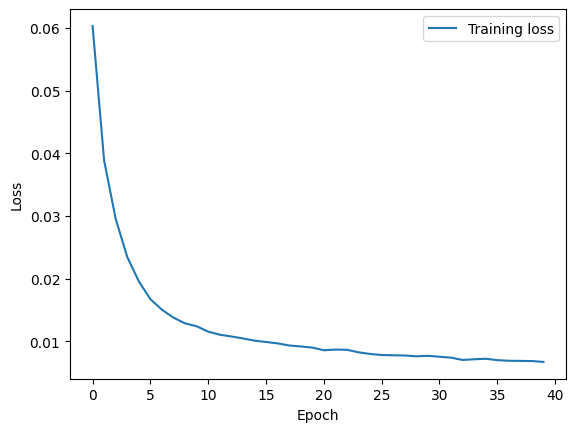

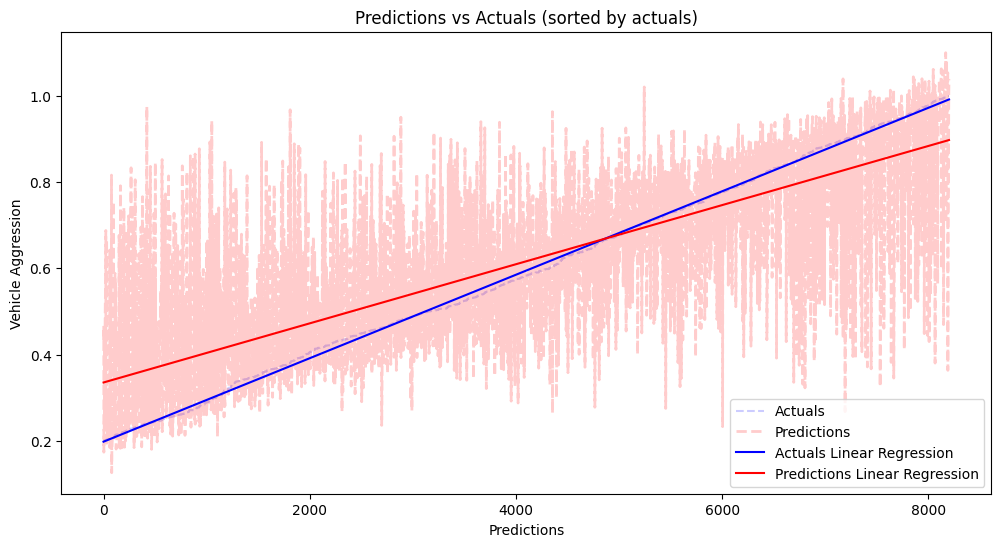

[I 2023-05-21 02:44:09,694] Trial 39 finished with value: 0.018891871605928128 and parameters: {'growth_rate': 12, 'reduction': 0.7104655409497707, 'learning_rate': 0.00010090695974352123, 'nblocks1': 8, 'nblocks2': 10}. Best is trial 37 with value: 0.018388975626574114.
[I 2023-05-21 02:44:09,720] A new study created in memory with name: no-name-f3ae039c-0da6-4ca1-b515-e4388299541f


Best trial 1:
	Value: 0.018388975626574114
	Params: {'growth_rate': 12, 'reduction': 0.6421128649175839, 'learning_rate': 0.00015568529234203575, 'nblocks1': 8, 'nblocks2': 9}
Best trial 2:
	Value: 0.018459141669938197
	Params: {'growth_rate': 10, 'reduction': 0.7422160320831108, 'learning_rate': 0.0002908981213078072, 'nblocks1': 6, 'nblocks2': 13}
Best trial 3:
	Value: 0.018891871605928128
	Params: {'growth_rate': 12, 'reduction': 0.7104655409497707, 'learning_rate': 0.00010090695974352123, 'nblocks1': 8, 'nblocks2': 10}
Best trial 4:
	Value: 0.019253614745461025
	Params: {'growth_rate': 11, 'reduction': 0.6363932375876982, 'learning_rate': 0.00010230964584905935, 'nblocks1': 7, 'nblocks2': 10}
Best trial 5:
	Value: 0.019318195418096505
	Params: {'growth_rate': 11, 'reduction': 0.6297790726090541, 'learning_rate': 0.0001531997376249611, 'nblocks1': 7, 'nblocks2': 11}
X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4585!
Epoch 1 loss improved from 0.4585 to 0.4113!

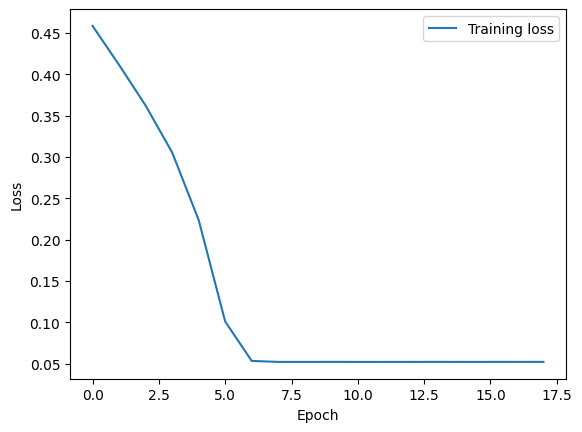

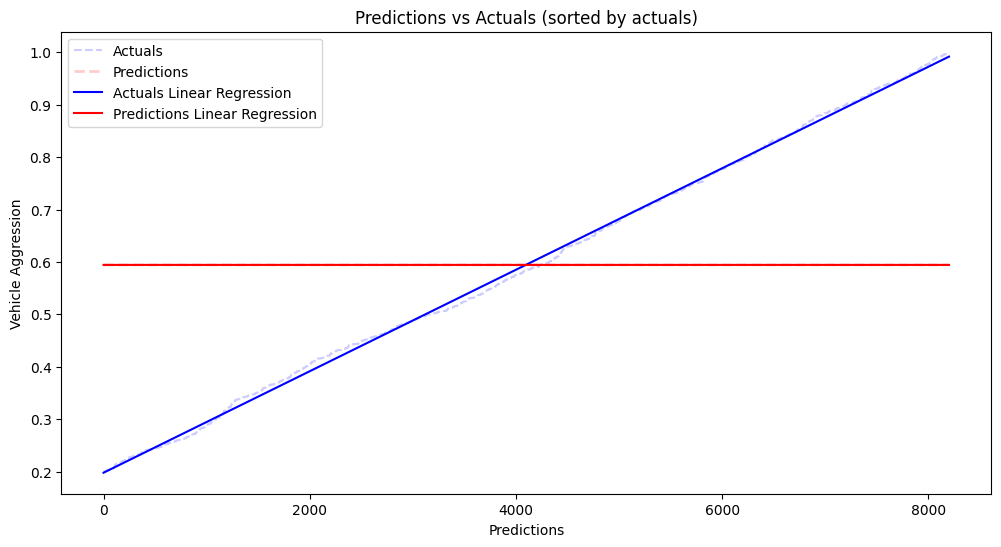

[I 2023-05-21 02:44:32,566] Trial 0 finished with value: 0.05286414479980102 and parameters: {}. Best is trial 0 with value: 0.05286414479980102.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4308!
Epoch 1 loss improved from 0.4308 to 0.3842!
Epoch 2 loss improved from 0.3842 to 0.3275!
Epoch 3 loss improved from 0.3275 to 0.2369!
Epoch 4 loss improved from 0.2369 to 0.0972!
Epoch 5 loss improved from 0.0972 to 0.0539!
Epoch 6 loss improved from 0.0539 to 0.0520!
Epoch 7 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 0
Early stopping!


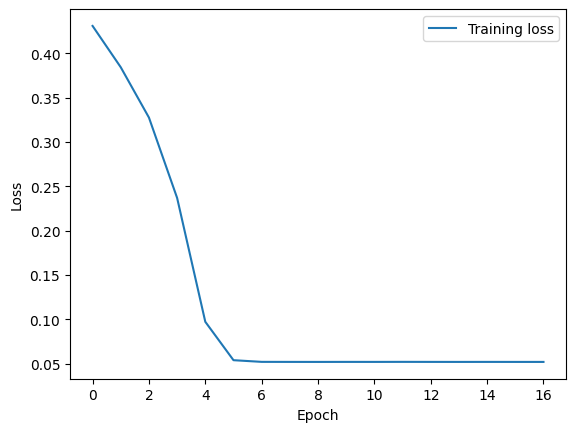

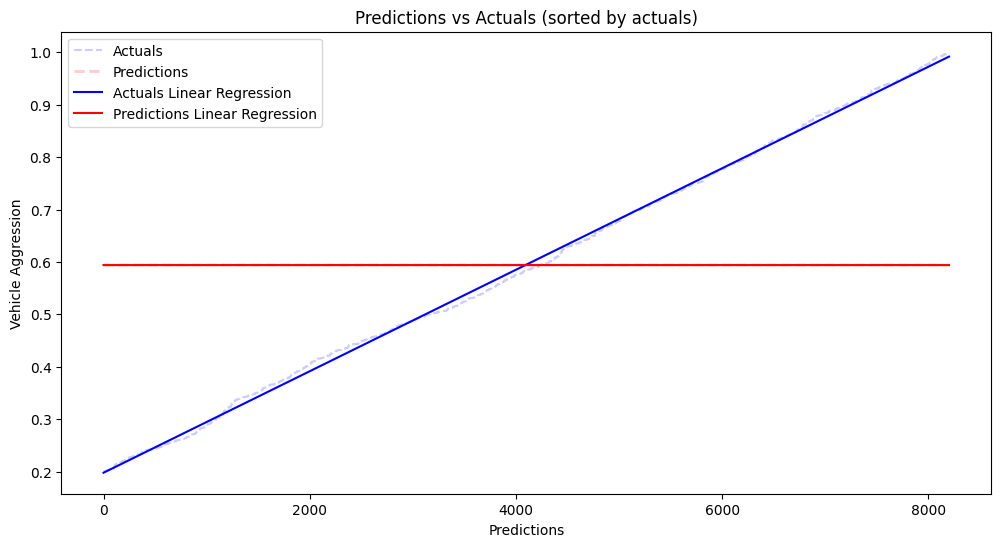

[I 2023-05-21 02:44:54,151] Trial 1 finished with value: 0.0528649688913272 and parameters: {}. Best is trial 0 with value: 0.05286414479980102.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5905!
Epoch 1 loss improved from 0.5905 to 0.5336!
Epoch 2 loss improved from 0.5336 to 0.4690!
Epoch 3 loss improved from 0.4690 to 0.3860!
Epoch 4 loss improved from 0.3860 to 0.2506!
Epoch 5 loss improved from 0.2506 to 0.0878!
Epoch 6 loss improved from 0.0878 to 0.0527!
Epoch 7 loss did not improve from 0.0527! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0527! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0527! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0527! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0527! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0527! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0527! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0527! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0527! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0527! Remaining epochs: 0
Early stopping!


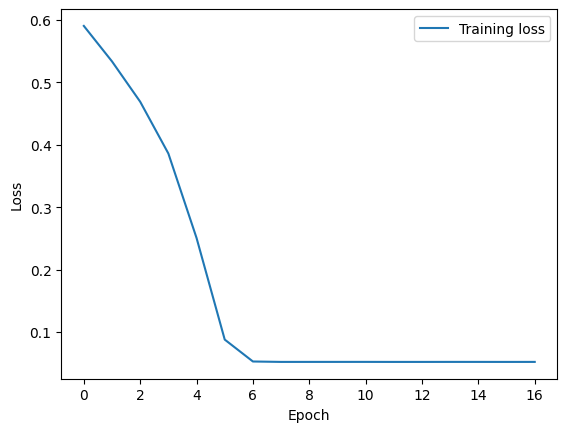

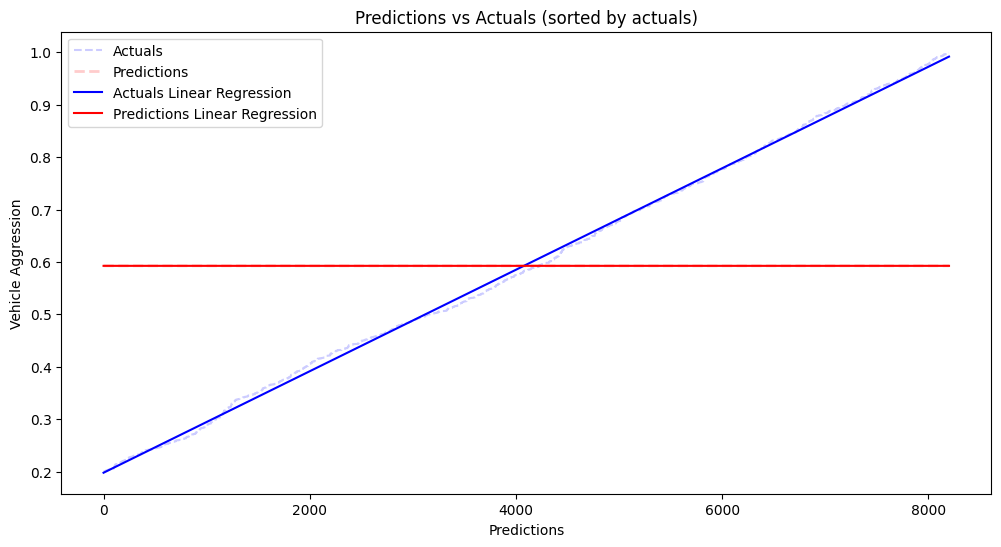

[I 2023-05-21 02:45:15,206] Trial 2 finished with value: 0.05287325152984032 and parameters: {}. Best is trial 0 with value: 0.05286414479980102.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4147!
Epoch 1 loss improved from 0.4147 to 0.3698!
Epoch 2 loss improved from 0.3698 to 0.3203!
Epoch 3 loss improved from 0.3203 to 0.2492!
Epoch 4 loss improved from 0.2492 to 0.1279!
Epoch 5 loss improved from 0.1279 to 0.0576!
Epoch 6 loss improved from 0.0576 to 0.0521!
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


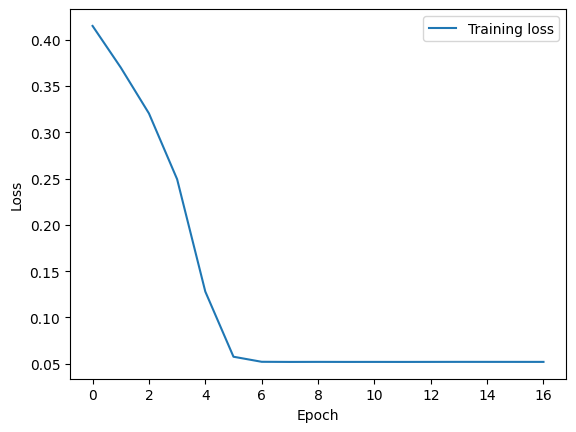

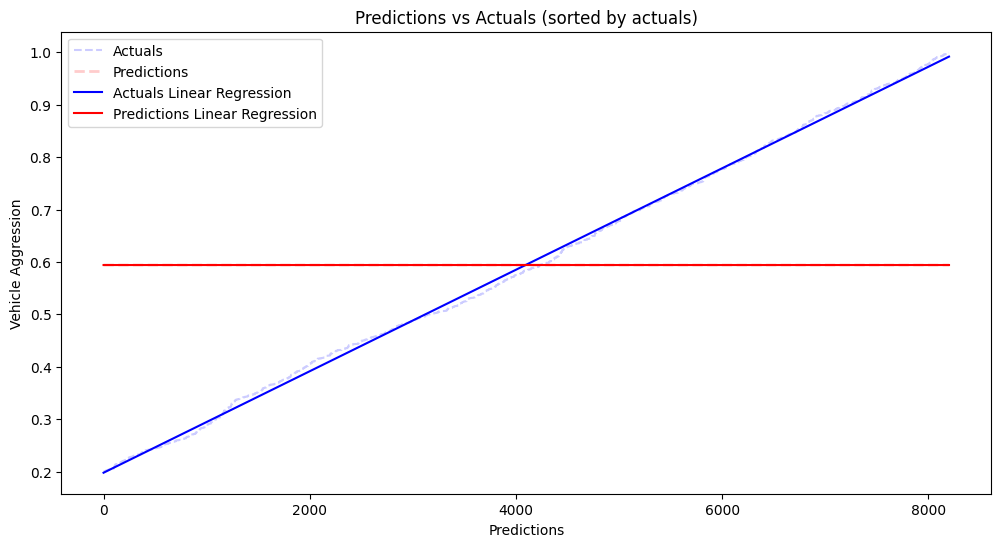

[I 2023-05-21 02:45:36,902] Trial 3 finished with value: 0.05286471241941819 and parameters: {}. Best is trial 0 with value: 0.05286414479980102.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2474!
Epoch 1 loss improved from 0.2474 to 0.2219!
Epoch 2 loss improved from 0.2219 to 0.1934!
Epoch 3 loss improved from 0.1934 to 0.1559!
Epoch 4 loss improved from 0.1559 to 0.0932!
Epoch 5 loss improved from 0.0932 to 0.0529!
Epoch 6 loss did not improve from 0.0529! Remaining epochs: 9
Epoch 7 loss did not improve from 0.0529! Remaining epochs: 8
Epoch 8 loss did not improve from 0.0529! Remaining epochs: 7
Epoch 9 loss did not improve from 0.0529! Remaining epochs: 6
Epoch 10 loss did not improve from 0.0529! Remaining epochs: 5
Epoch 11 loss did not improve from 0.0529! Remaining epochs: 4
Epoch 12 loss did not improve from 0.0529! Remaining epochs: 3
Epoch 13 loss did not improve from 0.0529! Remaining epochs: 2
Epoch 14 loss did not improve from 0.0529! Remaining epochs: 1
Epoch 15 loss did not improve from 0.0529! Remaining epochs: 0
Early stopping!


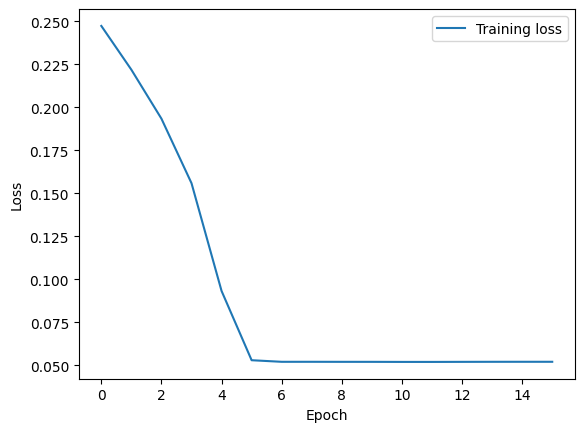

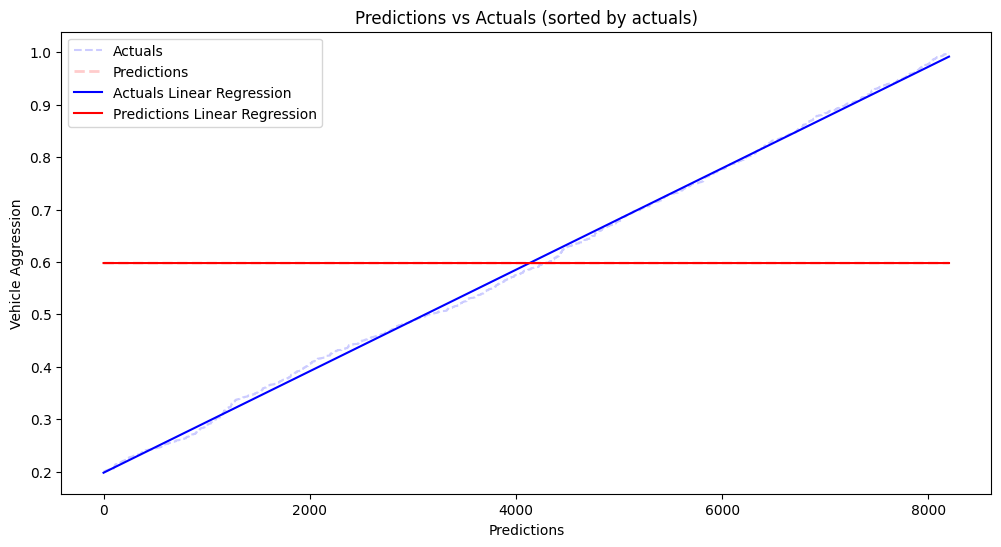

[I 2023-05-21 02:45:57,122] Trial 4 finished with value: 0.05286335119834313 and parameters: {}. Best is trial 4 with value: 0.05286335119834313.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4322!
Epoch 1 loss improved from 0.4322 to 0.3977!
Epoch 2 loss improved from 0.3977 to 0.3566!
Epoch 3 loss improved from 0.3566 to 0.2906!
Epoch 4 loss improved from 0.2906 to 0.1636!
Epoch 5 loss improved from 0.1636 to 0.0689!
Epoch 6 loss improved from 0.0689 to 0.0525!
Epoch 7 loss did not improve from 0.0525! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0525! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0525! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0525! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0525! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0525! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0525! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0525! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0525! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0525! Remaining epochs: 0
Early stopping!


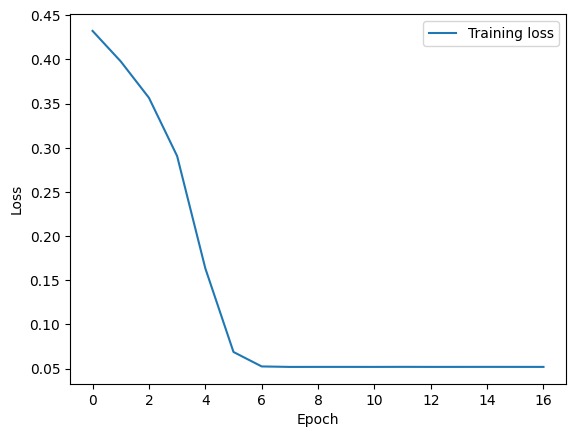

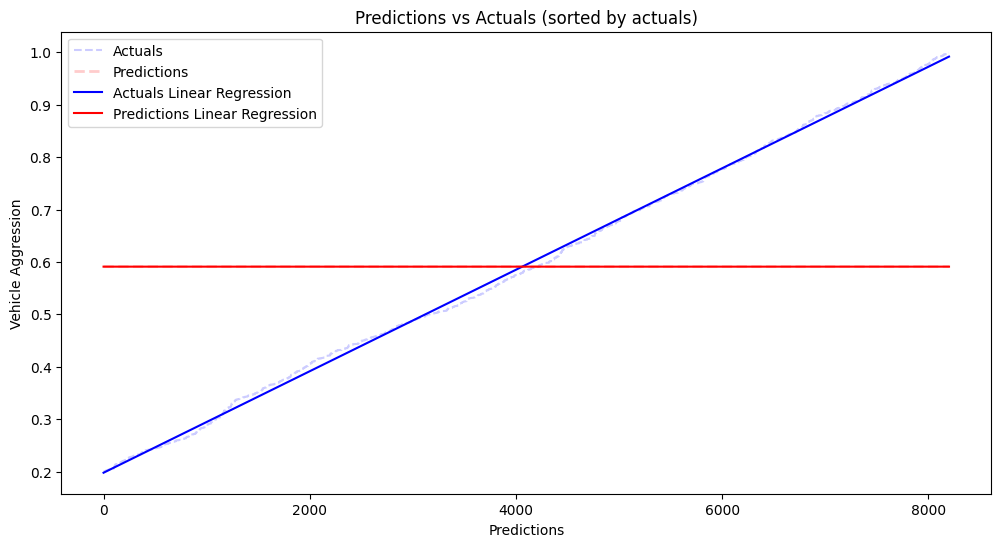

[I 2023-05-21 02:46:18,768] Trial 5 finished with value: 0.05288727449683043 and parameters: {}. Best is trial 4 with value: 0.05286335119834313.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5133!
Epoch 1 loss improved from 0.5133 to 0.4634!
Epoch 2 loss improved from 0.4634 to 0.4089!
Epoch 3 loss improved from 0.4089 to 0.3333!
Epoch 4 loss improved from 0.3333 to 0.2035!
Epoch 5 loss improved from 0.2035 to 0.0885!
Epoch 6 loss improved from 0.0885 to 0.0547!
Epoch 7 loss improved from 0.0547 to 0.0520!
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0520! Rem

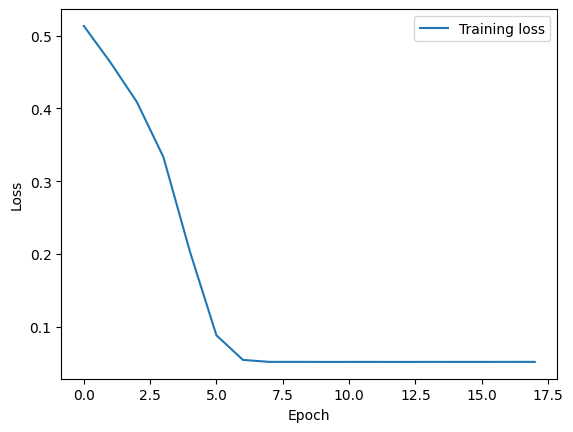

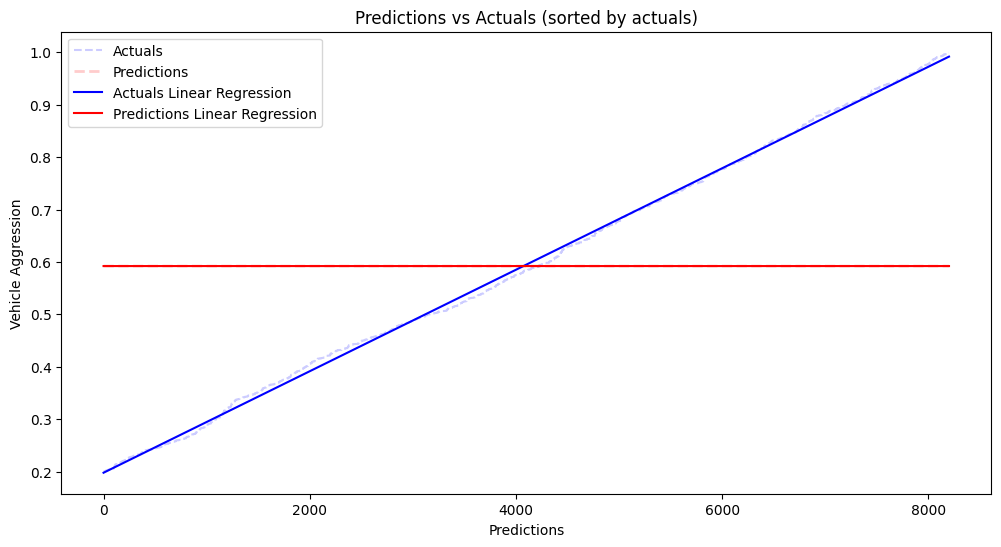

[I 2023-05-21 02:46:41,781] Trial 6 finished with value: 0.05287683508717097 and parameters: {}. Best is trial 4 with value: 0.05286335119834313.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2738!
Epoch 1 loss improved from 0.2738 to 0.2429!
Epoch 2 loss improved from 0.2429 to 0.2055!
Epoch 3 loss improved from 0.2055 to 0.1523!
Epoch 4 loss improved from 0.1523 to 0.0803!
Epoch 5 loss improved from 0.0803 to 0.0526!
Epoch 6 loss did not improve from 0.0526! Remaining epochs: 9
Epoch 7 loss did not improve from 0.0526! Remaining epochs: 8
Epoch 8 loss did not improve from 0.0526! Remaining epochs: 7
Epoch 9 loss did not improve from 0.0526! Remaining epochs: 6
Epoch 10 loss did not improve from 0.0526! Remaining epochs: 5
Epoch 11 loss did not improve from 0.0526! Remaining epochs: 4
Epoch 12 loss did not improve from 0.0526! Remaining epochs: 3
Epoch 13 loss did not improve from 0.0526! Remaining epochs: 2
Epoch 14 loss did not improve from 0.0526! Remaining epochs: 1
Epoch 15 loss did not improve from 0.0526! Remaining epochs: 0
Early stopping!


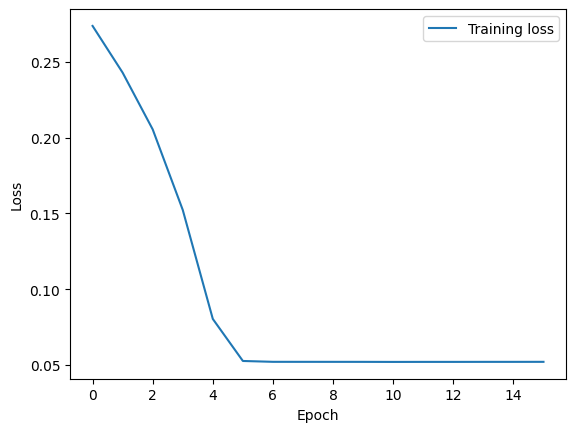

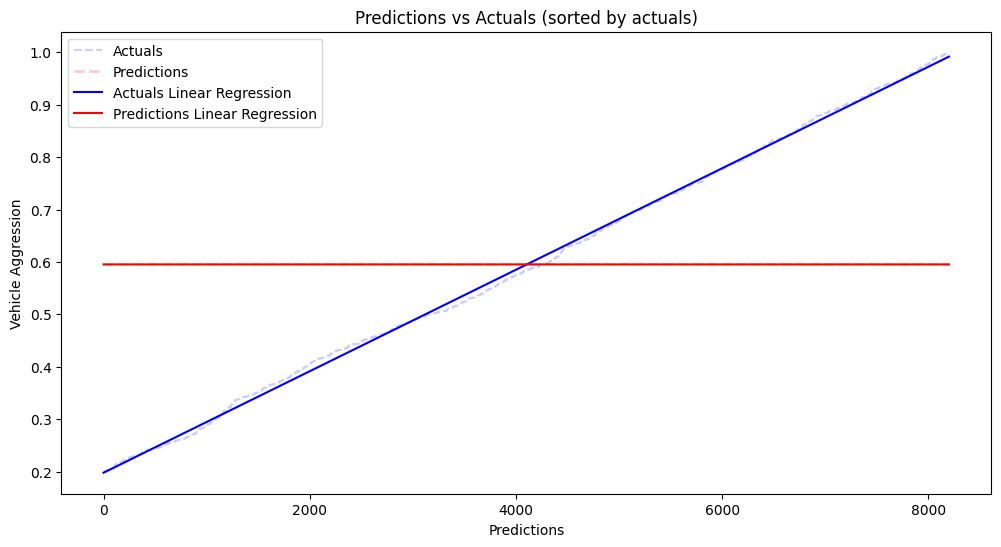

[I 2023-05-21 02:47:02,215] Trial 7 finished with value: 0.052861303434922145 and parameters: {}. Best is trial 7 with value: 0.052861303434922145.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2048!
Epoch 1 loss improved from 0.2048 to 0.1765!
Epoch 2 loss improved from 0.1765 to 0.1469!
Epoch 3 loss improved from 0.1469 to 0.1062!
Epoch 4 loss improved from 0.1062 to 0.0622!
Epoch 5 loss improved from 0.0622 to 0.0521!
Epoch 6 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


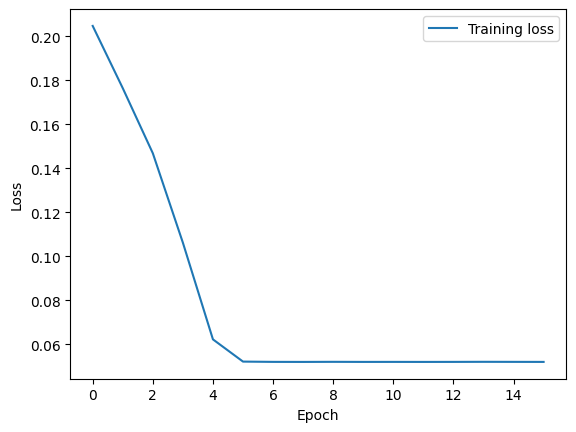

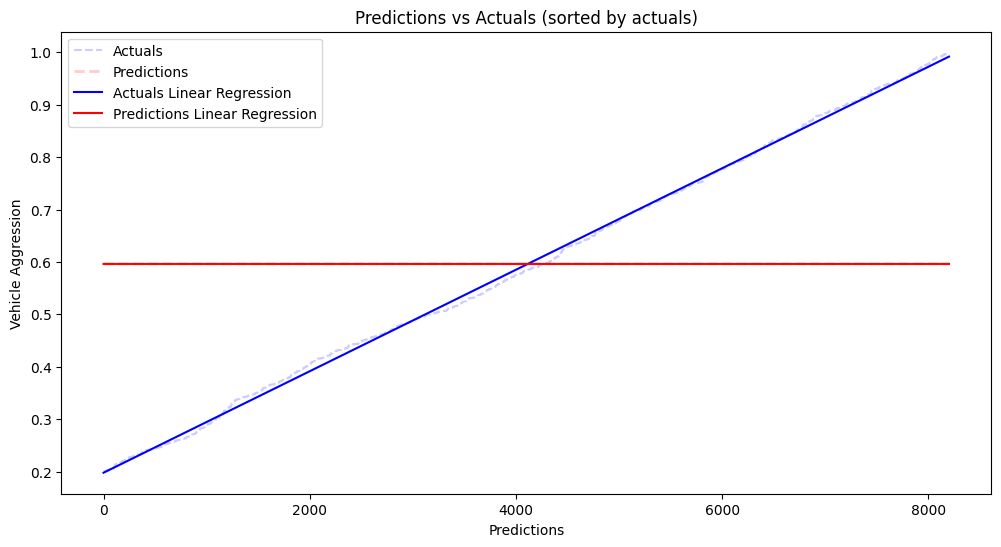

[I 2023-05-21 02:47:22,705] Trial 8 finished with value: 0.05286070538254885 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3919!
Epoch 1 loss improved from 0.3919 to 0.3442!
Epoch 2 loss improved from 0.3442 to 0.2889!
Epoch 3 loss improved from 0.2889 to 0.2154!
Epoch 4 loss improved from 0.2154 to 0.1068!
Epoch 5 loss improved from 0.1068 to 0.0539!
Epoch 6 loss improved from 0.0539 to 0.0520!
Epoch 7 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 0
Early stopping!


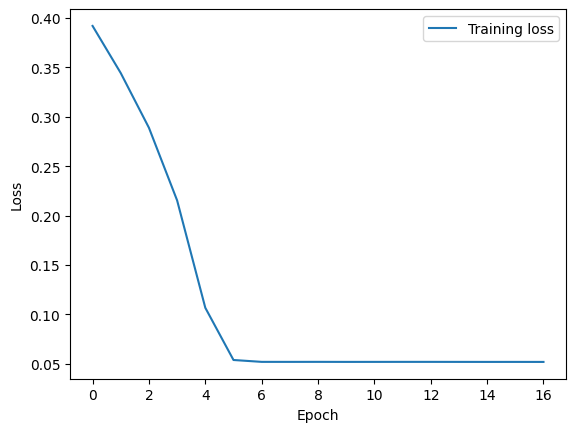

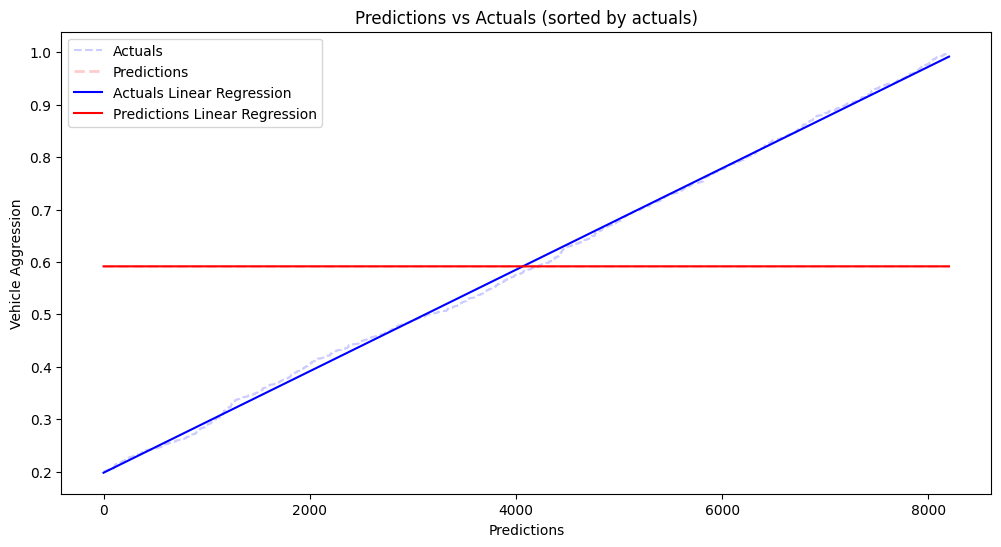

[I 2023-05-21 02:47:44,405] Trial 9 finished with value: 0.05288044328872974 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4414!
Epoch 1 loss improved from 0.4414 to 0.3976!
Epoch 2 loss improved from 0.3976 to 0.3484!
Epoch 3 loss improved from 0.3484 to 0.2834!
Epoch 4 loss improved from 0.2834 to 0.1805!
Epoch 5 loss improved from 0.1805 to 0.0837!
Epoch 6 loss improved from 0.0837 to 0.0542!
Epoch 7 loss improved from 0.0542 to 0.0520!
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0520! Rem

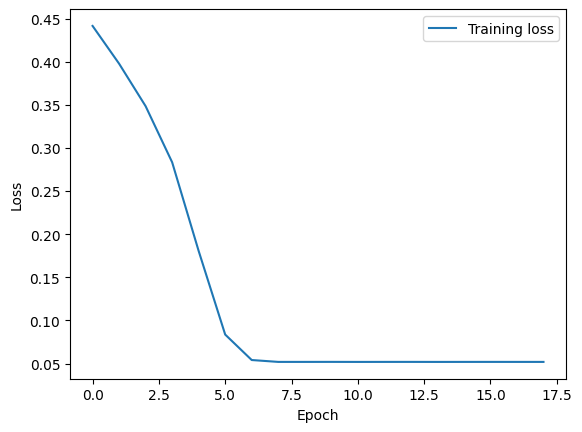

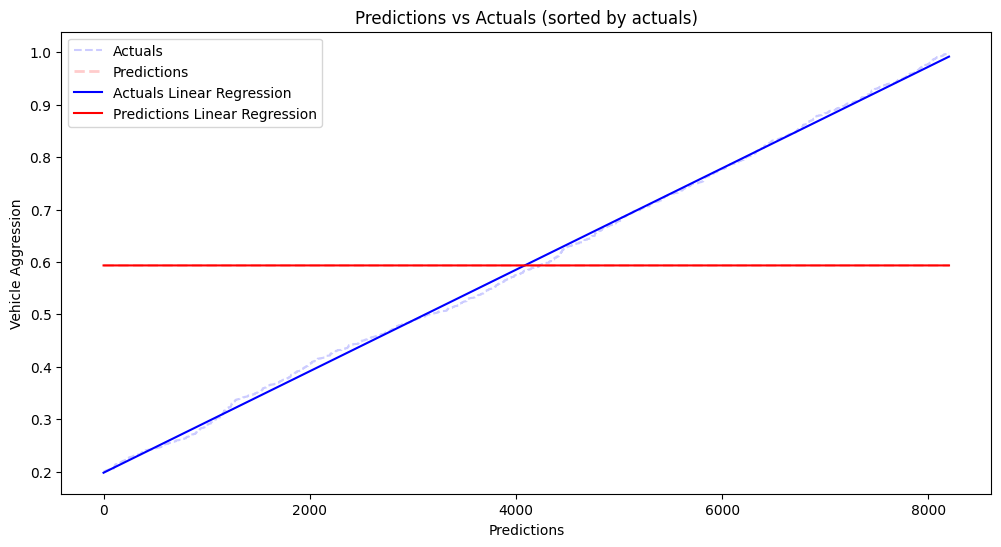

[I 2023-05-21 02:48:07,440] Trial 10 finished with value: 0.05286866609866803 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.7026!
Epoch 1 loss improved from 0.7026 to 0.6465!
Epoch 2 loss improved from 0.6465 to 0.5737!
Epoch 3 loss improved from 0.5737 to 0.4457!
Epoch 4 loss improved from 0.4457 to 0.2630!
Epoch 5 loss improved from 0.2630 to 0.1300!
Epoch 6 loss improved from 0.1300 to 0.0707!
Epoch 7 loss improved from 0.0707 to 0.0544!
Epoch 8 loss improved from 0.0544 to 0.0522!
Epoch 9 loss did not improve from 0.0522! Remaining epochs: 9
Epoch 10 loss did not improve from 0.0522! Remaining epochs: 8
Epoch 11 loss did not improve from 0.0522! Remaining epochs: 7
Epoch 12 loss did not improve from 0.0522! Remaining epochs: 6
Epoch 13 loss did not improve from 0.0522! Remaining epochs: 5
Epoch 14 loss did not improve from 0.0522! Remaining epochs: 4
Epoch 15 loss did not improve from 0.0522! Remaining epochs: 3
Epoch 16 loss did not improve from 0.0522! Remaining epochs: 2
Epoch 17 loss did not improve from 0.0522! Remaining epochs: 1


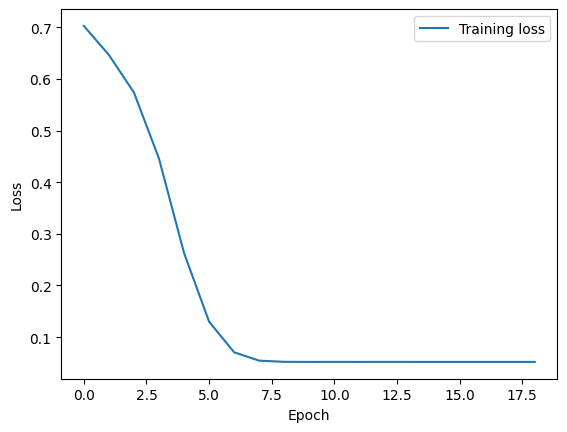

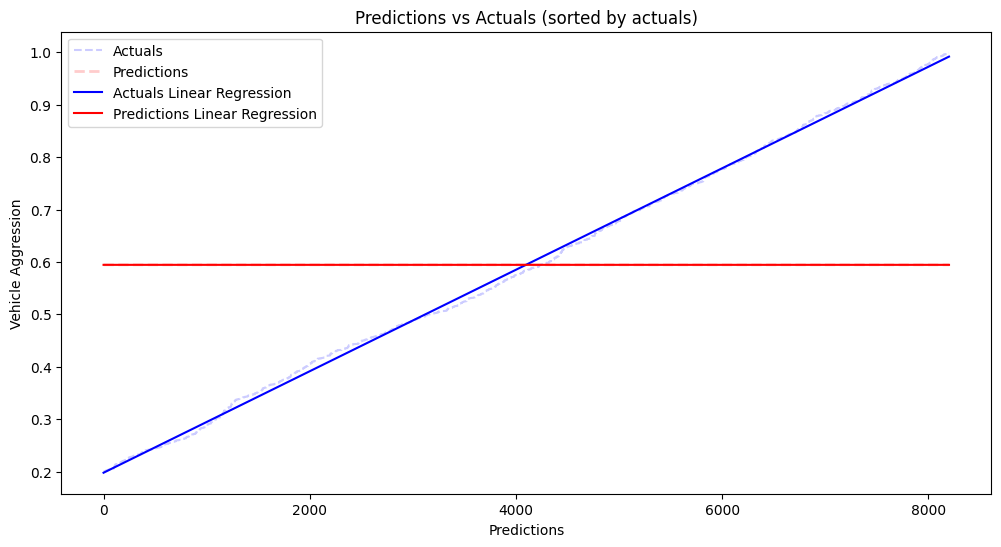

[I 2023-05-21 02:48:31,824] Trial 11 finished with value: 0.05286386482990705 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6889!
Epoch 1 loss improved from 0.6889 to 0.6294!
Epoch 2 loss improved from 0.6294 to 0.5606!
Epoch 3 loss improved from 0.5606 to 0.4637!
Epoch 4 loss improved from 0.4637 to 0.2796!
Epoch 5 loss improved from 0.2796 to 0.1145!
Epoch 6 loss improved from 0.1145 to 0.0613!
Epoch 7 loss improved from 0.0613 to 0.0527!
Epoch 8 loss did not improve from 0.0527! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0527! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0527! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0527! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0527! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0527! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0527! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0527! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0527! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0527! Rem

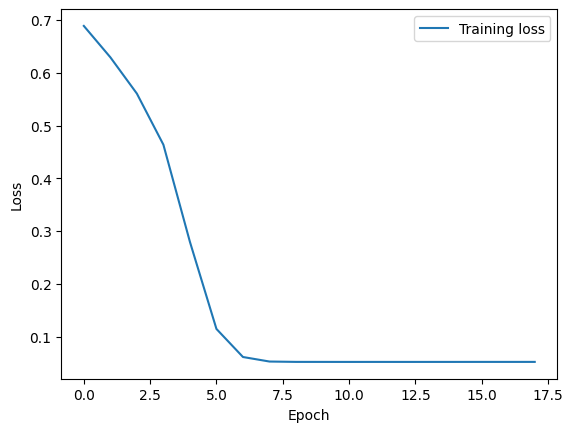

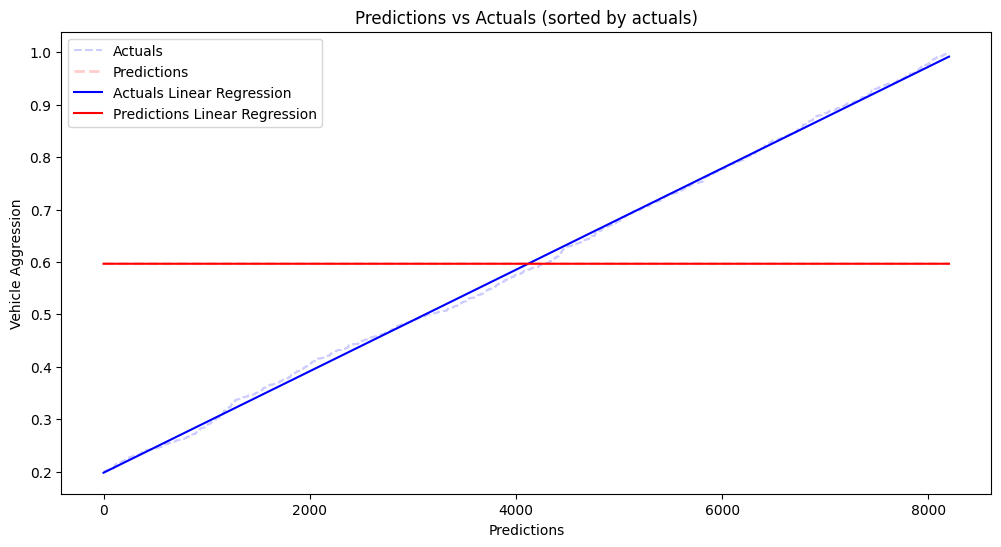

[I 2023-05-21 02:48:54,886] Trial 12 finished with value: 0.05286100661525359 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5614!
Epoch 1 loss improved from 0.5614 to 0.5131!
Epoch 2 loss improved from 0.5131 to 0.4612!
Epoch 3 loss improved from 0.4612 to 0.3915!
Epoch 4 loss improved from 0.3915 to 0.2516!
Epoch 5 loss improved from 0.2516 to 0.0986!
Epoch 6 loss improved from 0.0986 to 0.0555!
Epoch 7 loss improved from 0.0555 to 0.0521!
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0521! Rem

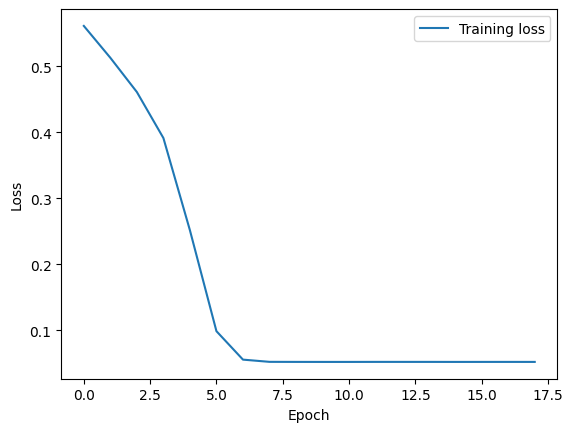

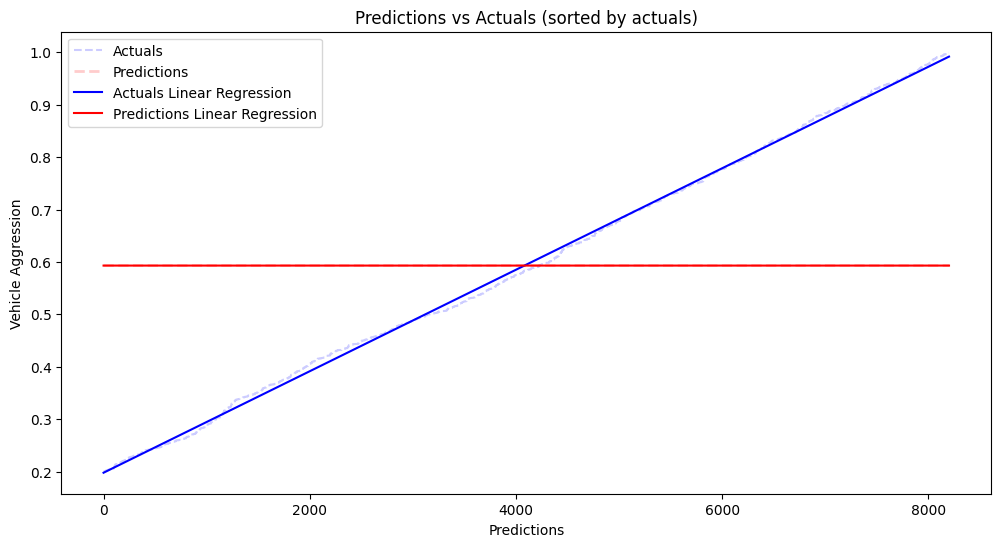

[I 2023-05-21 02:49:17,899] Trial 13 finished with value: 0.05287039686854069 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5339!
Epoch 1 loss improved from 0.5339 to 0.4917!
Epoch 2 loss improved from 0.4917 to 0.4456!
Epoch 3 loss improved from 0.4456 to 0.3852!
Epoch 4 loss improved from 0.3852 to 0.2705!
Epoch 5 loss improved from 0.2705 to 0.1207!
Epoch 6 loss improved from 0.1207 to 0.0593!
Epoch 7 loss improved from 0.0593 to 0.0522!
Epoch 8 loss did not improve from 0.0522! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0522! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0522! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0522! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0522! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0522! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0522! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0522! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0522! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0522! Rem

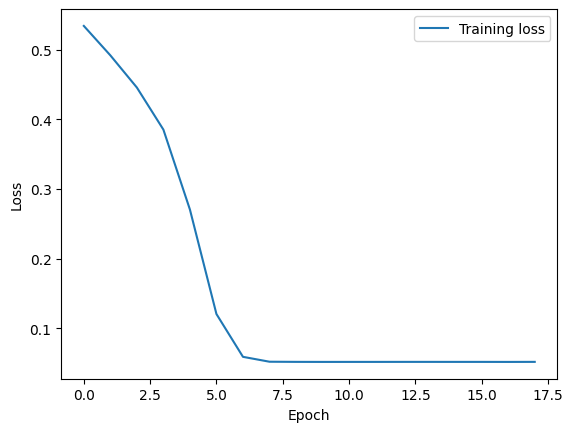

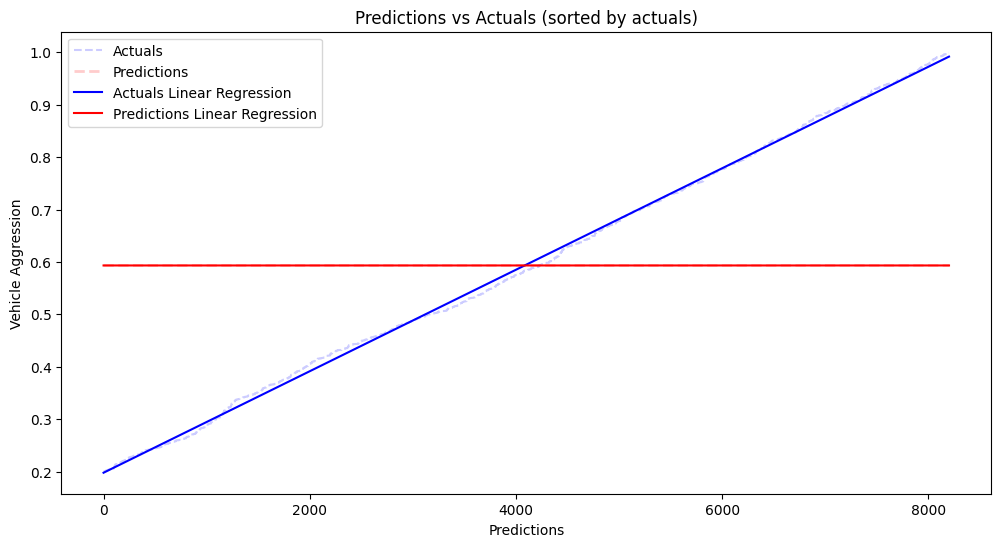

[I 2023-05-21 02:49:40,779] Trial 14 finished with value: 0.05286937854610957 and parameters: {}. Best is trial 8 with value: 0.05286070538254885.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3198!
Epoch 1 loss improved from 0.3198 to 0.2853!
Epoch 2 loss improved from 0.2853 to 0.2437!
Epoch 3 loss improved from 0.2437 to 0.1798!
Epoch 4 loss improved from 0.1798 to 0.0932!
Epoch 5 loss improved from 0.0932 to 0.0552!
Epoch 6 loss improved from 0.0552 to 0.0521!
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


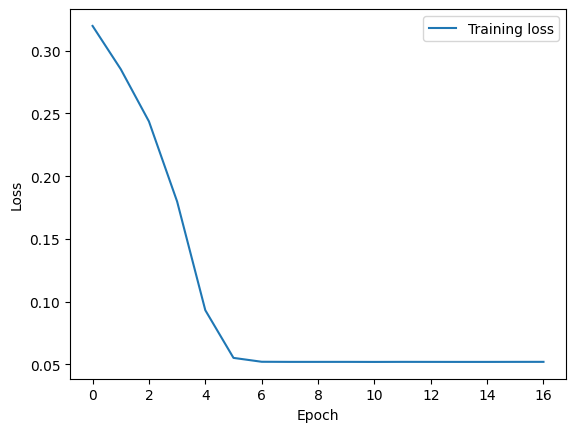

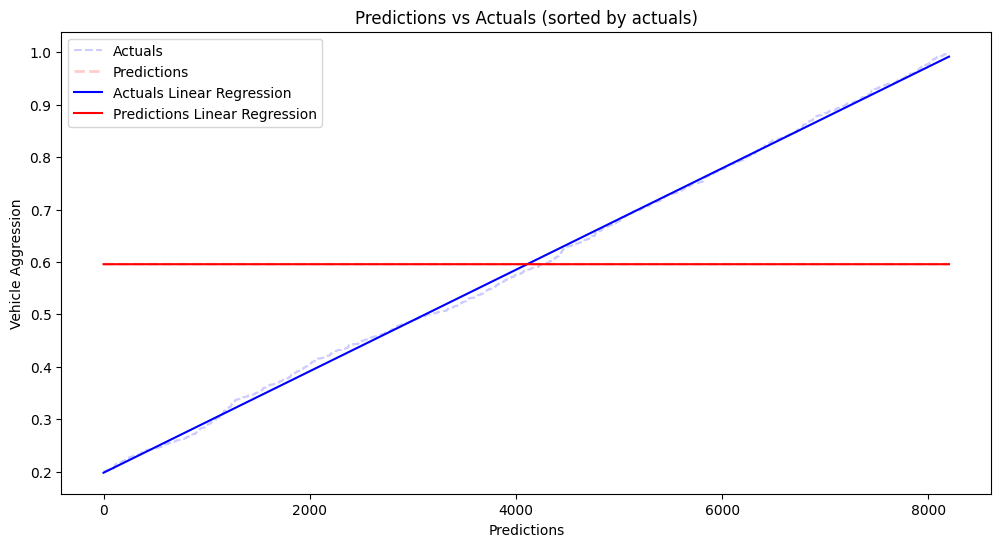

[I 2023-05-21 02:50:02,480] Trial 15 finished with value: 0.05286034506100875 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4683!
Epoch 1 loss improved from 0.4683 to 0.4320!
Epoch 2 loss improved from 0.4320 to 0.3876!
Epoch 3 loss improved from 0.3876 to 0.2974!
Epoch 4 loss improved from 0.2974 to 0.1304!
Epoch 5 loss improved from 0.1304 to 0.0583!
Epoch 6 loss improved from 0.0583 to 0.0522!
Epoch 7 loss did not improve from 0.0522! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0522! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0522! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0522! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0522! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0522! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0522! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0522! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0522! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0522! Remaining epochs: 0
Early stopping!


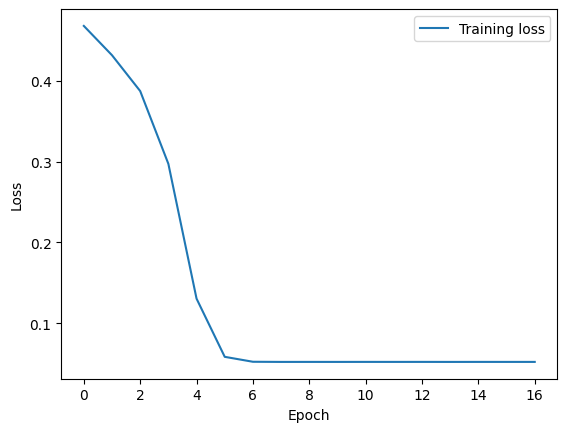

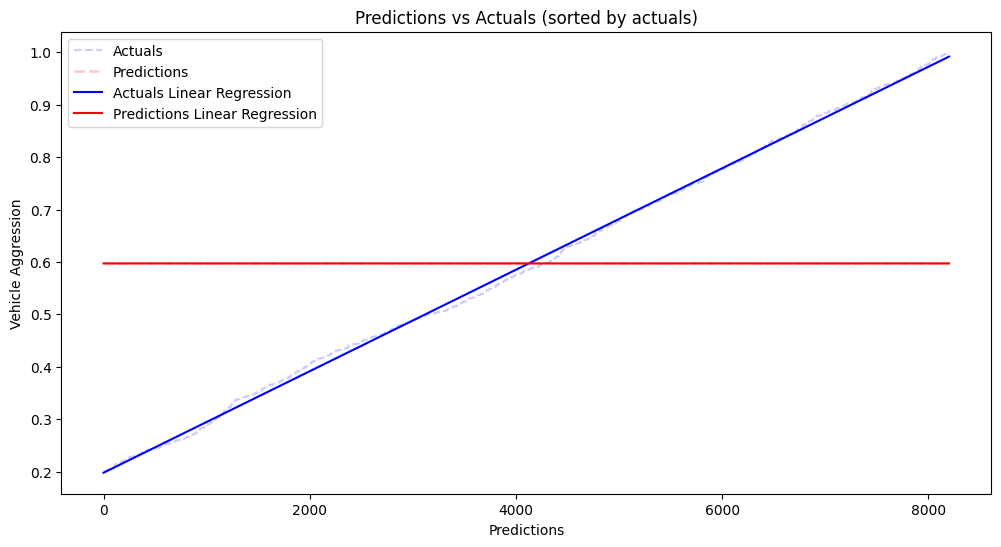

[I 2023-05-21 02:50:24,322] Trial 16 finished with value: 0.052861837297677995 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6554!
Epoch 1 loss improved from 0.6554 to 0.5945!
Epoch 2 loss improved from 0.5945 to 0.5161!
Epoch 3 loss improved from 0.5161 to 0.3813!
Epoch 4 loss improved from 0.3813 to 0.1638!
Epoch 5 loss improved from 0.1638 to 0.0640!
Epoch 6 loss improved from 0.0640 to 0.0525!
Epoch 7 loss did not improve from 0.0525! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0525! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0525! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0525! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0525! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0525! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0525! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0525! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0525! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0525! Remaining epochs: 0
Early stopping!


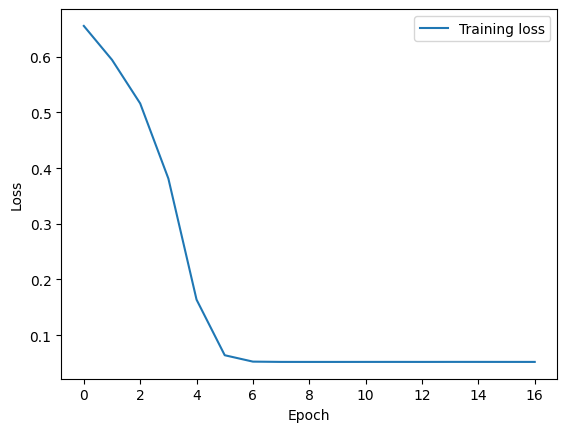

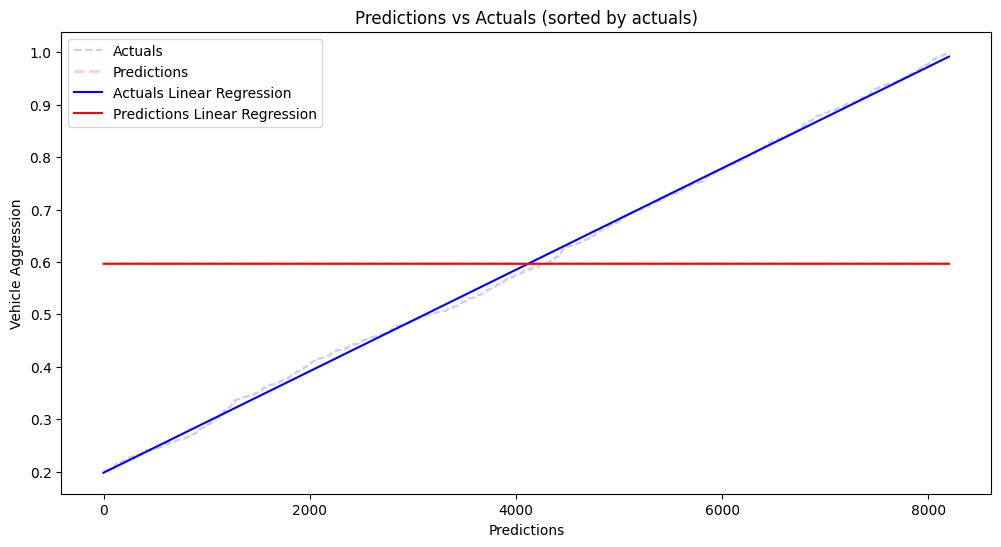

[I 2023-05-21 02:50:46,190] Trial 17 finished with value: 0.05286115740354245 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3043!
Epoch 1 loss improved from 0.3043 to 0.2678!
Epoch 2 loss improved from 0.2678 to 0.2297!
Epoch 3 loss improved from 0.2297 to 0.1857!
Epoch 4 loss improved from 0.1857 to 0.1261!
Epoch 5 loss improved from 0.1261 to 0.0670!
Epoch 6 loss improved from 0.0670 to 0.0523!
Epoch 7 loss did not improve from 0.0523! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0523! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0523! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0523! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0523! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0523! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0523! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0523! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0523! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0523! Remaining epochs: 0
Early stopping!


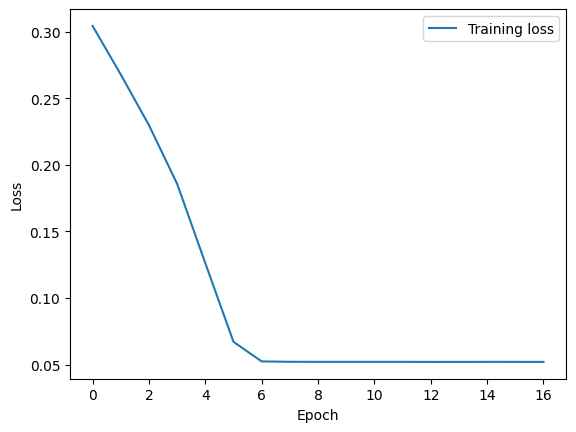

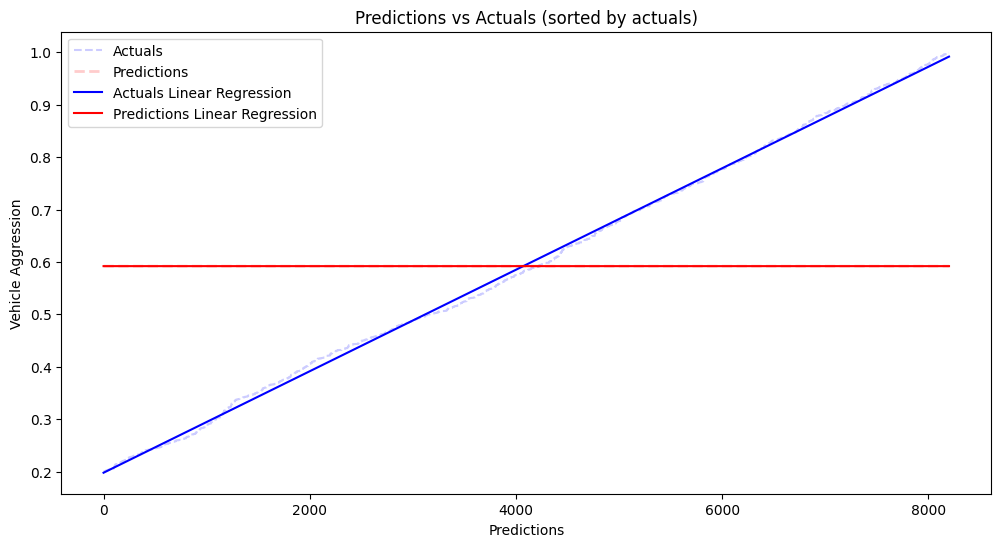

[I 2023-05-21 02:51:08,039] Trial 18 finished with value: 0.05287783495508708 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6086!
Epoch 1 loss improved from 0.6086 to 0.5490!
Epoch 2 loss improved from 0.5490 to 0.4806!
Epoch 3 loss improved from 0.4806 to 0.3823!
Epoch 4 loss improved from 0.3823 to 0.2255!
Epoch 5 loss improved from 0.2255 to 0.0975!
Epoch 6 loss improved from 0.0975 to 0.0570!
Epoch 7 loss improved from 0.0570 to 0.0522!
Epoch 8 loss did not improve from 0.0522! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0522! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0522! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0522! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0522! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0522! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0522! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0522! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0522! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0522! Rem

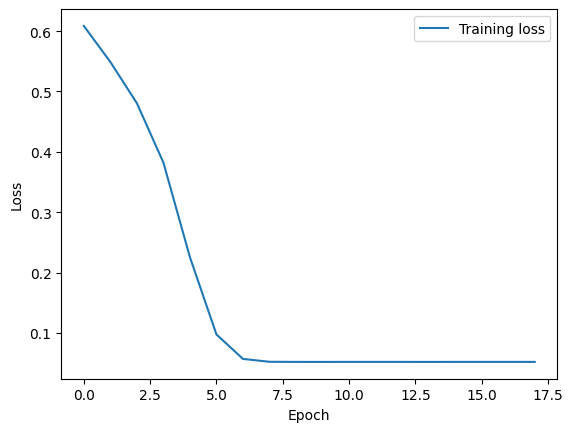

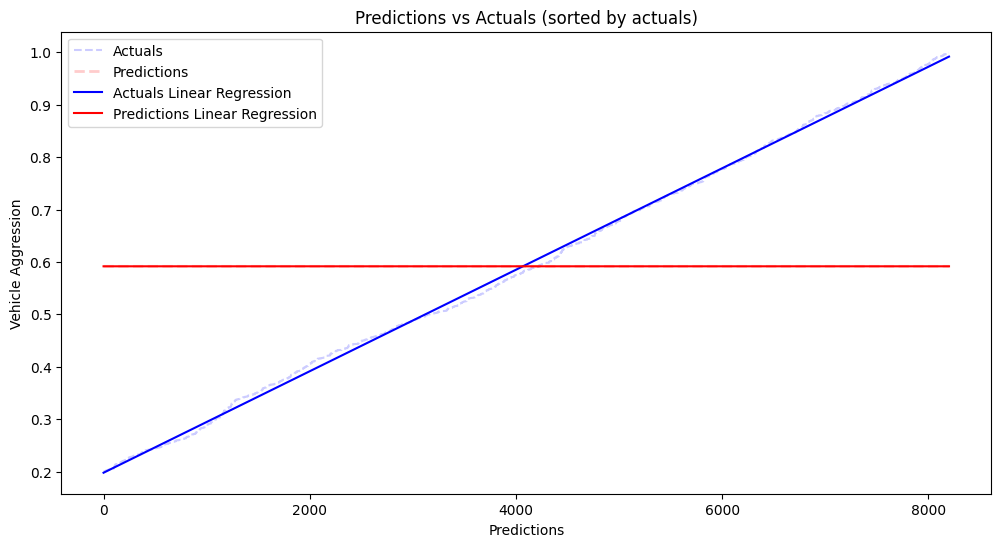

[I 2023-05-21 02:51:31,156] Trial 19 finished with value: 0.05288074767360321 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5285!
Epoch 1 loss improved from 0.5285 to 0.4743!
Epoch 2 loss improved from 0.4743 to 0.4063!
Epoch 3 loss improved from 0.4063 to 0.2872!
Epoch 4 loss improved from 0.2872 to 0.1365!
Epoch 5 loss improved from 0.1365 to 0.0669!
Epoch 6 loss improved from 0.0669 to 0.0531!
Epoch 7 loss improved from 0.0531 to 0.0520!
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0520! Rem

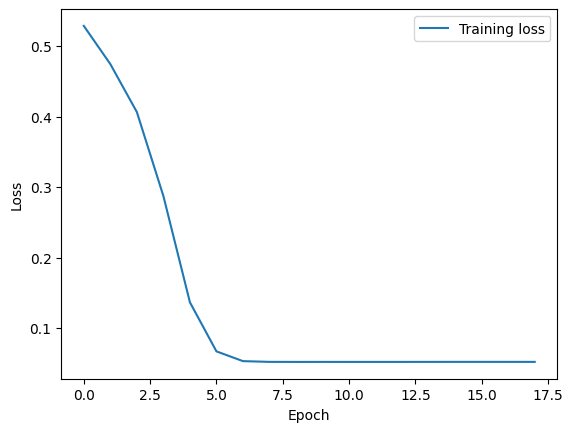

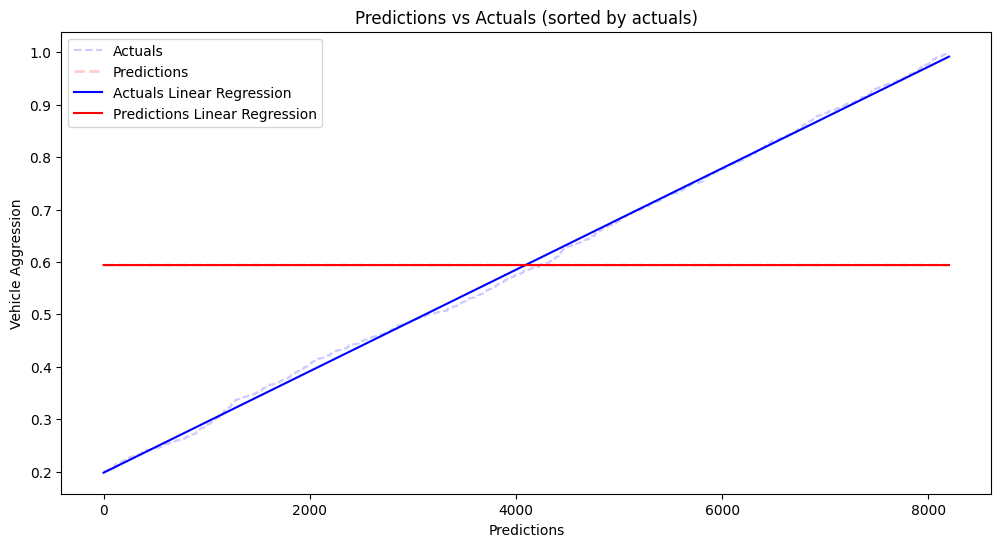

[I 2023-05-21 02:51:54,116] Trial 20 finished with value: 0.05286510048004297 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2353!
Epoch 1 loss improved from 0.2353 to 0.2004!
Epoch 2 loss improved from 0.2004 to 0.1622!
Epoch 3 loss improved from 0.1622 to 0.1169!
Epoch 4 loss improved from 0.1169 to 0.0698!
Epoch 5 loss improved from 0.0698 to 0.0528!
Epoch 6 loss did not improve from 0.0528! Remaining epochs: 9
Epoch 7 loss did not improve from 0.0528! Remaining epochs: 8
Epoch 8 loss did not improve from 0.0528! Remaining epochs: 7
Epoch 9 loss did not improve from 0.0528! Remaining epochs: 6
Epoch 10 loss did not improve from 0.0528! Remaining epochs: 5
Epoch 11 loss did not improve from 0.0528! Remaining epochs: 4
Epoch 12 loss did not improve from 0.0528! Remaining epochs: 3
Epoch 13 loss did not improve from 0.0528! Remaining epochs: 2
Epoch 14 loss did not improve from 0.0528! Remaining epochs: 1
Epoch 15 loss did not improve from 0.0528! Remaining epochs: 0
Early stopping!


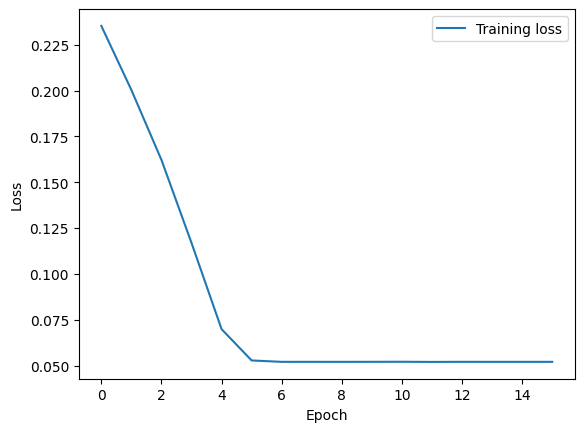

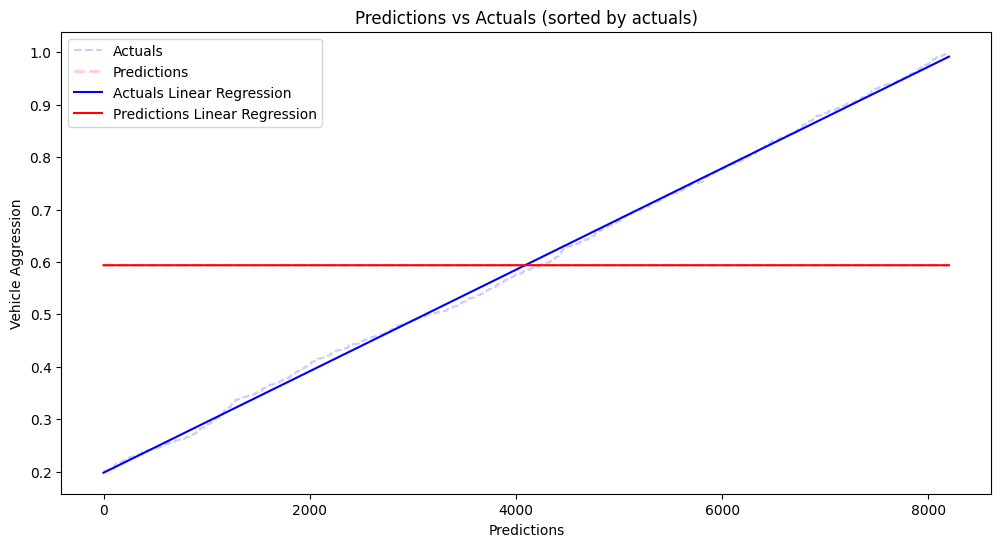

[I 2023-05-21 02:52:14,695] Trial 21 finished with value: 0.052866365302067536 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2922!
Epoch 1 loss improved from 0.2922 to 0.2505!
Epoch 2 loss improved from 0.2505 to 0.2031!
Epoch 3 loss improved from 0.2031 to 0.1415!
Epoch 4 loss improved from 0.1415 to 0.0741!
Epoch 5 loss improved from 0.0741 to 0.0526!
Epoch 6 loss did not improve from 0.0526! Remaining epochs: 9
Epoch 7 loss did not improve from 0.0526! Remaining epochs: 8
Epoch 8 loss did not improve from 0.0526! Remaining epochs: 7
Epoch 9 loss did not improve from 0.0526! Remaining epochs: 6
Epoch 10 loss did not improve from 0.0526! Remaining epochs: 5
Epoch 11 loss did not improve from 0.0526! Remaining epochs: 4
Epoch 12 loss did not improve from 0.0526! Remaining epochs: 3
Epoch 13 loss did not improve from 0.0526! Remaining epochs: 2
Epoch 14 loss did not improve from 0.0526! Remaining epochs: 1
Epoch 15 loss did not improve from 0.0526! Remaining epochs: 0
Early stopping!


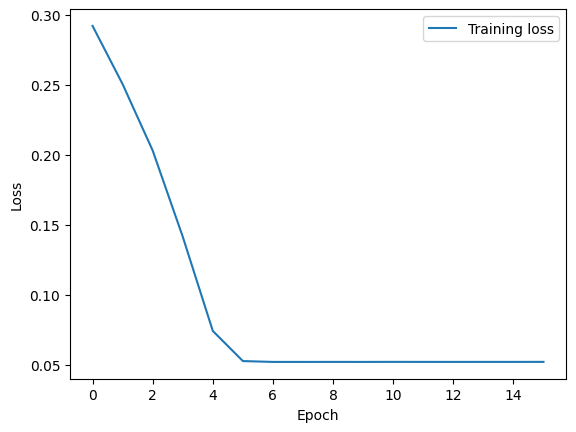

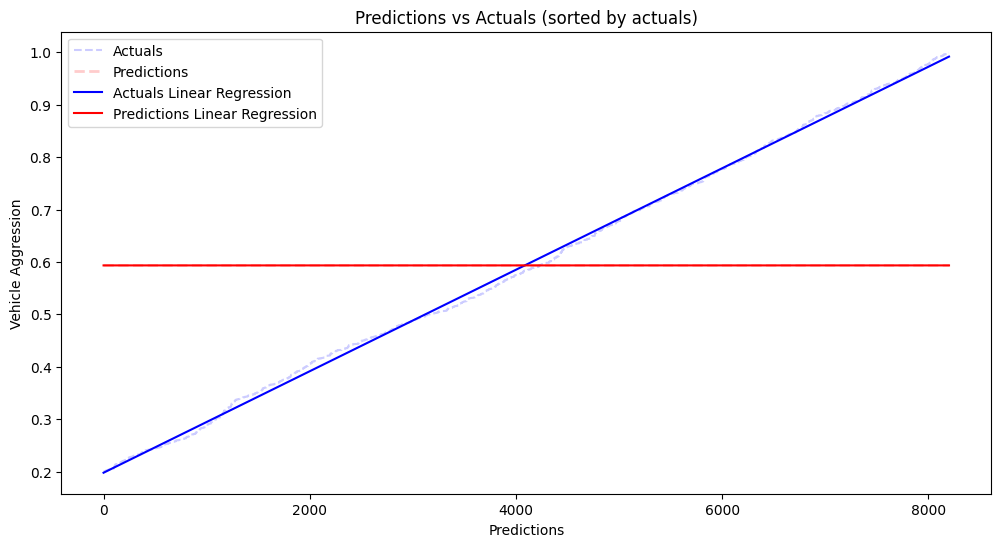

[I 2023-05-21 02:52:35,337] Trial 22 finished with value: 0.052867876222500436 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3195!
Epoch 1 loss improved from 0.3195 to 0.2897!
Epoch 2 loss improved from 0.2897 to 0.2570!
Epoch 3 loss improved from 0.2570 to 0.2115!
Epoch 4 loss improved from 0.2115 to 0.1266!
Epoch 5 loss improved from 0.1266 to 0.0604!
Epoch 6 loss improved from 0.0604 to 0.0521!
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


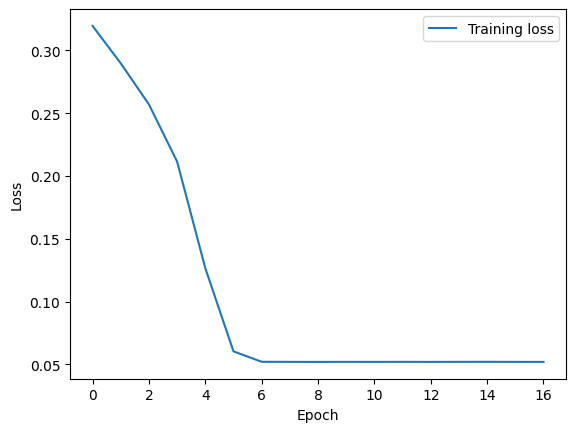

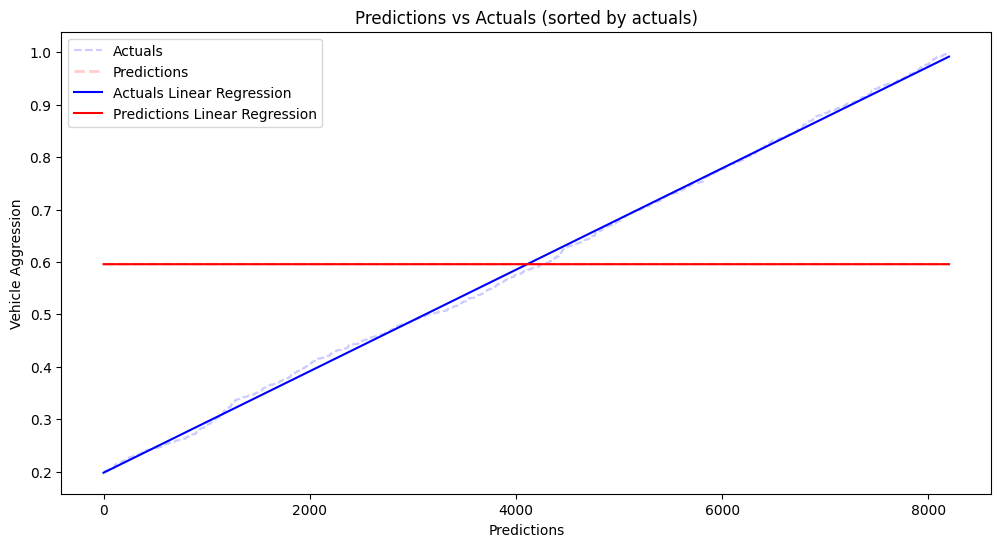

[I 2023-05-21 02:52:57,155] Trial 23 finished with value: 0.052861118545899026 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3450!
Epoch 1 loss improved from 0.3450 to 0.3073!
Epoch 2 loss improved from 0.3073 to 0.2613!
Epoch 3 loss improved from 0.2613 to 0.1885!
Epoch 4 loss improved from 0.1885 to 0.0902!
Epoch 5 loss improved from 0.0902 to 0.0540!
Epoch 6 loss improved from 0.0540 to 0.0521!
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


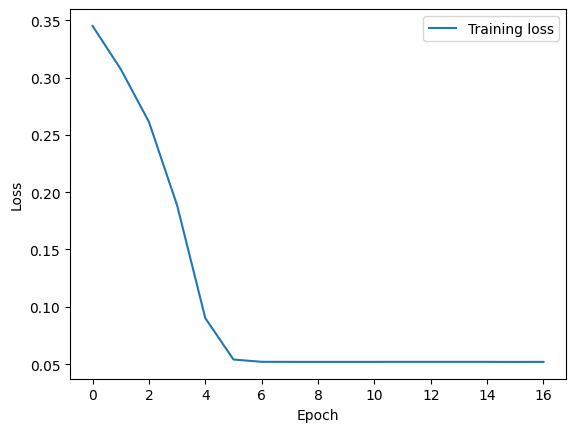

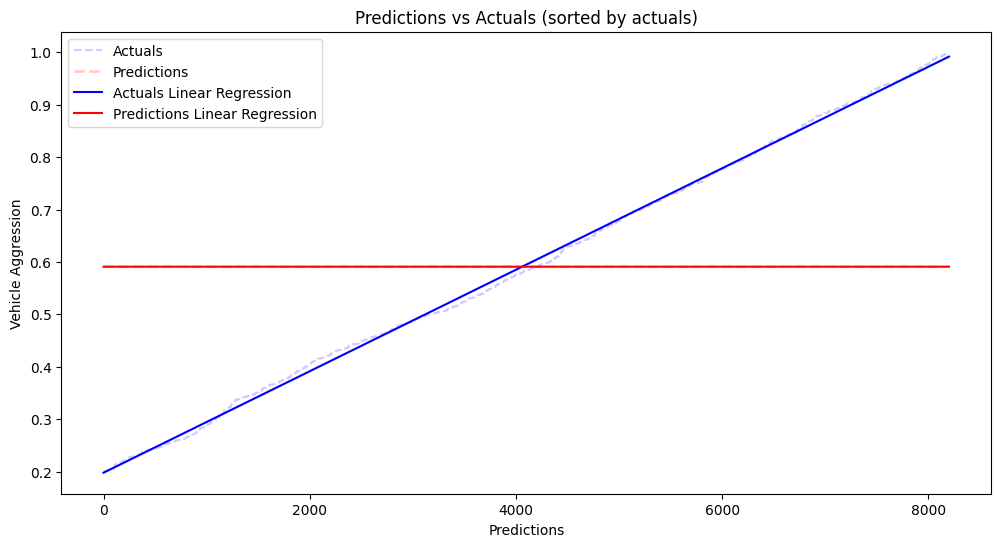

[I 2023-05-21 02:53:18,936] Trial 24 finished with value: 0.05288807950340785 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3704!
Epoch 1 loss improved from 0.3704 to 0.3288!
Epoch 2 loss improved from 0.3288 to 0.2804!
Epoch 3 loss improved from 0.2804 to 0.2149!
Epoch 4 loss improved from 0.2149 to 0.1192!
Epoch 5 loss improved from 0.1192 to 0.0591!
Epoch 6 loss improved from 0.0591 to 0.0521!
Epoch 7 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 0
Early stopping!


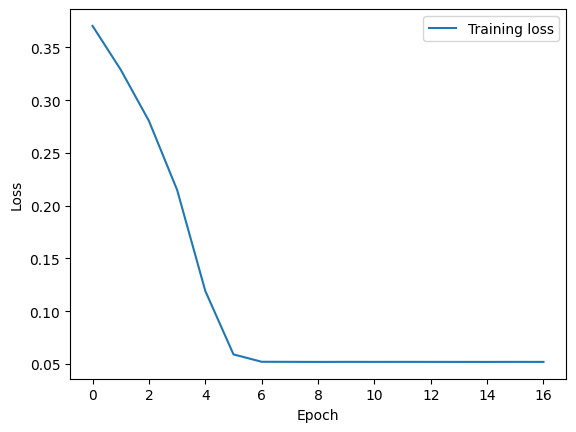

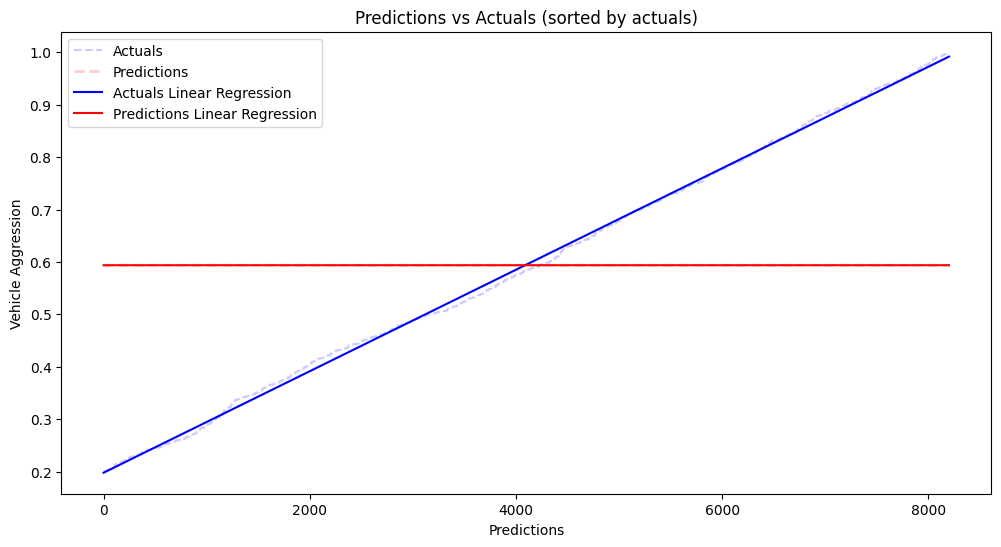

[I 2023-05-21 02:53:40,677] Trial 25 finished with value: 0.05286657535112821 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6369!
Epoch 1 loss improved from 0.6369 to 0.5844!
Epoch 2 loss improved from 0.5844 to 0.5251!
Epoch 3 loss improved from 0.5251 to 0.4529!
Epoch 4 loss improved from 0.4529 to 0.3439!
Epoch 5 loss improved from 0.3439 to 0.1489!
Epoch 6 loss improved from 0.1489 to 0.0568!
Epoch 7 loss improved from 0.0568 to 0.0521!
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0521! Rem

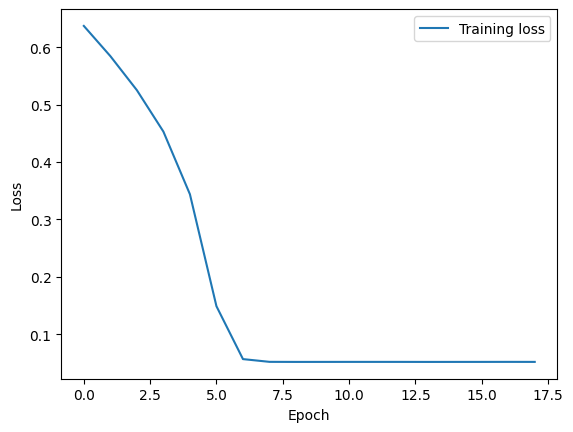

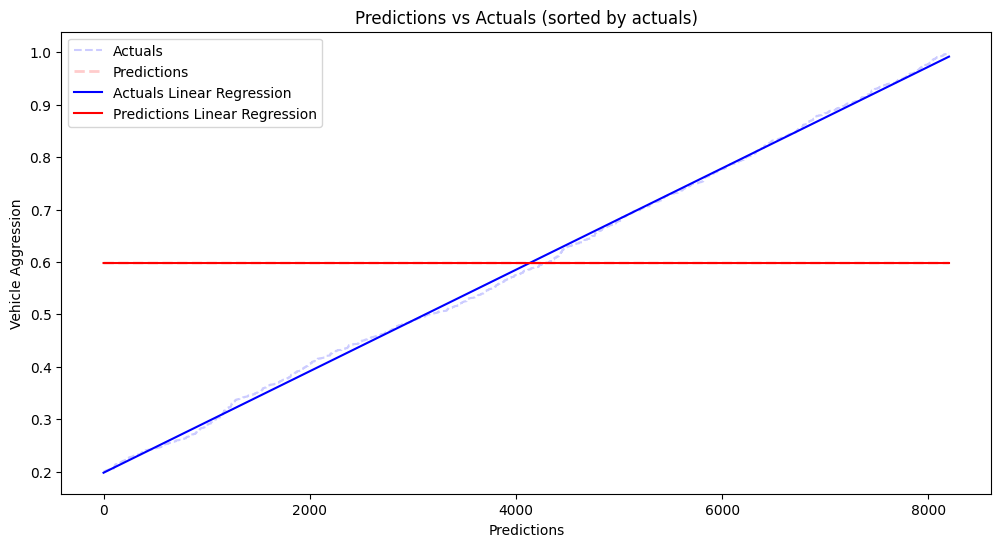

[I 2023-05-21 02:54:03,758] Trial 26 finished with value: 0.05286441800686029 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.4847!
Epoch 1 loss improved from 0.4847 to 0.4394!
Epoch 2 loss improved from 0.4394 to 0.3768!
Epoch 3 loss improved from 0.3768 to 0.2669!
Epoch 4 loss improved from 0.2669 to 0.1217!
Epoch 5 loss improved from 0.1217 to 0.0586!
Epoch 6 loss improved from 0.0586 to 0.0522!
Epoch 7 loss did not improve from 0.0522! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0522! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0522! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0522! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0522! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0522! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0522! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0522! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0522! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0522! Remaining epochs: 0
Early stopping!


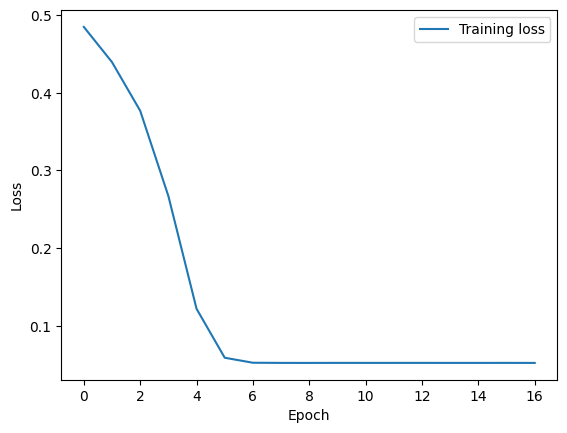

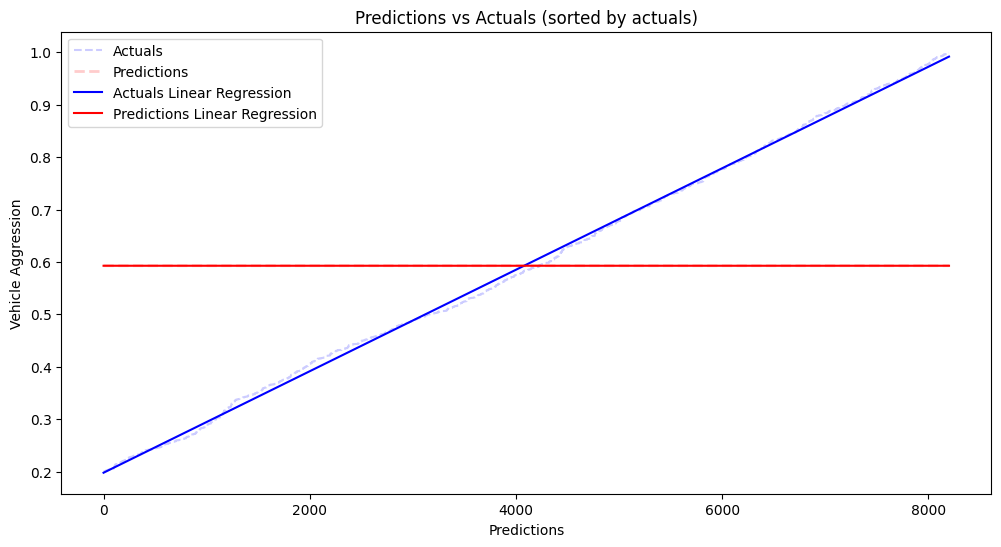

[I 2023-05-21 02:54:25,797] Trial 27 finished with value: 0.05287242686519256 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5876!
Epoch 1 loss improved from 0.5876 to 0.5344!
Epoch 2 loss improved from 0.5344 to 0.4760!
Epoch 3 loss improved from 0.4760 to 0.3920!
Epoch 4 loss improved from 0.3920 to 0.2334!
Epoch 5 loss improved from 0.2334 to 0.0851!
Epoch 6 loss improved from 0.0851 to 0.0531!
Epoch 7 loss improved from 0.0531 to 0.0520!
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0520! Rem

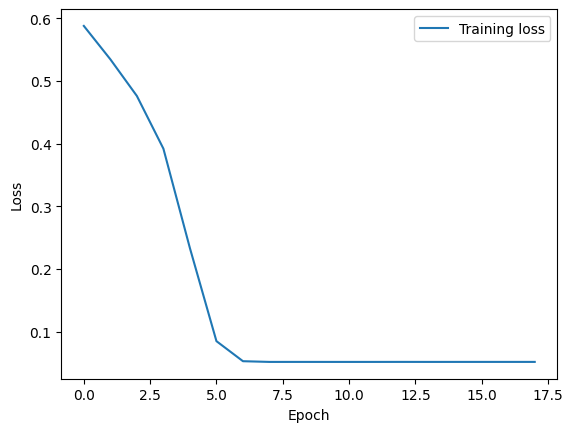

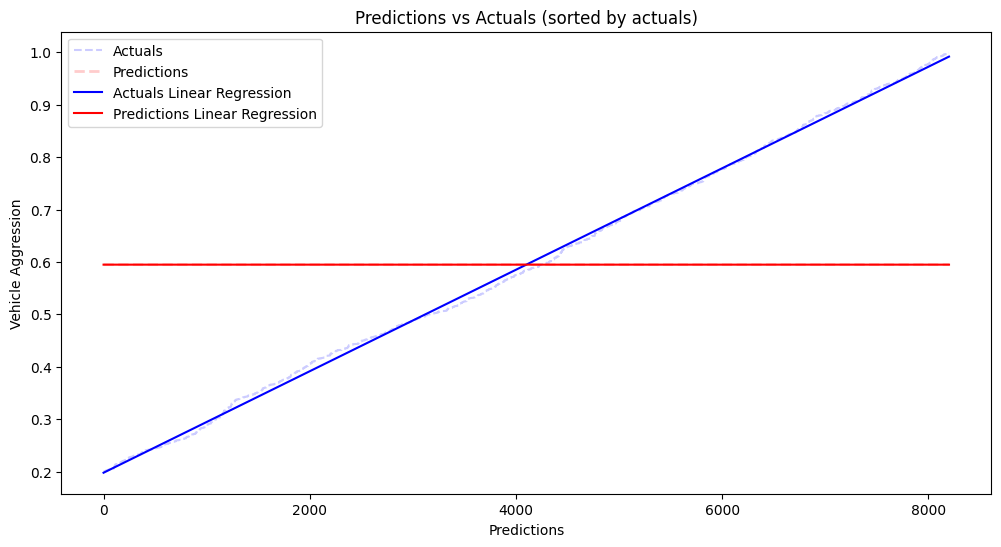

[I 2023-05-21 02:54:48,253] Trial 28 finished with value: 0.05286231264472008 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6146!
Epoch 1 loss improved from 0.6146 to 0.5584!
Epoch 2 loss improved from 0.5584 to 0.4966!
Epoch 3 loss improved from 0.4966 to 0.4085!
Epoch 4 loss improved from 0.4085 to 0.2518!
Epoch 5 loss improved from 0.2518 to 0.1133!
Epoch 6 loss improved from 0.1133 to 0.0618!
Epoch 7 loss improved from 0.0618 to 0.0528!
Epoch 8 loss did not improve from 0.0528! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0528! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0528! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0528! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0528! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0528! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0528! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0528! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0528! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0528! Rem

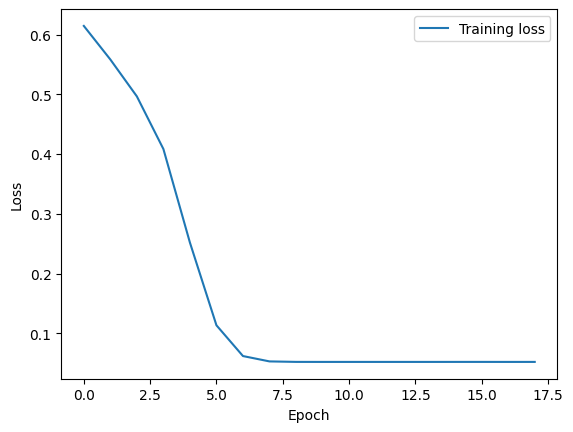

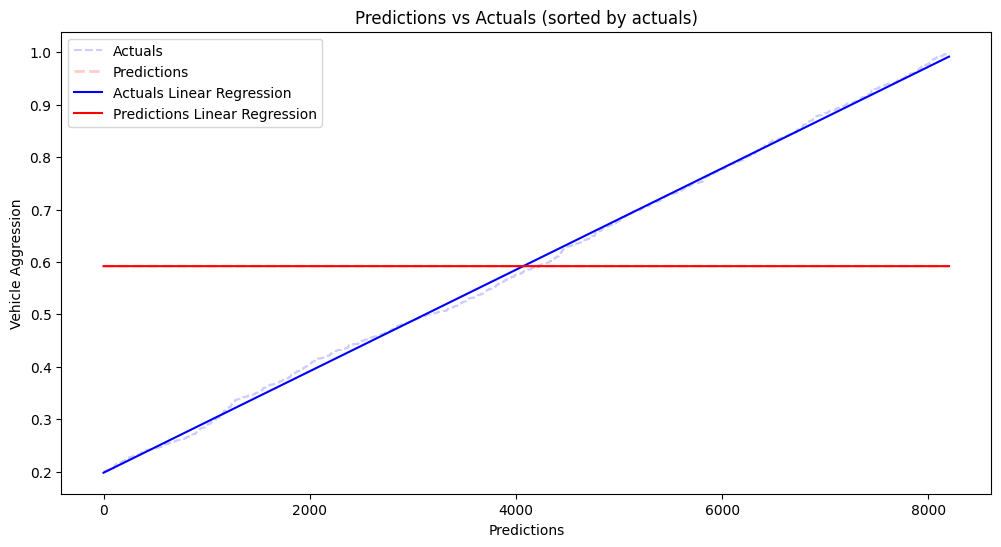

[I 2023-05-21 02:55:11,391] Trial 29 finished with value: 0.05287828124486483 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2521!
Epoch 1 loss improved from 0.2521 to 0.2172!
Epoch 2 loss improved from 0.2172 to 0.1784!
Epoch 3 loss improved from 0.1784 to 0.1311!
Epoch 4 loss improved from 0.1311 to 0.0760!
Epoch 5 loss improved from 0.0760 to 0.0528!
Epoch 6 loss did not improve from 0.0528! Remaining epochs: 9
Epoch 7 loss did not improve from 0.0528! Remaining epochs: 8
Epoch 8 loss did not improve from 0.0528! Remaining epochs: 7
Epoch 9 loss did not improve from 0.0528! Remaining epochs: 6
Epoch 10 loss did not improve from 0.0528! Remaining epochs: 5
Epoch 11 loss did not improve from 0.0528! Remaining epochs: 4
Epoch 12 loss did not improve from 0.0528! Remaining epochs: 3
Epoch 13 loss did not improve from 0.0528! Remaining epochs: 2
Epoch 14 loss did not improve from 0.0528! Remaining epochs: 1
Epoch 15 loss did not improve from 0.0528! Remaining epochs: 0
Early stopping!


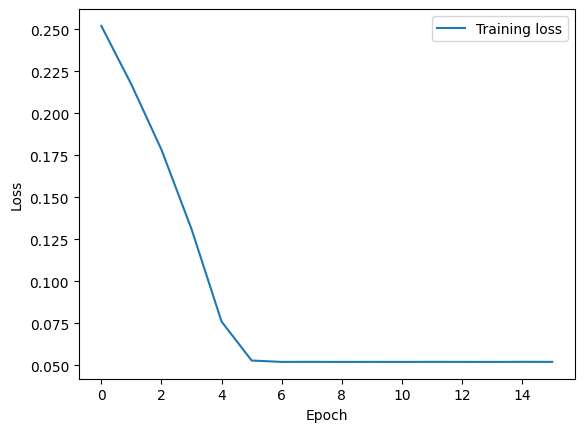

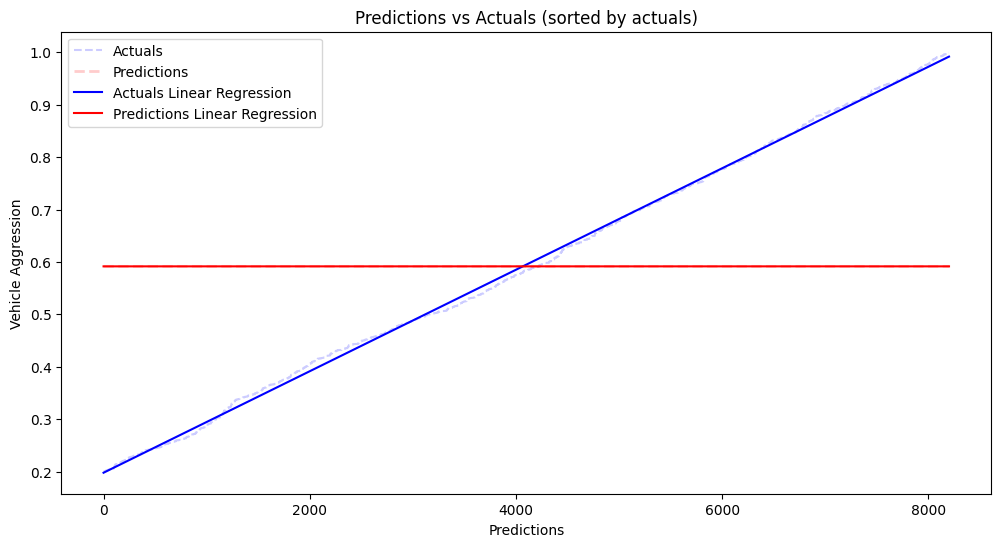

[I 2023-05-21 02:55:31,920] Trial 30 finished with value: 0.05288139209151268 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3319!
Epoch 1 loss improved from 0.3319 to 0.2898!
Epoch 2 loss improved from 0.2898 to 0.2472!
Epoch 3 loss improved from 0.2472 to 0.1967!
Epoch 4 loss improved from 0.1967 to 0.1234!
Epoch 5 loss improved from 0.1234 to 0.0651!
Epoch 6 loss improved from 0.0651 to 0.0525!
Epoch 7 loss did not improve from 0.0525! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0525! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0525! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0525! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0525! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0525! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0525! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0525! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0525! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0525! Remaining epochs: 0
Early stopping!


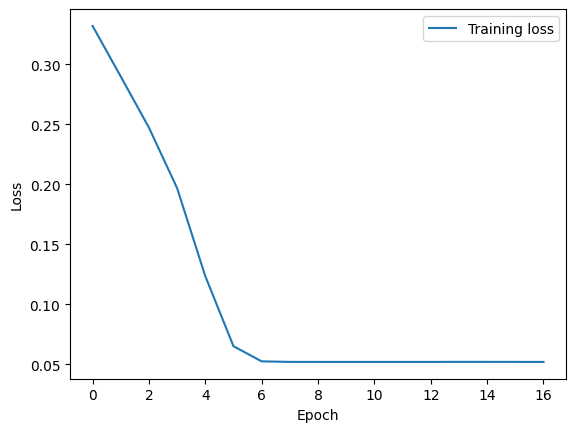

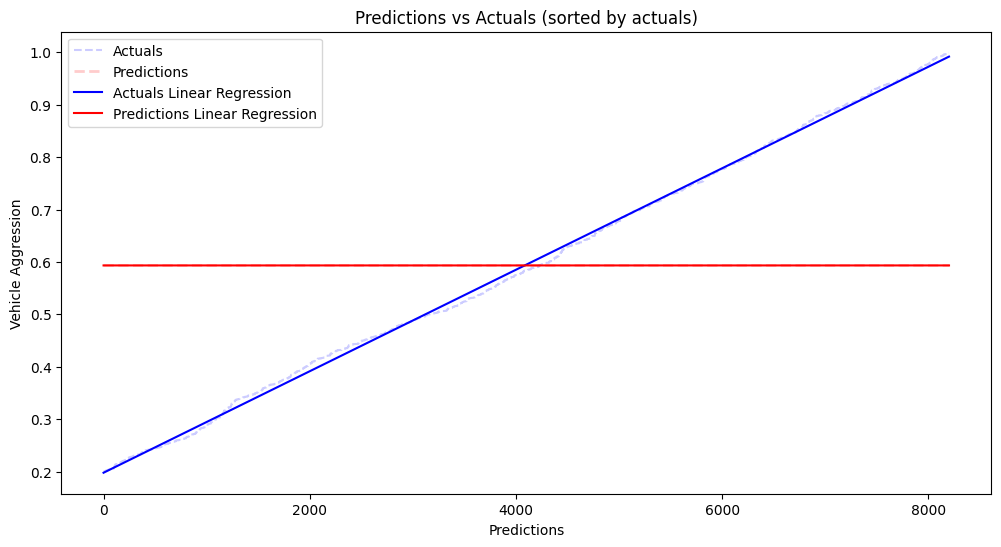

[I 2023-05-21 02:55:53,816] Trial 31 finished with value: 0.05286874576256825 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3115!
Epoch 1 loss improved from 0.3115 to 0.2706!
Epoch 2 loss improved from 0.2706 to 0.2250!
Epoch 3 loss improved from 0.2250 to 0.1595!
Epoch 4 loss improved from 0.1595 to 0.0800!
Epoch 5 loss improved from 0.0800 to 0.0535!
Epoch 6 loss improved from 0.0535 to 0.0520!
Epoch 7 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 0
Early stopping!


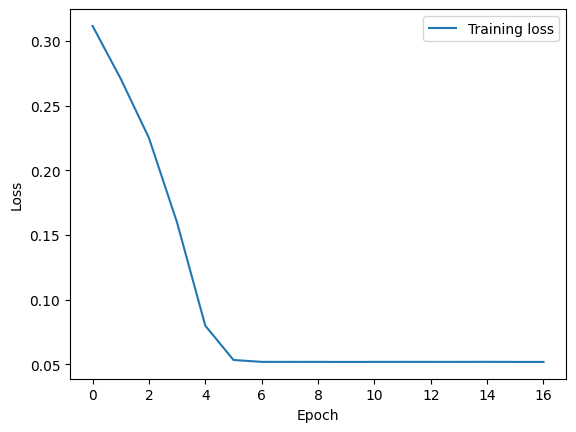

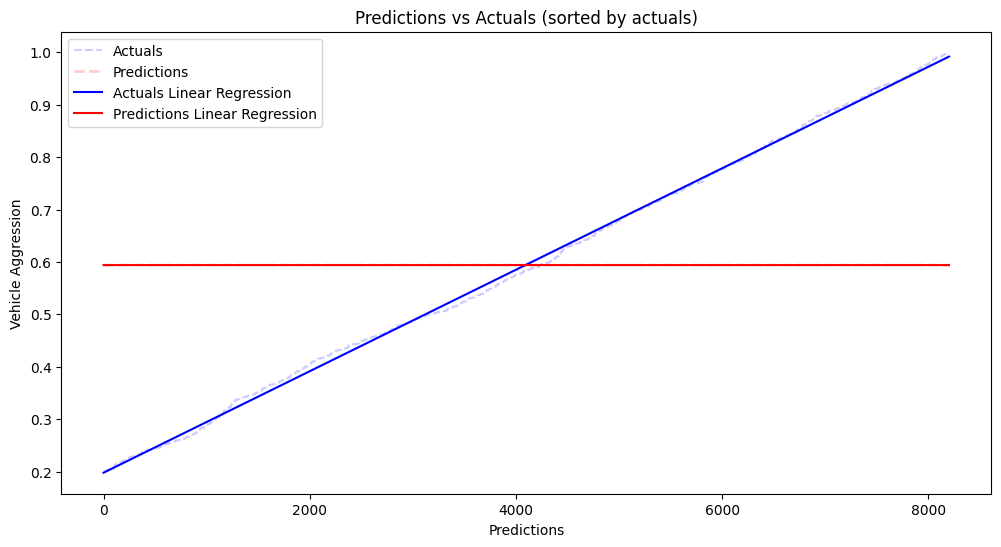

[I 2023-05-21 02:56:15,714] Trial 32 finished with value: 0.05286566334275099 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6802!
Epoch 1 loss improved from 0.6802 to 0.6269!
Epoch 2 loss improved from 0.6269 to 0.5600!
Epoch 3 loss improved from 0.5600 to 0.4534!
Epoch 4 loss improved from 0.4534 to 0.2557!
Epoch 5 loss improved from 0.2557 to 0.1039!
Epoch 6 loss improved from 0.1039 to 0.0622!
Epoch 7 loss improved from 0.0622 to 0.0534!
Epoch 8 loss improved from 0.0534 to 0.0521!
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 17 loss did not improve from 0.0521! Remaining epochs: 1


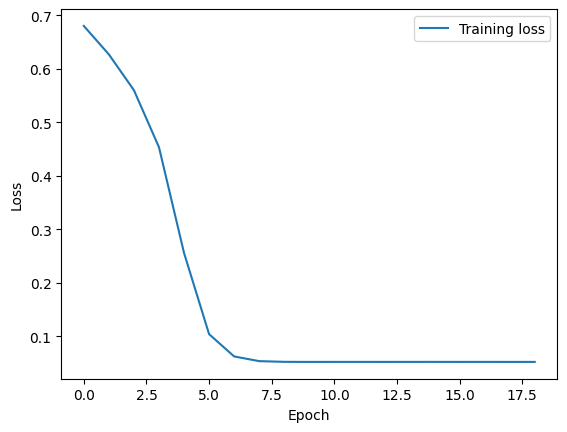

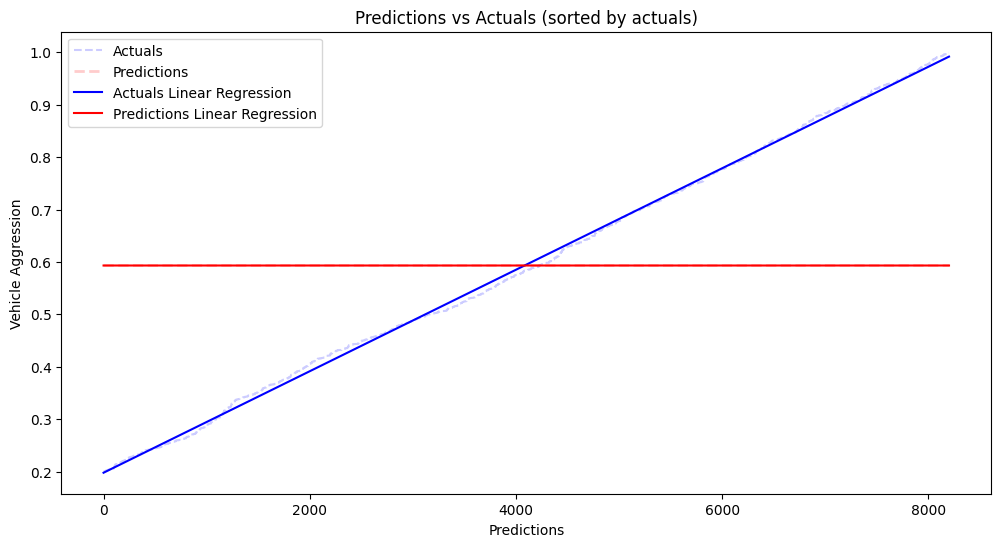

[I 2023-05-21 02:56:40,181] Trial 33 finished with value: 0.052869405998633455 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3398!
Epoch 1 loss improved from 0.3398 to 0.2958!
Epoch 2 loss improved from 0.2958 to 0.2474!
Epoch 3 loss improved from 0.2474 to 0.1729!
Epoch 4 loss improved from 0.1729 to 0.0791!
Epoch 5 loss improved from 0.0791 to 0.0531!
Epoch 6 loss improved from 0.0531 to 0.0520!
Epoch 7 loss did not improve from 0.0520! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0520! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0520! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0520! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0520! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0520! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0520! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0520! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0520! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0520! Remaining epochs: 0
Early stopping!


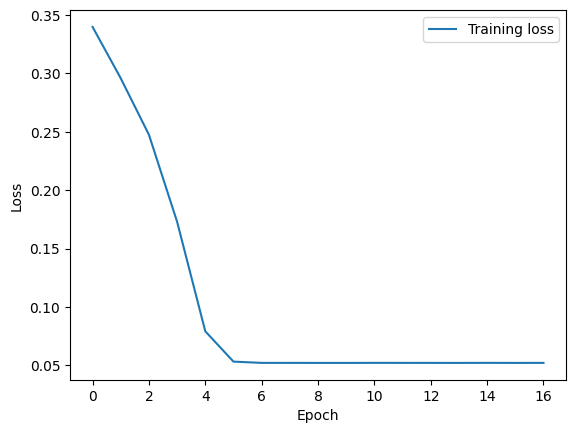

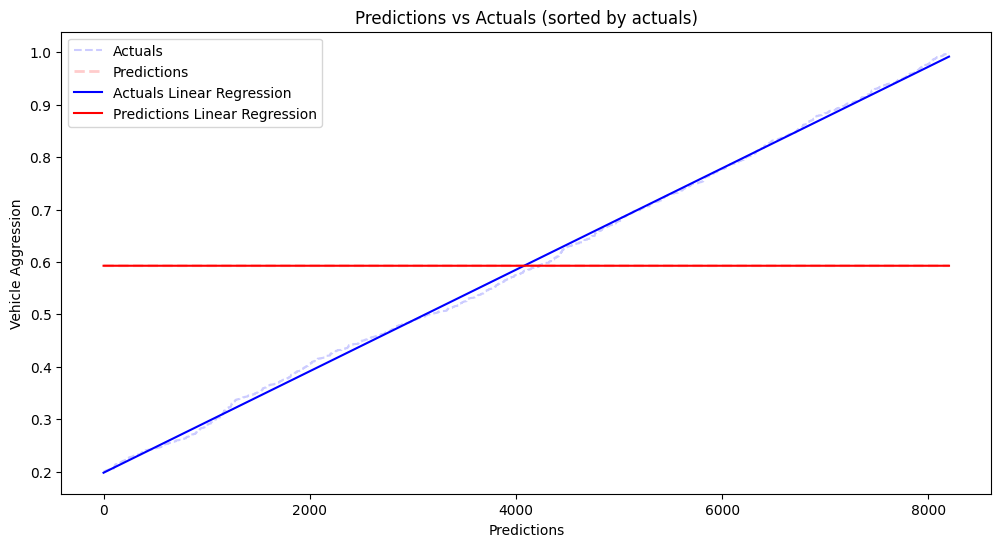

[I 2023-05-21 02:57:01,993] Trial 34 finished with value: 0.052872245701459736 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.7711!
Epoch 1 loss improved from 0.7711 to 0.7215!
Epoch 2 loss improved from 0.7215 to 0.6643!
Epoch 3 loss improved from 0.6643 to 0.5694!
Epoch 4 loss improved from 0.5694 to 0.3492!
Epoch 5 loss improved from 0.3492 to 0.1361!
Epoch 6 loss improved from 0.1361 to 0.0611!
Epoch 7 loss improved from 0.0611 to 0.0523!
Epoch 8 loss did not improve from 0.0523! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0523! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0523! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0523! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0523! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0523! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0523! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0523! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0523! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0523! Rem

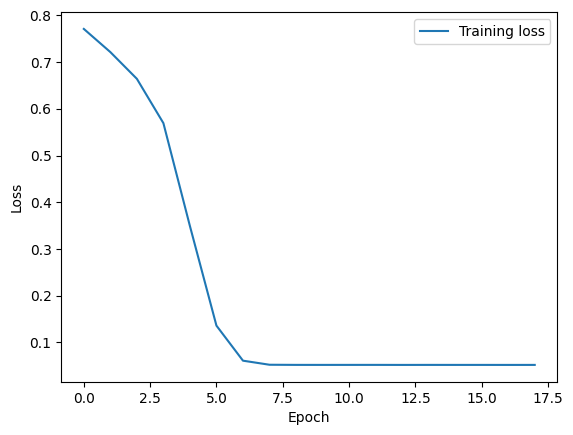

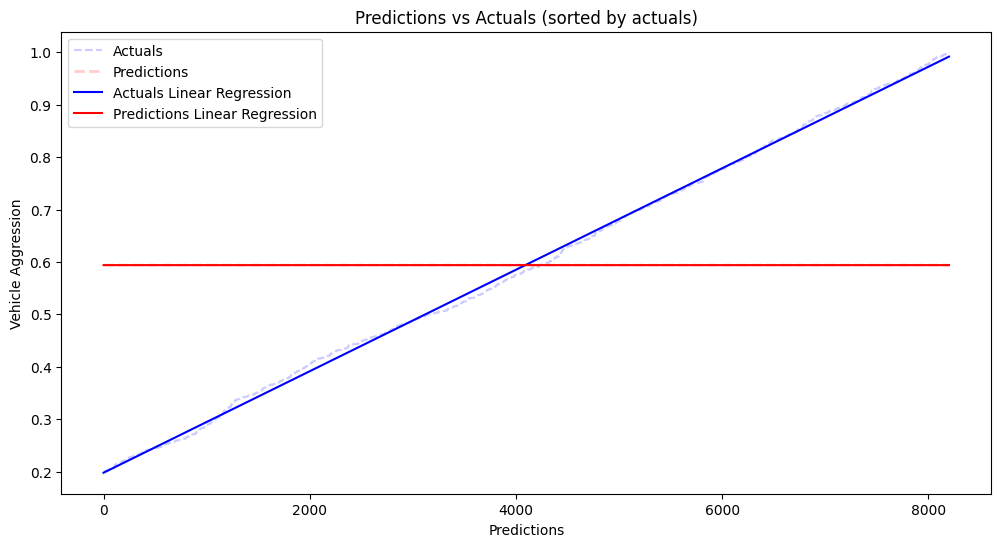

[I 2023-05-21 02:57:24,770] Trial 35 finished with value: 0.052865478224479234 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.5837!
Epoch 1 loss improved from 0.5837 to 0.5398!
Epoch 2 loss improved from 0.5398 to 0.4912!
Epoch 3 loss improved from 0.4912 to 0.4224!
Epoch 4 loss improved from 0.4224 to 0.2950!
Epoch 5 loss improved from 0.2950 to 0.1225!
Epoch 6 loss improved from 0.1225 to 0.0562!
Epoch 7 loss improved from 0.0562 to 0.0521!
Epoch 8 loss did not improve from 0.0521! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0521! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0521! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0521! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0521! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0521! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0521! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0521! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0521! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0521! Rem

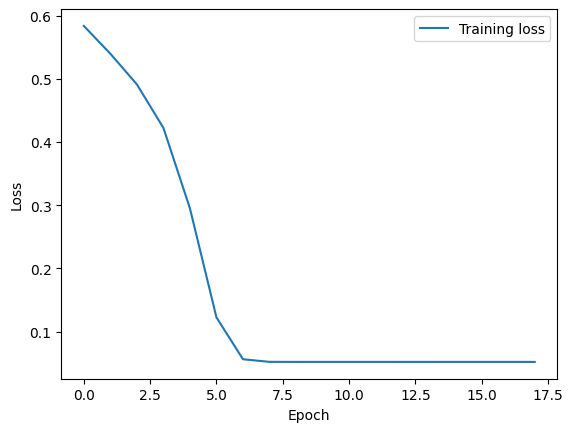

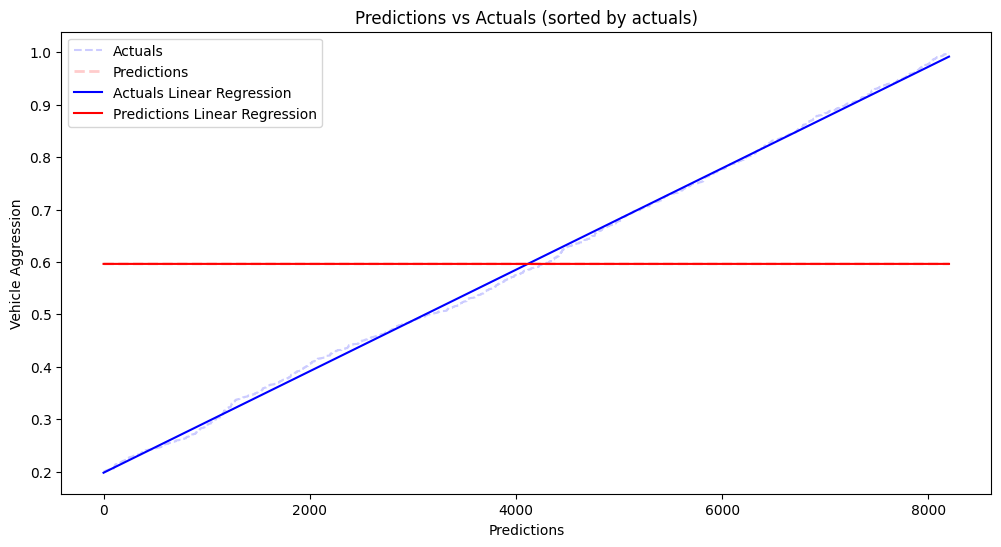

[I 2023-05-21 02:57:47,947] Trial 36 finished with value: 0.0528611092040172 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.3308!
Epoch 1 loss improved from 0.3308 to 0.2947!
Epoch 2 loss improved from 0.2947 to 0.2544!
Epoch 3 loss improved from 0.2544 to 0.2034!
Epoch 4 loss improved from 0.2034 to 0.1279!
Epoch 5 loss improved from 0.1279 to 0.0639!
Epoch 6 loss improved from 0.0639 to 0.0523!
Epoch 7 loss did not improve from 0.0523! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0523! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0523! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0523! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0523! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0523! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0523! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0523! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0523! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0523! Remaining epochs: 0
Early stopping!


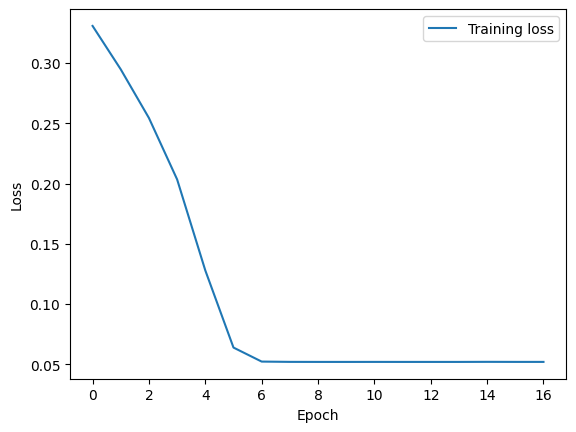

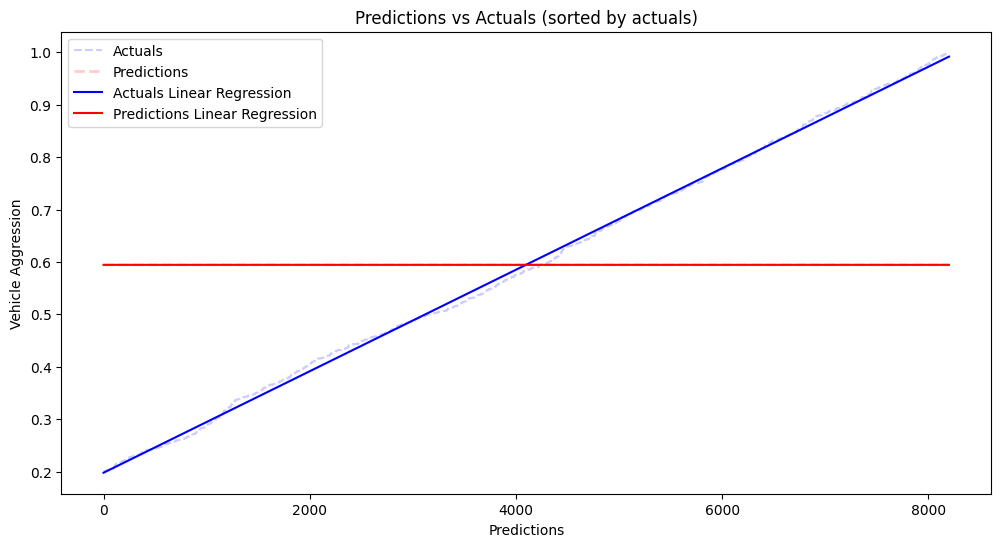

[I 2023-05-21 02:58:09,903] Trial 37 finished with value: 0.05286347006375973 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.6939!
Epoch 1 loss improved from 0.6939 to 0.6373!
Epoch 2 loss improved from 0.6373 to 0.5695!
Epoch 3 loss improved from 0.5695 to 0.4715!
Epoch 4 loss improved from 0.4715 to 0.2988!
Epoch 5 loss improved from 0.2988 to 0.1247!
Epoch 6 loss improved from 0.1247 to 0.0616!
Epoch 7 loss improved from 0.0616 to 0.0526!
Epoch 8 loss did not improve from 0.0526! Remaining epochs: 9
Epoch 9 loss did not improve from 0.0526! Remaining epochs: 8
Epoch 10 loss did not improve from 0.0526! Remaining epochs: 7
Epoch 11 loss did not improve from 0.0526! Remaining epochs: 6
Epoch 12 loss did not improve from 0.0526! Remaining epochs: 5
Epoch 13 loss did not improve from 0.0526! Remaining epochs: 4
Epoch 14 loss did not improve from 0.0526! Remaining epochs: 3
Epoch 15 loss did not improve from 0.0526! Remaining epochs: 2
Epoch 16 loss did not improve from 0.0526! Remaining epochs: 1
Epoch 17 loss did not improve from 0.0526! Rem

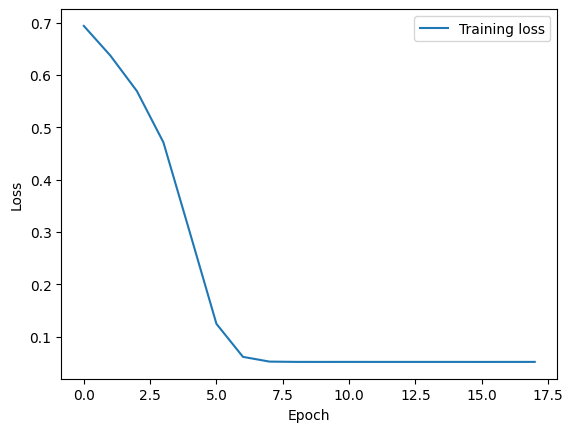

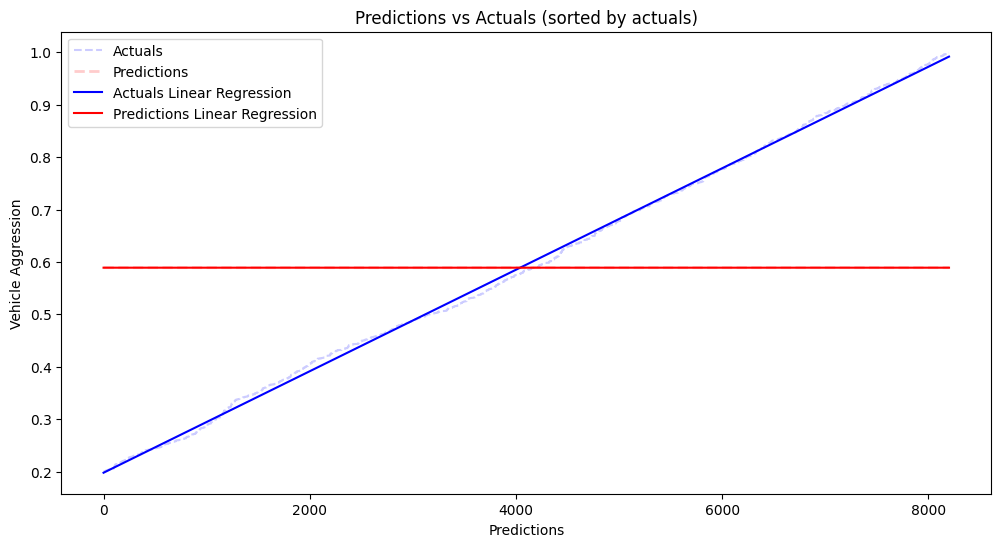

[I 2023-05-21 02:58:33,126] Trial 38 finished with value: 0.052911384919515025 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


X_train.shape: (32806, 100, 25)
Epoch 0 loss improved from inf to 0.2844!
Epoch 1 loss improved from 0.2844 to 0.2499!
Epoch 2 loss improved from 0.2499 to 0.2149!
Epoch 3 loss improved from 0.2149 to 0.1758!
Epoch 4 loss improved from 0.1758 to 0.1223!
Epoch 5 loss improved from 0.1223 to 0.0697!
Epoch 6 loss improved from 0.0697 to 0.0528!
Epoch 7 loss did not improve from 0.0528! Remaining epochs: 9
Epoch 8 loss did not improve from 0.0528! Remaining epochs: 8
Epoch 9 loss did not improve from 0.0528! Remaining epochs: 7
Epoch 10 loss did not improve from 0.0528! Remaining epochs: 6
Epoch 11 loss did not improve from 0.0528! Remaining epochs: 5
Epoch 12 loss did not improve from 0.0528! Remaining epochs: 4
Epoch 13 loss did not improve from 0.0528! Remaining epochs: 3
Epoch 14 loss did not improve from 0.0528! Remaining epochs: 2
Epoch 15 loss did not improve from 0.0528! Remaining epochs: 1
Epoch 16 loss did not improve from 0.0528! Remaining epochs: 0
Early stopping!


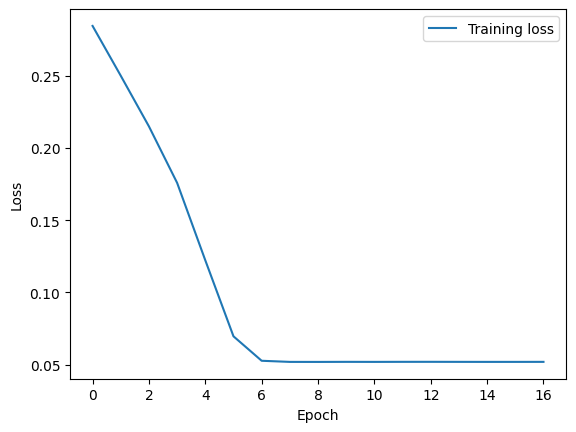

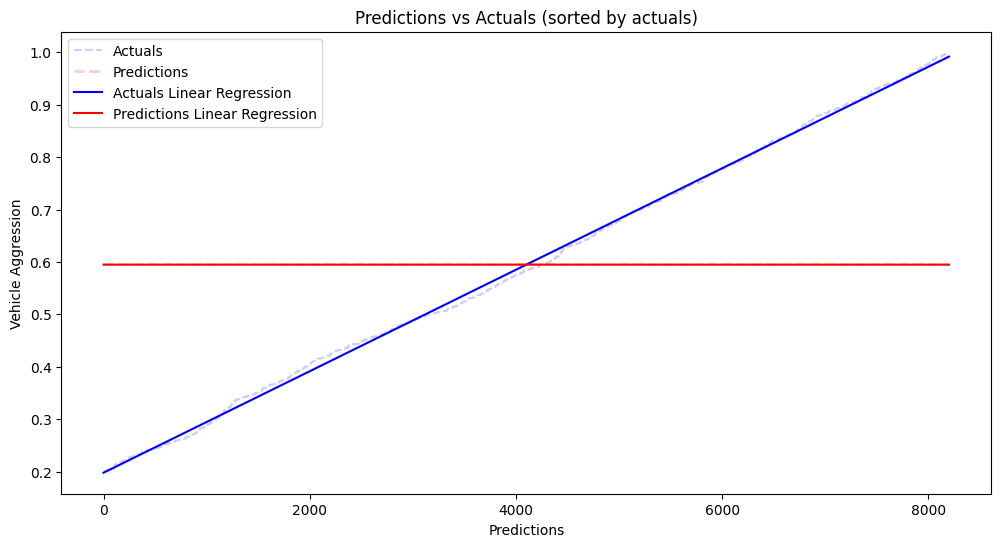

[I 2023-05-21 02:58:53,456] Trial 39 finished with value: 0.05286258063637293 and parameters: {}. Best is trial 15 with value: 0.05286034506100875.


Best trial 1:
	Value: 0.05286034506100875
	Params: {}
Best trial 2:
	Value: 0.05286070538254885
	Params: {}
Best trial 3:
	Value: 0.05286100661525359
	Params: {}
Best trial 4:
	Value: 0.0528611092040172
	Params: {}
Best trial 5:
	Value: 0.052861118545899026
	Params: {}


In [268]:
n_trials = 40
optimize_model('CNN', train_and_eval_cnn, n_trials)
optimize_model('DNN', train_and_eval_dnn, n_trials)
optimize_model('RNN', train_and_eval_rnn, n_trials)

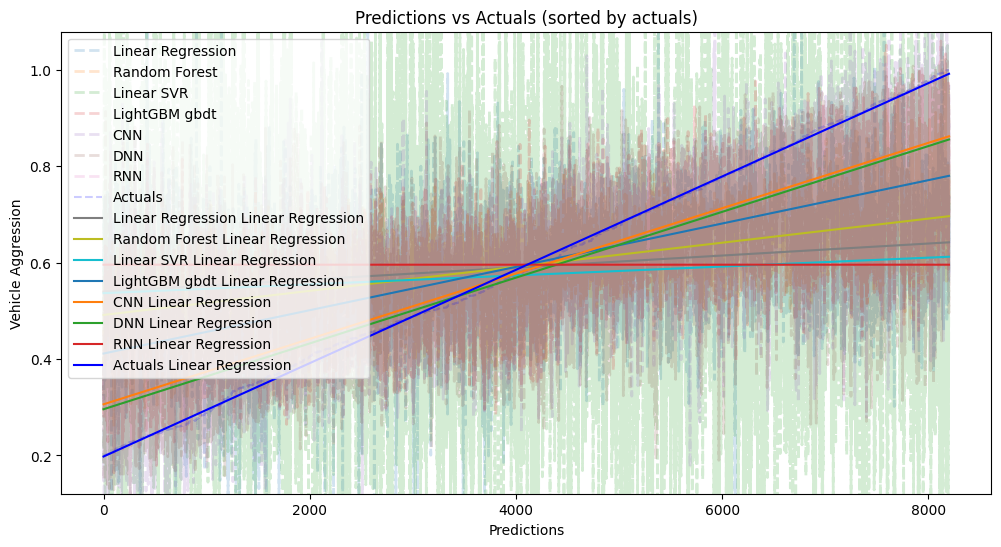

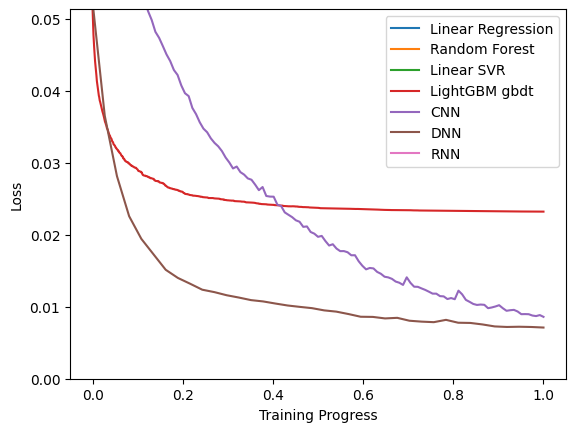

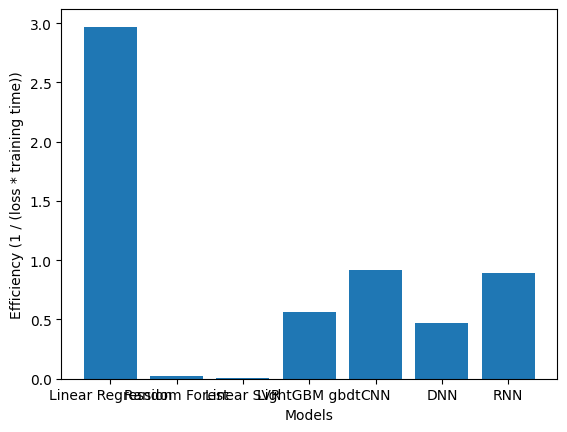

In [269]:
best_predictions = {}
for model, result in best_of_models.items():
    best_predictions[model] = result['predictions']
plot_evaluations(y_test, best_predictions)

best_losses_at_epoch = {}
for model, result in best_of_models.items():
    best_losses_at_epoch[model] = result['loss_at_epoch']
plot_trains(best_losses_at_epoch)

best_losses = {}
best_training_times = {}
for model, result in best_of_models.items():
    best_losses[model] = result['loss']
    best_training_times[model] = result['training_time']
plot_train_efficiencies(best_losses, best_training_times)